# Figure 4

In [1]:
import scanpy as sc
import pandas as pd
import pickle
import numpy as np
import plotnine as p9
import fisher
import sys
from tqdm.auto import tqdm

In [2]:
from pathlib import Path

sys.path.append(str(Path.home() / 'Code/sctoolkit')) #https://github.com/gokceneraslan/sctoolkit/

In [3]:
from sctoolkit.revigo import enrich_and_simplify, plot_revigo, revigo
from sctoolkit.mgsa import mgsa, plot_mgsa, plot_mgsa_diagnostics, get_go_gaf

In [4]:
sc.set_figure_params(dpi=100)
sc.settings.figdir = 'figures/'

## Read data

In [ ]:
adata = sc.read('../atlas.h5ad')

In [6]:
len(adata.obs['Broad cell type'].cat.categories)

44

## Read muscle disease gene table

In [7]:
muscle_diseases = pd.read_feather('preprocessing-muscle-diseases/musclediseasegenes-processed.feather')
muscle_diseases

Disease group         Disease subgroup  \
0             Muscular dystrophies                      Dmd   
1             Muscular dystrophies                     Edmd   
2             Muscular dystrophies                     Edmd   
3             Muscular dystrophies                     Edmd   
4             Muscular dystrophies                     Edmd   
..                             ...                      ...   
923  Other neuromuscular disorders  Coenzyme q10 deficiency   
924  Other neuromuscular disorders  Coenzyme q10 deficiency   
925  Other neuromuscular disorders  Coenzyme q10 deficiency   
926  Other neuromuscular disorders                            
927  Other neuromuscular disorders                            

                                     Disease phenotype   Gene   Item  \
0          Duchenne/Becker Muscular Dystrophies - (XR)    DMD    1.1   
1    Emery-Dreifuss muscular dystrophy, X-linked , ...    EMD    1.2   
2    Emery-Dreifuss muscular dystrophy 6, X-linked ...   FHL1    1.3   
3    Emery-Dreifuss muscular dystrophy 2, autosomal...   LMNA    1.4   
4    Emery-Dreifuss muscular dystrophy 3, autosomal...   LMNA    1.5   
..                                                 ...    ...    ...   
923                   Coenzyme Q10 deficiency 6 - (AR)   COQ6  16.75   
924                   Coenzyme Q10 deficiency 7 - (AR)   COQ4  16.76   
925                   Coenzyme Q10 deficiency 8 - (AR)   COQ7  16.77   
926  Sensory motor axonal neuropathy and myopathy -...   FDX2  16.78   
927                         Spectraplakinopathy - (AR)  MACF1  16.79   

                      Gene symbol (chromosome) protein  \
0                             DMD (Xp21.2)  Dystrophin   
1                                   EMD (Xq28)  Emerin   
2          FHL1 (Xq26.3)  Four and a half LIM domain 1   
3                               LMNA (1q22)  Lamin A/C   
4                               LMNA (1q22)  Lamin A/C   
..                                                 ...   
923                     COQ6 (14q24.3)  Coenzyme Q6(M)   
924                     COQ4 (9q34.11)  Coenzyme Q4(M)   
925                     COQ7 (16p12.3)  Coenzyme Q7(M)   
926                      FDX2 (19p13.2)  Ferredoxin(M)   
927  MACF1 (1p34.3)  Microtubule-actin cross-linkin...   

                                Disease group subgroup  \
0                           Muscular dystrophies (DMD)   
1                          Muscular dystrophies (EDMD)   
2                          Muscular dystrophies (EDMD)   
3                          Muscular dystrophies (EDMD)   
4                          Muscular dystrophies (EDMD)   
..                                                 ...   
923  Other neuromuscular disorders (Coenzyme Q10 de...   
924  Other neuromuscular disorders (Coenzyme Q10 de...   
925  Other neuromuscular disorders (Coenzyme Q10 de...   
926                      Other neuromuscular disorders   
927                      Other neuromuscular disorders   

                                            disease_id  \
0    Muscular dystrophies-DMD-Duchenne/becker muscu...   
1    Muscular dystrophies-EDMD-Emery-dreifuss muscu...   
2    Muscular dystrophies-EDMD-Emery-dreifuss muscu...   
3    Muscular dystrophies-EDMD-Emery-dreifuss muscu...   
4    Muscular dystrophies-EDMD-Emery-dreifuss muscu...   
..                                                 ...   
923  Other neuromuscular disorders-Coenzyme Q10 def...   
924  Other neuromuscular disorders-Coenzyme Q10 def...   
925  Other neuromuscular disorders-Coenzyme Q10 def...   
926  Other neuromuscular disorders-Sensory motor ax...   
927  Other neuromuscular disorders-Spectraplakinopa...   

                                           disease_cat  \
0                             Muscular dystrophies-DMD   
1                            Muscular dystrophies-EDMD   
2                            Muscular dystrophies-EDMD   
3                            Muscular dystrophies-EDMD   
4                 

## Load DEGs

In [16]:
de = pd.read_pickle('../DE/de_granular.pkl')
de_broad = pd.read_pickle('../DE/de_broad.pkl')

In [18]:
de.shape

(2814679, 14)

In [20]:
de_broad.shape

(1871005, 14)

In [22]:
de = pd.concat([v.assign(tissue=k) for k,v in de_dict_granular.items()], axis=0)
de = de.drop(columns='marker').drop_duplicates()
de = de[de.tissue.isin(['Esophagus muscularis', 'Skeletal muscle', 'Heart'])].copy()
de = de.rename(columns={'group': 'celltype', 'genes': 'gene'})
de['spring_score_nonzero'] = np.maximum(de.spring_score, 0)

In [23]:
de_broad = pd.concat([v.assign(tissue=k) for k,v in de_dict_broad.items()], axis=0)
de_broad = de_broad.drop(columns='marker').drop_duplicates()
de_broad = de_broad[de_broad.tissue.isin(['Esophagus muscularis', 'Skeletal muscle', 'Heart'])].copy()
de_broad = de_broad.rename(columns={'group': 'celltype', 'genes': 'gene'})

de_broad['significant'] = (de_broad['pvals_fdr'] < 0.05) & (de_broad['log2FC'] > 0.5)        
de_broad['spring_score_nonzero'] = np.maximum(de_broad.spring_score, 0)
de_broad['sig_and_pos'] = de_broad.significant & (de_broad.log2FC>1)

In [24]:
de_broad['tissue-celltype'] = de_broad.tissue + '|' + de_broad.celltype

In [25]:
de['tissue-celltype'] = de.tissue.astype(str) + '|' + de.celltype.astype(str)

In [26]:
de

celltype      gene      tstat          pvals      pvals_fdr  \
0                Adipocyte     ACACB  37.600513   1.635278e-83   3.867618e-82   
1                Adipocyte     FOXO1  31.546423   1.431791e-72   2.794329e-71   
2                Adipocyte     ACSL1  26.877287   1.421930e-62   2.405072e-61   
3                Adipocyte      EBF1  23.022795   6.833904e-54   9.959419e-53   
4                Adipocyte     ZFP36  22.945635   8.416230e-54   1.224412e-52   
...                    ...       ...        ...            ...            ...   
362379  Myocyte (NMJ-rich)    ZNF143 -38.182102   0.000000e+00   0.000000e+00   
362380  Myocyte (NMJ-rich)      MPP7 -38.424362  5.540337e-286  1.521007e-282   
362381  Myocyte (NMJ-rich)  CDK5RAP1 -38.694305   0.000000e+00   0.000000e+00   
362382  Myocyte (NMJ-rich)     TTC14 -41.574516   0.000000e+00   0.000000e+00   
362383  Myocyte (NMJ-rich)     YPEL2 -45.607082   0.000000e+00   0.000000e+00   

           log2FC  fraction_group  fraction_rest  mean_expressed  \
0        6.415906        0.976190       0.109954        2.168533   
1        3.552039        0.976190       0.341067        1.731564   
2        6.793871        0.922619       0.040376        1.633116   
3        2.877583        0.928571       0.259109        1.306253   
4        2.970431        0.946429       0.326540        1.450434   
...           ...             ...            ...             ...   
362379 -24.966595        0.000000       0.045570        0.000000   
362380 -25.217653        0.000000       0.052396        0.000000   
362381 -24.998909        0.000000       0.046642        0.000000   
362382 -25.262846        0.000000       0.055451        0.000000   
362383 -25.772398        0.000000       0.077196        0.000000   

        spring_score                tissue  significant  spring_score_nonzero  \
0           5.996749  Esophagus muscularis         True              5.996749   
1           2.655452  Esophagus muscularis         True              2.655452   
2           5.957895  Esophagus muscularis         True              5.957895   
3           1.932728  Esophagus muscularis         True              1.932728   
4           1.586869  Esophagus muscularis         True              1.586869   
...              ...                   ...          ...                   ...   
362379     -0.218708       Skeletal muscle        False              0.000000   
362380     -0.234751       Skeletal muscle        False              0.000000   
362381     -0.222094       Skeletal muscle        False              0.000000   
362382     -0.245074       Skeletal muscle        False              0.000000   
362383     -0.280387       Skeletal muscle        False              0.000000   

                           tissue-celltype  
0           Esophagus muscularis|Adipocyte  
1           Esophagus muscularis|Adipocyte  
2           Esophagus muscularis|Adipocyte  
3           Esophagus muscularis|Adipocyte  
4           Esophagus muscularis|Adipocyte  
...                                    ...  
362379  Skeletal muscle|Myocyte (NMJ-rich)  
362380  Skeletal muscle|Myocyte (NMJ-rich)  
362381  Skeletal muscle|Myocyte (NMJ-rich)  
362382  Skeletal muscle|Myocyte (NMJ-rich)  
362383  Skeletal muscle|Myocyte (NMJ-rich)  

[1100445 rows x 14 columns]

In [27]:
de_broad

celltype      gene      tstat          pvals      pvals_fdr  \
0                Adipocyte     ACACB  32.576984   4.963062e-76   1.280531e-74   
1                Adipocyte     FOXO1  28.069702   9.730296e-67   2.160926e-65   
2                Adipocyte     ACSL1  25.002363   1.620656e-59   3.115715e-58   
3                Adipocyte      EBF1  22.526060   1.178825e-53   2.030805e-52   
4                Adipocyte     ZFP36  22.019390   1.897539e-52   3.203053e-51   
...                    ...       ...        ...            ...            ...   
230603  Myocyte (NMJ-rich)       FYN -37.774811  4.286173e-179  3.069645e-176   
230604  Myocyte (NMJ-rich)    ZNF143 -38.177544   0.000000e+00   0.000000e+00   
230605  Myocyte (NMJ-rich)  CDK5RAP1 -38.647827   0.000000e+00   0.000000e+00   
230606  Myocyte (NMJ-rich)     TTC14 -41.263119   0.000000e+00   0.000000e+00   
230607  Myocyte (NMJ-rich)     YPEL2 -44.572960   0.000000e+00   0.000000e+00   

           log2FC  fraction_group  fraction_rest  mean_expressed  \
0        6.286887        0.942857       0.109948        2.162048   
1        3.457002        0.954286       0.341049        1.715338   
2        6.689299        0.891429       0.040355        1.627090   
3        2.840077        0.920000       0.259015        1.298342   
4        2.923974        0.931429       0.326490        1.447817   
...           ...             ...            ...             ...   
230603 -25.920794        0.000000       0.078130        0.000000   
230604 -24.965832        0.000000       0.045546        0.000000   
230605 -24.998146        0.000000       0.046618        0.000000   
230606 -25.262081        0.000000       0.055422        0.000000   
230607 -25.771627        0.000000       0.077155        0.000000   

        spring_score                tissue  significant  spring_score_nonzero  \
0           5.761201  Esophagus muscularis         True              5.761201   
1           2.549207  Esophagus muscularis         True              2.549207   
2           5.732581  Esophagus muscularis         True              5.732581   
3           1.883308  Esophagus muscularis         True              1.883308   
4           1.556795  Esophagus muscularis         True              1.556795   
...              ...                   ...          ...                   ...   
230603     -0.265248       Skeletal muscle        False              0.000000   
230604     -0.218926       Skeletal muscle        False              0.000000   
230605     -0.222308       Skeletal muscle        False              0.000000   
230606     -0.245120       Skeletal muscle        False              0.000000   
230607     -0.278368       Skeletal muscle        False              0.000000   

        sig_and_pos                     tissue-celltype  
0              True      Esophagus muscularis|Adipocyte  
1              True      Esophagus muscularis|Adipocyte  
2              True      Esophagus muscularis|Adipocyte  
3              True      Esophagus muscularis|Adipocyte  
4              True      Esophagus muscularis|Adipocyte  
...             ...                                 ...  
230603        False  Skeletal muscle|Myocyte (NMJ-rich)  
230604        False  Skeletal muscle|Myocyte (NMJ-rich)  
230605        False  Skeletal muscle|Myocyte (NMJ-rich)  
230606        False  Skeletal muscle|Myocyte (NMJ-rich)  
230607        False  Skeletal muscle|Myocyte (NMJ-rich)  

[683516 rows x 15 columns]

## Fisher test for disease group enrichments

In [28]:
background = sorted(list(set(sorted(de_broad[de_broad.sig_and_pos].gene.unique()) + muscle_diseases.Gene.unique().tolist())))

In [29]:
fisher_df = pd.DataFrame(dict(background=background))
fisher_df

background
0             78
1           A1BG
2           A1CF
3            A2M
4        A3GALT2
...          ...
13983       ZXDA
13984       ZXDB
13985       ZXDC
13986        ZYX
13987      ZZEF1

[13988 rows x 1 columns]

In [30]:
for disease in sorted(muscle_diseases['Disease group'].unique()):
    fisher_df[disease] = False
    disease_genes = muscle_diseases[muscle_diseases['Disease group'] == disease].Gene.unique()
    fisher_df[disease].loc[fisher_df.background.isin(disease_genes)] = True

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
for tc in sorted(de_broad['tissue-celltype'].unique()):
    fisher_df[tc] = False
    de_genes = de_broad[(de_broad['tissue-celltype'] == tc) & (de_broad.sig_and_pos)].gene.unique().tolist()
    fisher_df[tc].loc[fisher_df.background.isin(de_genes)] = True

In [32]:
fisher_pval = pd.DataFrame(1, index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))
fisher_logodds = pd.DataFrame(0, index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))
fisher_intersections = pd.DataFrame(index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))

from fisher import pvalue
from statsmodels.stats.multitest import multipletests

for disease in tqdm(sorted(muscle_diseases['Disease group'].unique())):
    for tc in sorted(de_broad['tissue-celltype'].unique()):
        m = pd.crosstab(fisher_df[disease], fisher_df[tc])
        try:
            a = m.loc[True, True]
        except KeyError:
            a = 0
        try:
            b = m.loc[True, False]
        except KeyError:
            b = 0
        try:
            c = m.loc[False, True]
        except KeyError:
            c = 0        
        try:
            d = m.loc[False, False]
        except KeyError:
            d = 0

        with np.errstate(invalid='ignore', divide='ignore'):
            fisher_logodds.loc[disease, tc] = np.log2((a*d) / (b*c))
        fisher_pval.loc[disease, tc] = pvalue(a, b, c, d).right_tail
        ints = tuple(fisher_df.background[fisher_df[disease] & fisher_df[tc]].tolist())
        fisher_intersections.loc[disease, tc] = ints

fdr = multipletests(fisher_pval.values.flatten(), method='fdr_bh')[1]
fisher_pval = pd.DataFrame(fdr.reshape(fisher_pval.shape), index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))

fisher_result = fisher_pval.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='pval_fdr').rename(columns={'index': 'Disease group'})
fisher_result['logOR'] = fisher_logodds.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='logOR').logOR
fisher_result['significant'] = (fisher_result.pval_fdr < 0.1) & (fisher_result.logOR>0)
fisher_result['neglog_pval_adj'] = -np.log10(fisher_result.pval_fdr.tolist())
fisher_result['tissue'] = [x.split('|')[0] for x in fisher_result['tissue-celltype']]
fisher_result['celltype'] = [x.split('|')[1] for x in fisher_result['tissue-celltype']]
fisher_result['intersection'] = fisher_intersections.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='intersection').intersection
fisher_result['intersection_size'] = [len(x) for x in fisher_result['intersection']]
fisher_result['intersection'] = [','.join(x) for x in fisher_result['intersection']]
fisher_result = fisher_result.sort_values('pval_fdr').reset_index(drop=True)
fisher_result

  0%|          | 0/16 [00:00<?, ?it/s]

Disease group  \
0      Hereditary cardiomyopathies   
1      Hereditary cardiomyopathies   
2             Metabolic myopathies   
3            Congenital myopathies   
4      Hereditary cardiomyopathies   
..                             ...   
651          Congenital myopathies   
652              Distal myopathies   
653             Hereditary ataxias   
654          Motor neuron diseases   
655  Other neuromuscular disorders   

                                       tissue-celltype      pval_fdr  \
0                              Heart|Myocyte (cardiac)  4.237077e-12   
1                 Heart|Myocyte (cardiac, cytoplasmic)  1.443104e-11   
2                       Esophagus muscularis|Adipocyte  3.278177e-05   
3    Skeletal muscle|Myocyte (sk. muscle, cytoplasmic)  7.073482e-05   
4         Esophagus muscularis|Myocyte (smooth muscle)  1.053007e-04   
..                                                 ...           ...   
651                                    Heart|Adipocyte  1.000000e+00   
652                                    Heart|Adipocyte  1.000000e+00   
653                                    Heart|Adipocyte  1.000000e+00   
654                 Heart|Endothelial cell (lymphatic)  1.000000e+00   
655                       Skeletal muscle|Schwann cell  1.000000e+00   

        logOR  significant  neglog_pval_adj                tissue  \
0    2.288078         True        11.372934                 Heart   
1    2.249841         True        10.840702                 Heart   
2    3.100380         True         4.484368  Esophagus muscularis   
3    2.293731         True         4.150367       Skeletal muscle   
4    1.566715         True         3.977569  Esophagus muscularis   
..        ...          ...              ...                   ...   
651 -2.283403        False        -0.000000                 Heart   
652      -inf        False        -0.000000                 Heart   
653  0.307362        False        -0.000000                 Heart   
654 -1.704972        False        -0.000000                 Heart   
655      -inf        False        -0.000000       Skeletal muscle   

                              celltype  \
0                    Myocyte (cardiac)   
1       Myocyte (cardiac, cytoplasmic)   
2                            Adipocyte   
3    Myocyte (sk. muscle, cytoplasmic)   
4              Myocyte (smooth muscle)   
..                                 ...   
651                          Adipocyte   
652                          Adipocyte   
653                          Adipocyte   
654       Endothelial cell (lymphatic)   
655                       Schwann cell   

                                          intersection  intersection_size  
0    ABCC9,ACTC1,ACTN2,AKAP9,ALPK3,ANK2,ANKRD1,CACN...                 55  
1    ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CALM1,CALM2,CALM...                 51  
2    ABHD5,ACADVL,ETFA,ETFDH,GBE1,GYS1,LDHA,LPIN1,P...                 14  
3    ACTA1,ACTN2,BIN1,CACNA1S,CFL2,HNRNPA1,HRAS,KLH...                 22  
4    ABCC9,ACTC1,ACTN2,ALPK3,BAG3,CACNA1C,CACNB2,CA...                 36  
..                                                 ...                ...  
651                                             SPTBN4                  1  
652                                                                     0  
653  ADCK3,APTX,BEAN1,ELOVL5,GDAP2,MME,PEX7,SLC1A3,...                  9  
654                                       KIF26B,REEP1                  2  
655                                                                     0  

[656 rows x 10 columns]

## Plotting

In [33]:
sig_tc = (fisher_result.groupby('tissue-celltype')['significant'].count() != fisher_result.groupby('tissue-celltype')['pval_fdr'].sum())
sig_tc = sig_tc[sig_tc].index.tolist()
fisher_result = fisher_result[fisher_result['tissue-celltype'].isin(sig_tc)]

sig_disease = (fisher_result.groupby('Disease group')['significant'].count() != fisher_result.groupby('Disease group')['pval_fdr'].sum())
sig_disease = sig_disease[sig_disease].index.tolist()
fisher_result = fisher_result[fisher_result['Disease group'].isin(sig_disease)]

In [34]:
df = fisher_result.copy()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 160 rows containing missing values.


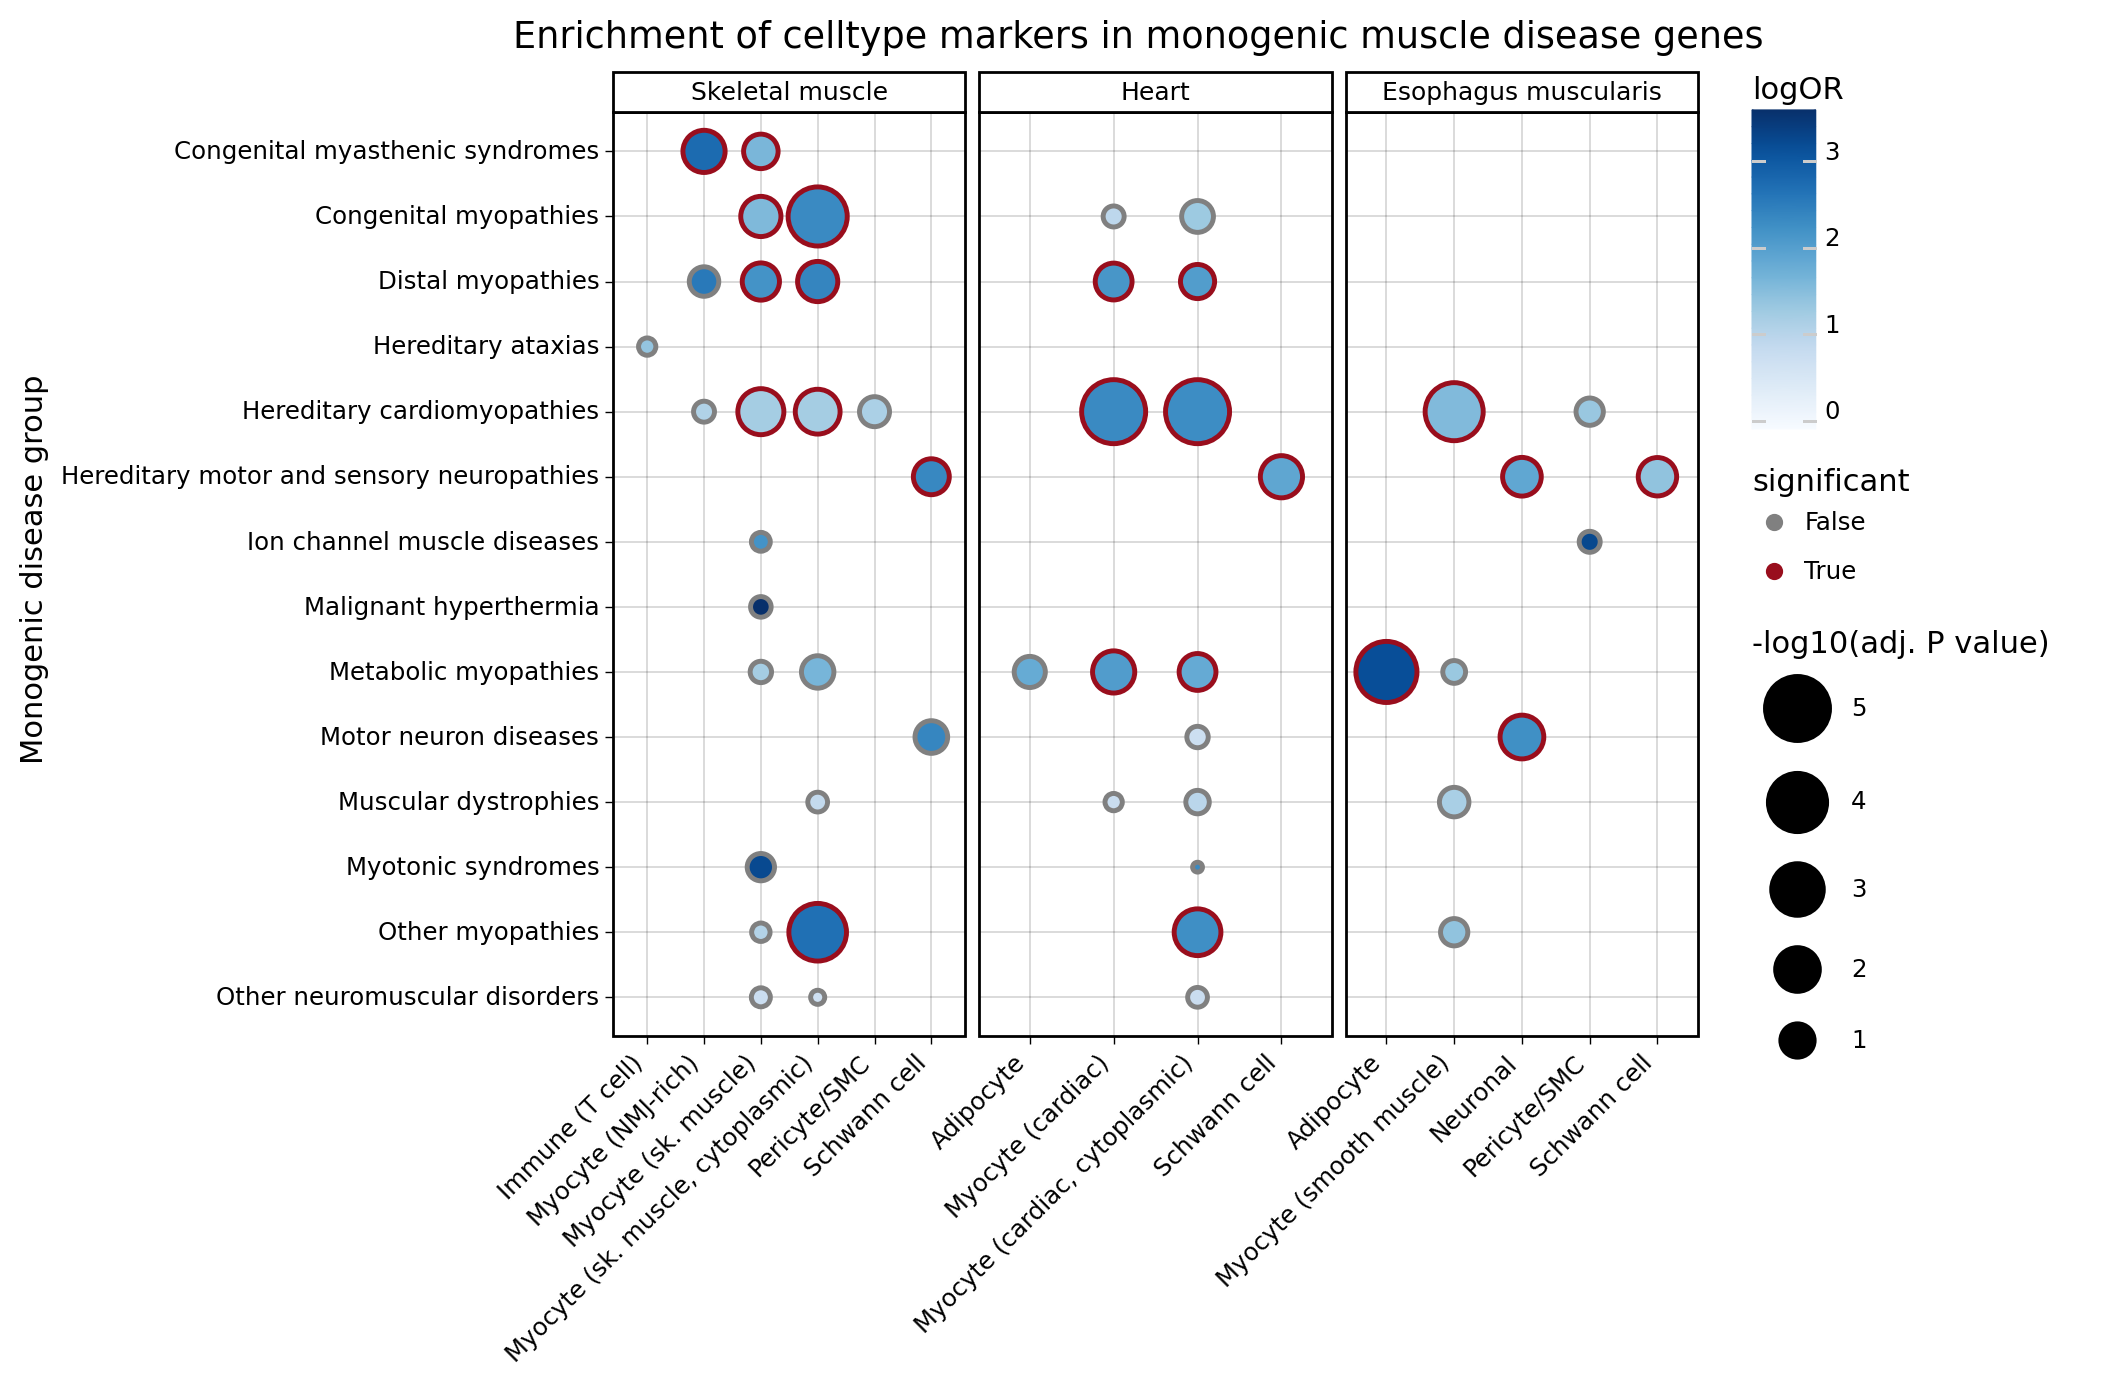

In [35]:
from plotnine import *

or_limit = 3.5
df.loc[df.logOR < -or_limit, 'logOR'] = -or_limit
df.loc[df.logOR > or_limit, 'logOR'] = or_limit
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5
df.loc[df.neglog_pval_adj == 0, 'neglog_pval_adj'] = np.nan

df['Disease group'] = pd.Categorical(df['Disease group'], categories=sorted(df['Disease group'].unique())[::-1])
df['tissue'] = pd.Categorical(df['tissue'], categories=['Skeletal muscle', 'Heart', 'Esophagus muscularis'])

limit = max(df.logOR.abs()) * np.array([-1, 1])

g = (
    ggplot(aes(x='celltype', y='Disease group'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='logOR', color='significant'), stroke=1)+
    facet_wrap('tissue', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
    scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Monogenic disease group', x='', title='Enrichment of celltype markers in monogenic muscle disease genes') +
    guides(size = guide_legend(reverse=True)) +
    theme_linedraw() +
    scale_size(range = (1,12)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=9, color='black', angle = 0),
     strip_text_y = element_text(size=9, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      figure_size=(7,6),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)
print(g)

## Fisher test for disease granular group enrichments

In [36]:
background = sorted(list(set(sorted(de_broad[de_broad.sig_and_pos].gene.unique()) + muscle_diseases.Gene.unique().tolist())))

In [37]:
fisher_df = pd.DataFrame(dict(background=background))
fisher_df.head()

background
0         78
1       A1BG
2       A1CF
3        A2M
4    A3GALT2

In [38]:
for disease in sorted(muscle_diseases['Disease group subgroup'].unique()):
    fisher_df[disease] = False
    disease_genes = muscle_diseases[muscle_diseases['Disease group subgroup'] == disease].Gene.unique()
    fisher_df[disease].loc[fisher_df.background.isin(disease_genes)] = True

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
for tc in sorted(de_broad['tissue-celltype'].unique()):
    fisher_df[tc] = False
    de_genes = de_broad[(de_broad['tissue-celltype'] == tc) & (de_broad.sig_and_pos)].gene.unique().tolist()
    fisher_df[tc].loc[fisher_df.background.isin(de_genes)] = True

In [40]:
fisher_pval = pd.DataFrame(1, index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))
fisher_logodds = pd.DataFrame(0, index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))
fisher_intersections = pd.DataFrame(index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))

from fisher import pvalue
from statsmodels.stats.multitest import multipletests

for disease in tqdm(sorted(muscle_diseases['Disease group subgroup'].unique())):
    for tc in sorted(de_broad['tissue-celltype'].unique()):
        m = pd.crosstab(fisher_df[disease], fisher_df[tc])
        try:
            a = m.loc[True, True]
        except KeyError:
            a = 0
        try:
            b = m.loc[True, False]
        except KeyError:
            b = 0
        try:
            c = m.loc[False, True]
        except KeyError:
            c = 0        
        try:
            d = m.loc[False, False]
        except KeyError:
            d = 0

        with np.errstate(invalid='ignore', divide='ignore'):
            fisher_logodds.loc[disease, tc] = np.log2((a*d) / (b*c))
        fisher_pval.loc[disease, tc] = pvalue(a, b, c, d).right_tail
        ints = tuple(fisher_df.background[fisher_df[disease] & fisher_df[tc]].tolist())
        fisher_intersections.loc[disease, tc] = ints

fdr = multipletests(fisher_pval.values.flatten(), method='fdr_bh')[1]
fisher_pval = pd.DataFrame(fdr.reshape(fisher_pval.shape), index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de_broad['tissue-celltype'].unique()))

fisher_result_subgroup = fisher_pval.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='pval_fdr').rename(columns={'index': 'Disease group subgroup'})
fisher_result_subgroup['logOR'] = fisher_logodds.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='logOR').logOR
fisher_result_subgroup['significant'] = (fisher_result_subgroup.pval_fdr < 0.1) & (fisher_result_subgroup.logOR>0)
fisher_result_subgroup['neglog_pval_adj'] = -np.log10(fisher_result_subgroup.pval_fdr.tolist())
fisher_result_subgroup['tissue'] = [x.split('|')[0] for x in fisher_result_subgroup['tissue-celltype']]
fisher_result_subgroup['celltype'] = [x.split('|')[1] for x in fisher_result_subgroup['tissue-celltype']]
fisher_result_subgroup['intersection'] = fisher_intersections.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='intersection').intersection
fisher_result_subgroup['intersection_size'] = [len(x) for x in fisher_result_subgroup['intersection']]
fisher_result_subgroup['intersection'] = [','.join(x) for x in fisher_result_subgroup['intersection']]
fisher_result_subgroup = fisher_result_subgroup.sort_values('pval_fdr').reset_index(drop=True)
fisher_result_subgroup

  0%|          | 0/63 [00:00<?, ?it/s]

Disease group subgroup  \
0     Hereditary cardiomyopathies (Arrhythmogenic ca...   
1     Hereditary cardiomyopathies (Non-arrhythmogeni...   
2     Hereditary motor and sensory neuropathies (Dej...   
3     Hereditary cardiomyopathies (Non-arrhythmogeni...   
4     Hereditary cardiomyopathies (Arrhythmogenic ca...   
...                                                 ...   
2578  Other neuromuscular disorders (Arthrogryposis,...   
2579  Other neuromuscular disorders (Coenzyme Q10 de...   
2580  Other neuromuscular disorders (Fetal akinesia ...   
2581           Other myopathies (Myofibrillar myopathy)   
2582  Other neuromuscular disorders (Progressive ext...   

                           tissue-celltype      pval_fdr     logOR  \
0                  Heart|Myocyte (cardiac)  7.216356e-08  2.910665   
1     Heart|Myocyte (cardiac, cytoplasmic)  7.216356e-08  2.457807   
2             Skeletal muscle|Schwann cell  2.283946e-05       inf   
3                  Heart|Myocyte (cardiac)  5.761165e-05  2.005840   
4     Heart|Myocyte (cardiac, cytoplasmic)  5.394260e-04  2.192427   
...                                    ...           ...       ...   
2578     Esophagus muscularis|Schwann cell  1.000000e+00  1.013321   
2579     Esophagus muscularis|Schwann cell  1.000000e+00      -inf   
2580     Esophagus muscularis|Schwann cell  1.000000e+00  2.822570   
2581     Esophagus muscularis|Schwann cell  1.000000e+00  0.650530   
2582          Skeletal muscle|Schwann cell  1.000000e+00      -inf   

      significant  neglog_pval_adj                tissue  \
0            True         7.141682                 Heart   
1            True         7.141682                 Heart   
2            True         4.641314       Skeletal muscle   
3            True         4.239490                 Heart   
4            True         3.268068                 Heart   
...           ...              ...                   ...   
2578        False        -0.000000  Esophagus muscularis   
2579        False        -0.000000  Esophagus muscularis   
2580        False        -0.000000  Esophagus muscularis   
2581        False        -0.000000  Esophagus muscularis   
2582        False        -0.000000       Skeletal muscle   

                            celltype  \
0                  Myocyte (cardiac)   
1     Myocyte (cardiac, cytoplasmic)   
2                       Schwann cell   
3                  Myocyte (cardiac)   
4     Myocyte (cardiac, cytoplasmic)   
...                              ...   
2578                    Schwann cell   
2579                    Schwann cell   
2580                    Schwann cell   
2581                    Schwann cell   
2582                    Schwann cell   

                                           intersection  intersection_size  
0     ABCC9,AKAP9,ANK2,CACNA1C,CACNB2,CASQ2,CAV3,CTN...                 29  
1     ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CAV3,CRYAB,CSRP3...                 34  
2                                    EGR2,MPZ,PMP22,PRX                  4  
3     ABCC9,ACTC1,ACTN2,ALPK3,ANKRD1,CAV3,DMD,DSG2,D...                 31  
4     CALM1,CALM2,CALM3,CASQ2,CAV3,DES,DSC2,DSG2,DSP...                 22  
...                                                 ...                ...  
2578                                             PIEZO2                  1  
2579                                                                     0  
2580                                          AGRN,MUSK                  2  
2581                                               MYOT                  1  
2582                                                                     0  

[2583 rows x 10 columns]

In [41]:
fisher_result

Disease group  \
0        Hereditary cardiomyopathies   
1        Hereditary cardiomyopathies   
2               Metabolic myopathies   
3              Congenital myopathies   
4        Hereditary cardiomyopathies   
..                               ...   
650  Congenital myasthenic syndromes   
651            Congenital myopathies   
652                Distal myopathies   
653               Hereditary ataxias   
655    Other neuromuscular disorders   

                                       tissue-celltype      pval_fdr  \
0                              Heart|Myocyte (cardiac)  4.237077e-12   
1                 Heart|Myocyte (cardiac, cytoplasmic)  1.443104e-11   
2                       Esophagus muscularis|Adipocyte  3.278177e-05   
3    Skeletal muscle|Myocyte (sk. muscle, cytoplasmic)  7.073482e-05   
4         Esophagus muscularis|Myocyte (smooth muscle)  1.053007e-04   
..                                                 ...           ...   
650                                    Heart|Adipocyte  1.000000e+00   
651                                    Heart|Adipocyte  1.000000e+00   
652                                    Heart|Adipocyte  1.000000e+00   
653                                    Heart|Adipocyte  1.000000e+00   
655                       Skeletal muscle|Schwann cell  1.000000e+00   

        logOR  significant  neglog_pval_adj                tissue  \
0    2.288078         True        11.372934                 Heart   
1    2.249841         True        10.840702                 Heart   
2    3.100380         True         4.484368  Esophagus muscularis   
3    2.293731         True         4.150367       Skeletal muscle   
4    1.566715         True         3.977569  Esophagus muscularis   
..        ...          ...              ...                   ...   
650 -0.728215        False        -0.000000                 Heart   
651 -2.283403        False        -0.000000                 Heart   
652      -inf        False        -0.000000                 Heart   
653  0.307362        False        -0.000000                 Heart   
655      -inf        False        -0.000000       Skeletal muscle   

                              celltype  \
0                    Myocyte (cardiac)   
1       Myocyte (cardiac, cytoplasmic)   
2                            Adipocyte   
3    Myocyte (sk. muscle, cytoplasmic)   
4              Myocyte (smooth muscle)   
..                                 ...   
650                          Adipocyte   
651                          Adipocyte   
652                          Adipocyte   
653                          Adipocyte   
655                       Schwann cell   

                                          intersection  intersection_size  
0    ABCC9,ACTC1,ACTN2,AKAP9,ALPK3,ANK2,ANKRD1,CACN...                 55  
1    ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CALM1,CALM2,CALM...                 51  
2    ABHD5,ACADVL,ETFA,ETFDH,GBE1,GYS1,LDHA,LPIN1,P...                 14  
3    ACTA1,ACTN2,BIN1,CACNA1S,CFL2,HNRNPA1,HRAS,KLH...                 22  
4    ABCC9,ACTC1,ACTN2,ALPK3,BAG3,CACNA1C,CACNB2,CA...                 36  
..                                                 ...                ...  
650                                      GFPT1,SLC25A1                  2  
651                                             SPTBN4                  1  
652                                                                     0  
653  ADCK3,APTX,BEAN1,ELOVL5,GDAP2,MME,PEX7,SLC1A3,...                  9  
655                                                                     0  

[210 rows x 10 columns]

In [42]:
fisher_result_combined = pd.concat([fisher_result, fisher_result_subgroup.rename(columns={'Disease group subgroup': 'Disease group'})], axis=0).reset_index(drop=True)

In [43]:
fisher_result_combined = fisher_result_combined.loc[fisher_result_combined.groupby(['Disease group', 'tissue-celltype'])['pval_fdr'].idxmin()].reset_index(drop=True)

## Plot combined plot

In [44]:
df = fisher_result_combined.copy()

In [45]:
sig_tc = (df.groupby('tissue-celltype')['significant'].sum() > 0)
sig_tc = sig_tc[sig_tc].index.tolist()
df = df[df['tissue-celltype'].isin(sig_tc)]

sig_disease = (df.groupby('Disease group')['significant'].sum() > 0)
sig_disease = sig_disease[sig_disease].index.tolist()
df = df[df['Disease group'].isin(sig_disease)]

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 7 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/figure-4a.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 150 rows containing missing values.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 150 rows containing missing values.


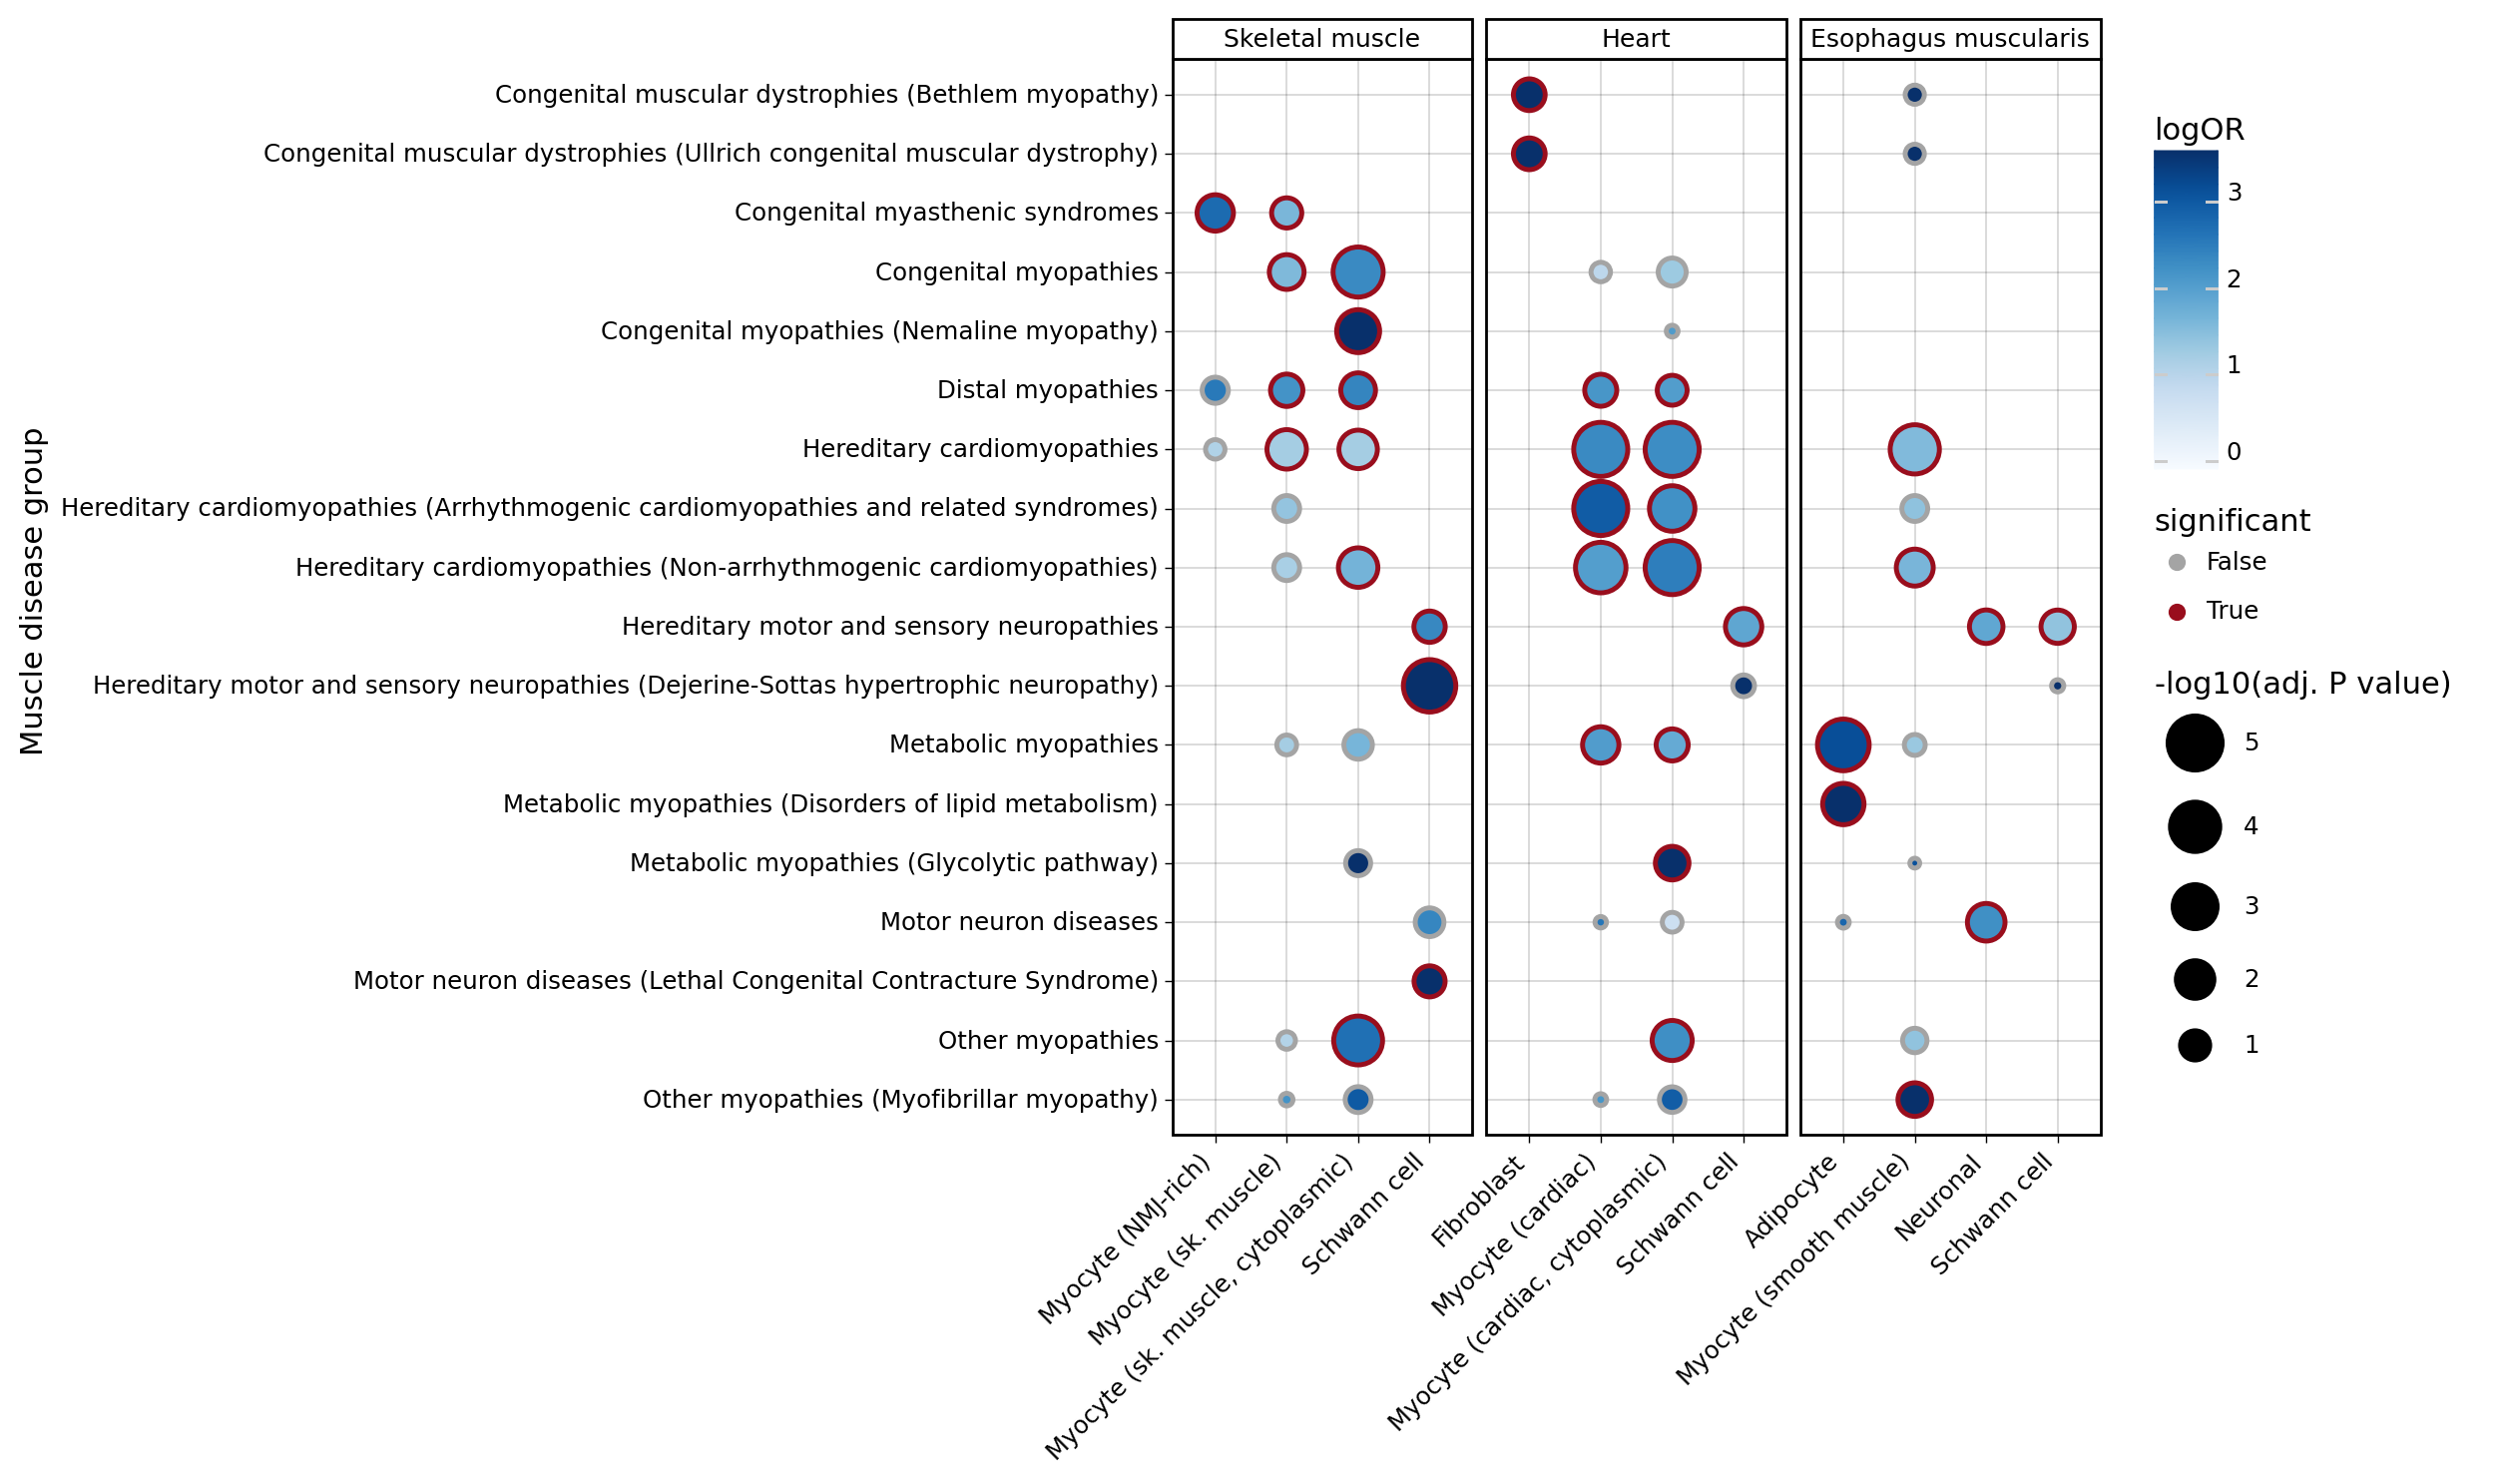

In [46]:
from plotnine import *

or_limit = 3.5
df.loc[df.logOR < -or_limit, 'logOR'] = -or_limit
df.loc[df.logOR > or_limit, 'logOR'] = or_limit
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5
df.loc[df.neglog_pval_adj == 0, 'neglog_pval_adj'] = np.nan

df['Disease group'] = pd.Categorical(df['Disease group'], categories=sorted(df['Disease group'].unique())[::-1])
df['tissue'] = pd.Categorical(df['tissue'], categories=['Skeletal muscle', 'Heart', 'Esophagus muscularis'])

limit = max(df.logOR.abs()) * np.array([-1, 1])

g = (
    ggplot(aes(x='celltype', y='Disease group'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='logOR', color='significant'), stroke=1)+
    facet_wrap('tissue', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
    scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#A4A4A4', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Muscle disease group', x='', title='') +
    guides(size = guide_legend(reverse=True)) +
    theme_linedraw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=9, color='black', angle = 0),
     strip_text_y = element_text(size=9, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      figure_size=(6,7),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)
ggsave(g, sc.settings.figdir / 'figure-4a.pdf', width=6, height=7)
print(g)

In [47]:
pd.options.display.max_colwidth = None

In [48]:
fisher_result_combined[fisher_result_combined['tissue-celltype'].str.contains('Adipocyte')].sort_values('pval_fdr').head(20)

Disease group  \
1383                                            Metabolic myopathies   
1398            Metabolic myopathies (Disorders of lipid metabolism)   
1388                                            Metabolic myopathies   
1890                                     Muscular dystrophies (EDMD)   
1439                Metabolic myopathies (Glycogen storage diseases)   
1521                                           Motor neuron diseases   
0                                    Congenital muscular dystrophies   
1685                            Motor neuron diseases (Neuronopathy)   
1699                            Motor neuron diseases (Neuronopathy)   
1712                            Motor neuron diseases (Neuronopathy)   
1726                              Motor neuron diseases (Neuropathy)   
1740                              Motor neuron diseases (Neuropathy)   
1753                              Motor neuron diseases (Neuropathy)   
1767                 Motor neuron diseases (Spinal muscular atrophy)   
1781                 Motor neuron diseases (Spinal muscular atrophy)   
1822                                            Muscular dystrophies   
1808                                            Muscular dystrophies   
1671  Motor neuron diseases (Lethal Congenital Contracture Syndrome)   
1835                                            Muscular dystrophies   
1849                                      Muscular dystrophies (DMD)   

                     tissue-celltype  pval_fdr     logOR  significant  \
1383  Esophagus muscularis|Adipocyte  0.000033  3.100380         True   
1398  Esophagus muscularis|Adipocyte  0.002713  3.872829         True   
1388                 Heart|Adipocyte  0.144776  1.793641        False   
1890  Esophagus muscularis|Adipocyte  0.640257  3.189753        False   
1439  Esophagus muscularis|Adipocyte  0.697812  2.382985        False   
1521  Esophagus muscularis|Adipocyte  0.869100  2.774601        False   
0     Esophagus muscularis|Adipocyte  1.000000  1.603403        False   
1685  Esophagus muscularis|Adipocyte  1.000000      -inf        False   
1699                 Heart|Adipocyte  1.000000      -inf        False   
1712       Skeletal muscle|Adipocyte  1.000000      -inf        False   
1726  Esophagus muscularis|Adipocyte  1.000000  0.602359        False   
1740                 Heart|Adipocyte  1.000000      -inf        False   
1753       Skeletal muscle|Adipocyte  1.000000  0.932274        False   
1767  Esophagus muscularis|Adipocyte  1.000000 -1.515410        False   
1781                 Heart|Adipocyte  1.000000      -inf        False   
1822                 Heart|Adipocyte  1.000000 -1.467478        False   
1808  Esophagus muscularis|Adipocyte  1.000000  0.249359        False   
1671       Skeletal muscle|Adipocyte  1.000000  0.057244        False   
1835       Skeletal muscle|Adipocyte  1.000000      -inf        False   
1849  Esophagus muscularis|Adipocyte  1.000000      -inf        False   

      neglog_pval_adj                tissue   celltype  \
1383         4.484368  Esophagus muscularis  Adipocyte   
1398         2.566616  Esophagus muscularis  Adipocyte   
1388         0.839302                 Heart  Adipocyte   
1890         0.193645  Esophagus muscularis  Adipocyte   
1439         0.156261  Esophagus muscularis  Adipocyte   
1521         0.060930  Esophagus muscularis  Adipocyte   
0           -0.000000  Esophagus muscularis  Adipocyte   
1685        -0.000000  Esophagus muscularis  Adipocyte   
1699        -0.000000                 Heart  Adipocyte   
1712        -0.000000       Skeletal muscle  Adipocyte   
1726        -0.000000  Esophagus muscularis  Adipocyte   
1740        -0.000000                 Heart  Adipocyte   
1753        -0.000000       Skeletal muscle  Adipocyte   
1767        -0.000000  Esophagus muscularis  Adipocyte   
1781        -0.000000                 Heart  Adipocyte   
1822        -0.000000                 Heart  Adipocyte   
1808        -0.000000 

## Save result table

In [49]:
fisher_result_combined[fisher_result_combined.intersection_size>0].drop(columns=['tissue-celltype']).to_excel('muscle-disease-DE-fisher-test.xlsx', index=False)

## GRANULAR Fisher test for disease group enrichments

In [50]:
background = sorted(list(set(sorted(de[de.significant].gene.unique()) + muscle_diseases.Gene.unique().tolist())))

In [51]:
fisher_df = pd.DataFrame(dict(background=background))
fisher_df

background
0             78
1           A1BG
2           A1CF
3            A2M
4          A2ML1
...          ...
15770     ZYG11A
15771     ZYG11B
15772        ZYX
15773      ZZEF1
15774       ZZZ3

[15775 rows x 1 columns]

In [52]:
for disease in sorted(muscle_diseases['Disease group'].unique()):
    fisher_df[disease] = False
    disease_genes = muscle_diseases[muscle_diseases['Disease group'] == disease].Gene.unique()
    fisher_df[disease].loc[fisher_df.background.isin(disease_genes)] = True

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
for tc in sorted(de['tissue-celltype'].unique()):
    fisher_df[tc] = False
    de_genes = de[(de['tissue-celltype'] == tc) & (de.significant)].gene.unique().tolist()
    fisher_df[tc].loc[fisher_df.background.isin(de_genes)] = True

In [54]:
fisher_pval = pd.DataFrame(1, index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de['tissue-celltype'].unique()))
fisher_logodds = pd.DataFrame(0, index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de['tissue-celltype'].unique()))
fisher_intersections = pd.DataFrame(index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de['tissue-celltype'].unique()))

from fisher import pvalue
from statsmodels.stats.multitest import multipletests

for disease in tqdm(sorted(muscle_diseases['Disease group'].unique())):
    for tc in sorted(de['tissue-celltype'].unique()):
        m = pd.crosstab(fisher_df[disease], fisher_df[tc])
        try:
            a = m.loc[True, True]
        except KeyError:
            a = 0
        try:
            b = m.loc[True, False]
        except KeyError:
            b = 0
        try:
            c = m.loc[False, True]
        except KeyError:
            c = 0        
        try:
            d = m.loc[False, False]
        except KeyError:
            d = 0

        with np.errstate(invalid='ignore', divide='ignore'):
            fisher_logodds.loc[disease, tc] = np.log2((a*d) / (b*c))
        fisher_pval.loc[disease, tc] = pvalue(a, b, c, d).right_tail
        ints = tuple(fisher_df.background[fisher_df[disease] & fisher_df[tc]].tolist())
        fisher_intersections.loc[disease, tc] = ints

fdr = multipletests(fisher_pval.values.flatten(), method='fdr_bh')[1]
fisher_pval = pd.DataFrame(fdr.reshape(fisher_pval.shape), index=sorted(muscle_diseases['Disease group'].unique()), columns=sorted(de['tissue-celltype'].unique()))

fisher_result = fisher_pval.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='pval_fdr').rename(columns={'index': 'Disease group'})
fisher_result['logOR'] = fisher_logodds.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='logOR').logOR
fisher_result['significant'] = (fisher_result.pval_fdr < 0.1) & (fisher_result.logOR>0)
fisher_result['neglog_pval_adj'] = -np.log10(fisher_result.pval_fdr.tolist())
fisher_result['tissue'] = [x.split('|')[0] for x in fisher_result['tissue-celltype']]
fisher_result['celltype'] = [x.split('|')[1] for x in fisher_result['tissue-celltype']]
fisher_result['intersection'] = fisher_intersections.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='intersection').intersection
fisher_result['intersection_size'] = [len(x) for x in fisher_result['intersection']]
fisher_result['intersection'] = [','.join(x) for x in fisher_result['intersection']]
fisher_result = fisher_result.sort_values('pval_fdr').reset_index(drop=True)
fisher_result

  0%|          | 0/16 [00:00<?, ?it/s]

Disease group  \
0         Hereditary cardiomyopathies   
1         Hereditary cardiomyopathies   
2               Congenital myopathies   
3                    Other myopathies   
4         Hereditary cardiomyopathies   
...                               ...   
1051    Other neuromuscular disorders   
1052  Congenital muscular dystrophies   
1053  Congenital myasthenic syndromes   
1054            Congenital myopathies   
1055    Other neuromuscular disorders   

                                         tissue-celltype      pval_fdr  \
0                                Heart|Myocyte (cardiac)  1.162401e-13   
1                   Heart|Myocyte (cardiac, cytoplasmic)  1.856464e-13   
2     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  3.106813e-08   
3     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  3.241838e-08   
4     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  1.491862e-06   
...                                                  ...           ...   
1051                                     Heart|Adipocyte  1.000000e+00   
1052      Heart|Endothelial cell (cardiac microvascular)  1.000000e+00   
1053      Heart|Endothelial cell (cardiac microvascular)  1.000000e+00   
1054                                     Heart|Adipocyte  1.000000e+00   
1055                        Skeletal muscle|Schwann cell  1.000000e+00   

         logOR  significant  neglog_pval_adj           tissue  \
0     2.396357         True        12.934644            Heart   
1     2.377021         True        12.731313            Heart   
2     3.312758         True         7.507685  Skeletal muscle   
3     3.801317         True         7.489209  Skeletal muscle   
4     2.224699         True         5.826271  Skeletal muscle   
...        ...          ...              ...              ...   
1051 -0.932080        False        -0.000000            Heart   
1052  0.488143        False        -0.000000            Heart   
1053  0.674946        False        -0.000000            Heart   
1054 -2.461494        False        -0.000000            Heart   
1055      -inf        False        -0.000000  Skeletal muscle   

                                      celltype  \
0                            Myocyte (cardiac)   
1               Myocyte (cardiac, cytoplasmic)   
2           Myocyte (fast-twitch, cytoplasmic)   
3           Myocyte (fast-twitch, cytoplasmic)   
4           Myocyte (fast-twitch, cytoplasmic)   
...                                        ...   
1051                                 Adipocyte   
1052  Endothelial cell (cardiac microvascular)   
1053  Endothelial cell (cardiac microvascular)   
1054                                 Adipocyte   
1055                              Schwann cell   

                                                                                                                                                                                                                                                                                                                                                                                                intersection  \
0     ABCC9,ACTC1,ACTN2,AKAP9,ALPK3,ANK2,ANKRD1,BAG3,CACNA1C,CACNB2,CASQ2,CAV3,CTNNA3,DMD,DSC2,DSG2,DSP,DTNA,EYA4,FKTN,FLNA,FLNC,GATAD1,GPD1L,HACD1,HCN4,JPH2,JUP,KCND3,KCNE2,KCNH2,KCNJ2,KCNJ5,KCNQ1,LAMA4,LDB3,MIB1,MTO1,MURC,MYBPC3,MYH6,MYH7,MYL2,MYL4,MYOZ2,MYPN,NDUFAF1,NEXN,PKP2,PLN,PRDM16,PRKAG2,RAF1,RBM20,RYR2,SCN2B,SCN5A,SDHA,SGCD,SNTA1,TAZ,TECRL,TMEM168,TMEM43,TNNI3,TNNT2,TPM1,TRDN,TTN,VCL   
1                                                                                 ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CALM1,CALM2,CALM3,CASQ2,CAV3,CRYAB,CSRP3,DES,DOLK,DSC2,DSG2,DSP,FLNC,GPD1L,HACD1,HCN4,ILK,JPH2,JUP,KCNH2,KCNJ2,LDB3,LMNA,MURC,MYBPC3,MYH6,MYH7,MYL2,MYL3,MYL4,MYOZ2,NDUFAF1,NEXN,NPPA,PKP2,PLN,PSEN2,SCN1B,SCN2B,SCN5A,SCO2,SDHA,SNTA1,TCAP,TECRL,TGFB3,TNNC1,TNNI3,TNNT2,TPM1,TRDN,TSFM,TTN   
2                                                           

## Plotting

In [55]:
sig_tc = (fisher_result.groupby('tissue-celltype')['significant'].count() != fisher_result.groupby('tissue-celltype')['pval_fdr'].sum())
sig_tc = sig_tc[sig_tc].index.tolist()
fisher_result = fisher_result[fisher_result['tissue-celltype'].isin(sig_tc)]

sig_disease = (fisher_result.groupby('Disease group')['significant'].count() != fisher_result.groupby('Disease group')['pval_fdr'].sum())
sig_disease = sig_disease[sig_disease].index.tolist()
fisher_result = fisher_result[fisher_result['Disease group'].isin(sig_disease)]

In [56]:
df = fisher_result.copy()

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 524 rows containing missing values.


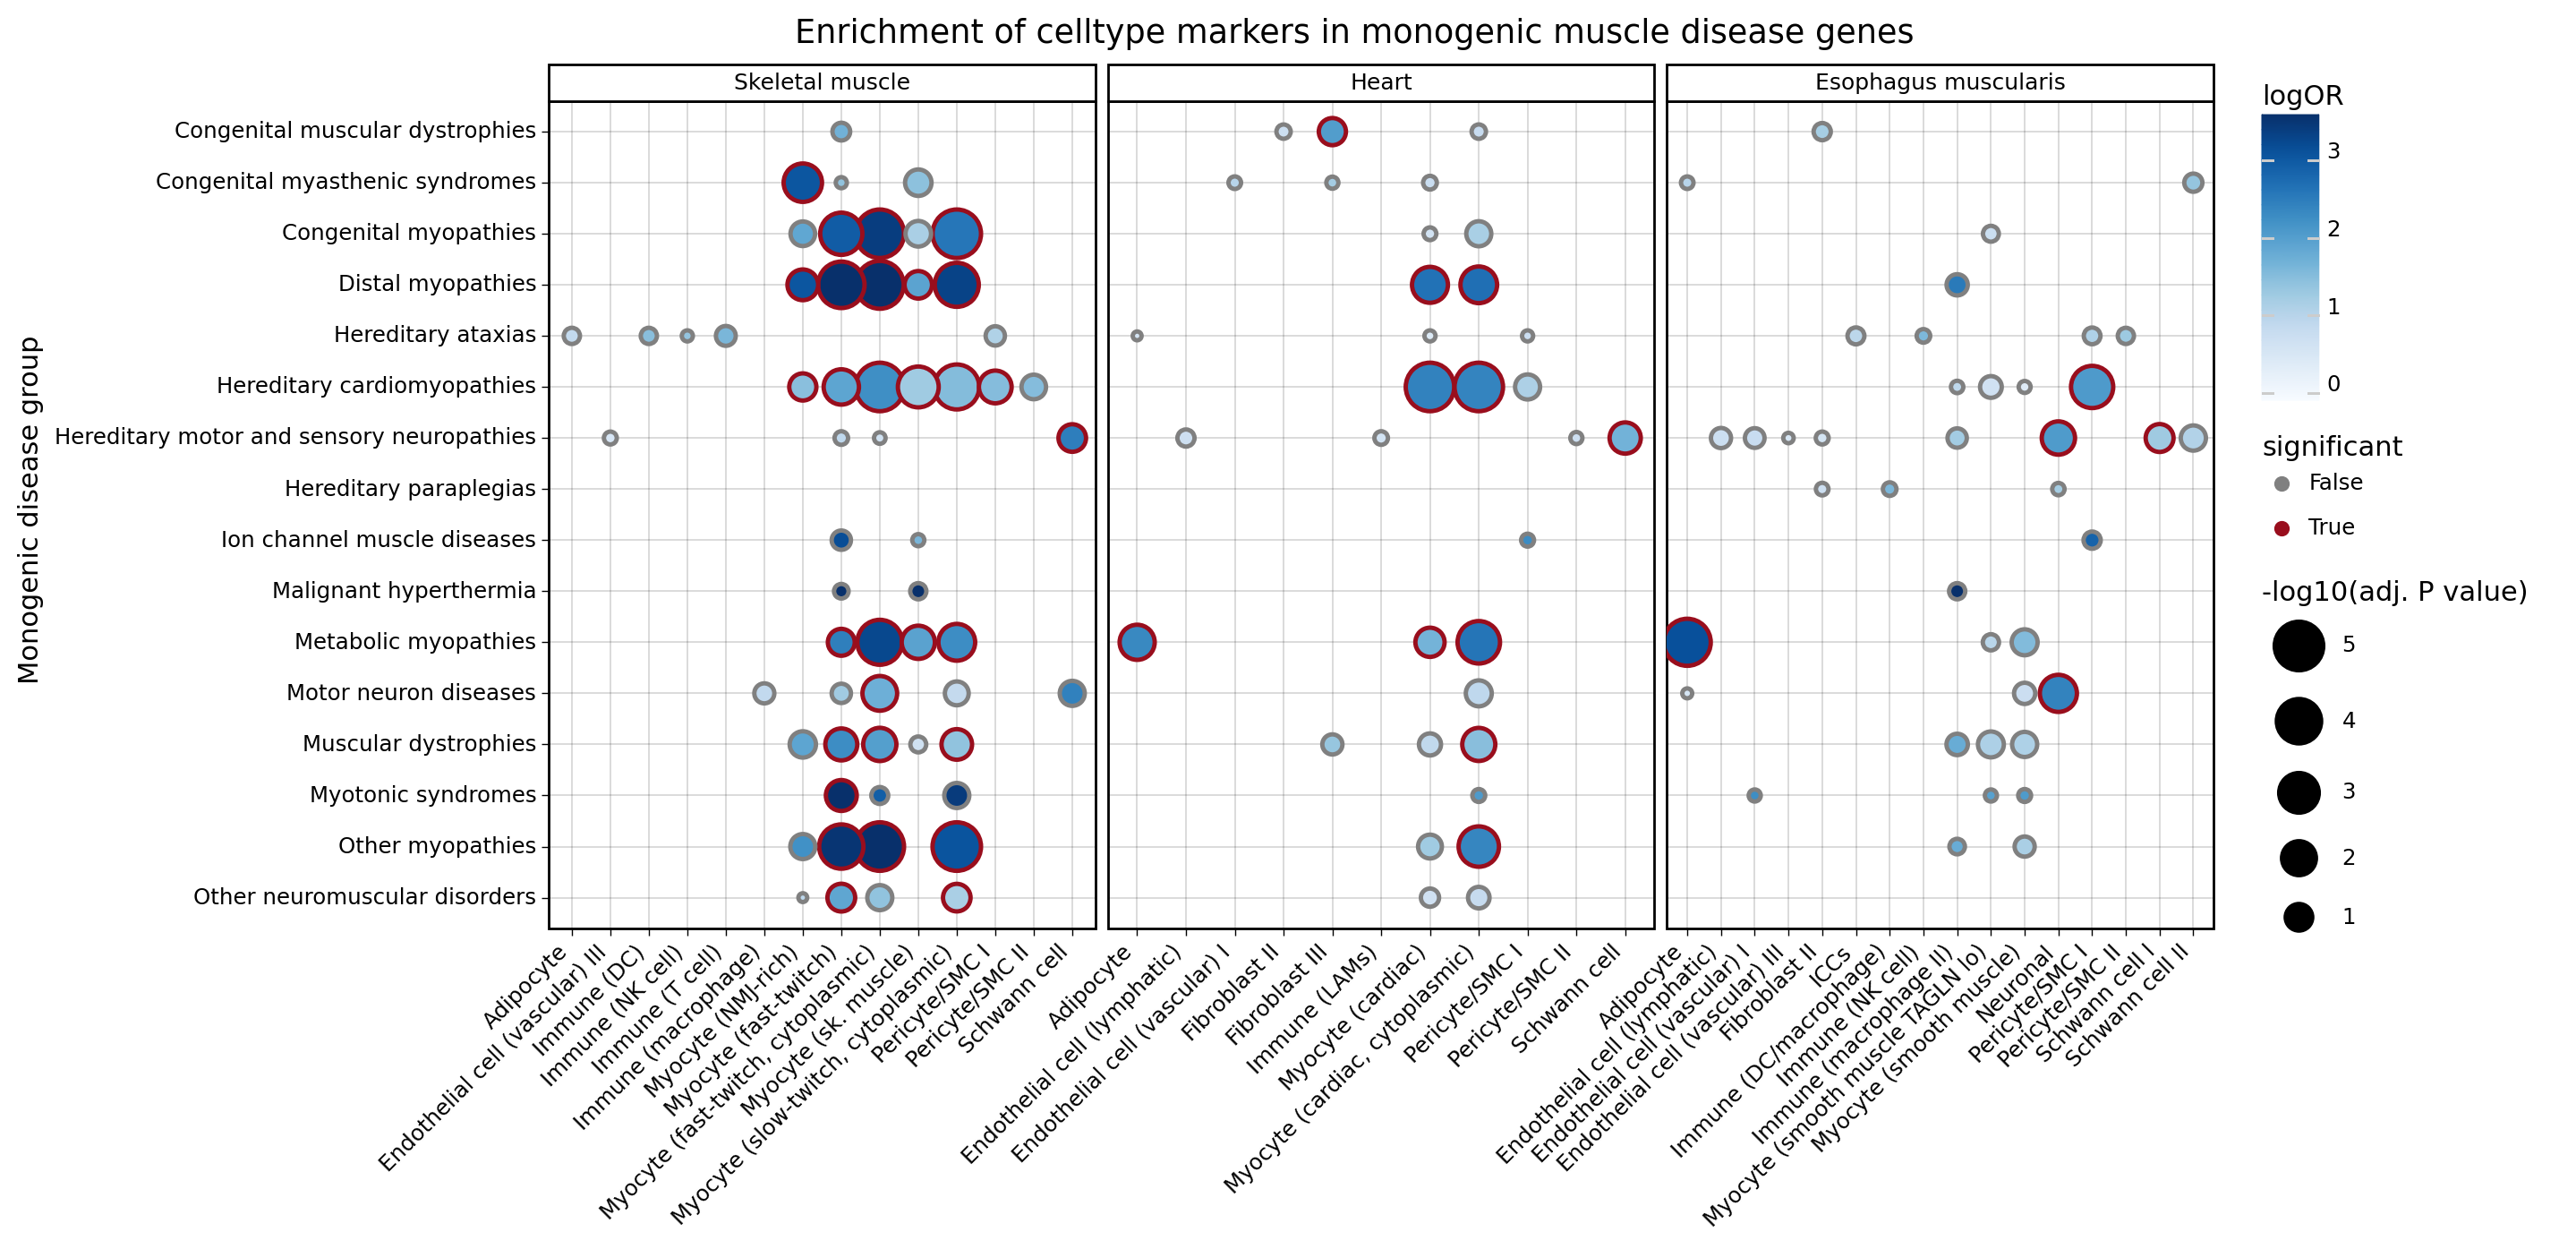

In [57]:
from plotnine import *

or_limit = 3.5
df.loc[df.logOR < -or_limit, 'logOR'] = -or_limit
df.loc[df.logOR > or_limit, 'logOR'] = or_limit
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5
df.loc[df.neglog_pval_adj == 0, 'neglog_pval_adj'] = np.nan

df['Disease group'] = pd.Categorical(df['Disease group'], categories=sorted(df['Disease group'].unique())[::-1])
df['tissue'] = pd.Categorical(df['tissue'], categories=['Skeletal muscle', 'Heart', 'Esophagus muscularis'])

limit = max(df.logOR.abs()) * np.array([-1, 1])

g = (
    ggplot(aes(x='celltype', y='Disease group'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='logOR', color='significant'), stroke=1)+
    facet_wrap('tissue', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
    scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Monogenic disease group', x='', title='Enrichment of celltype markers in monogenic muscle disease genes') +
    guides(size = guide_legend(reverse=True)) +
    theme_linedraw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=9, color='black', angle = 0),
     strip_text_y = element_text(size=9, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      figure_size=(12,6),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)
print(g)

## Fisher test for disease granular group enrichments

In [58]:
background = sorted(list(set(sorted(de[de.significant].gene.unique()) + muscle_diseases.Gene.unique().tolist())))

In [59]:
fisher_df = pd.DataFrame(dict(background=background))
fisher_df.head()

background
0         78
1       A1BG
2       A1CF
3        A2M
4      A2ML1

In [60]:
for disease in sorted(muscle_diseases['Disease group subgroup'].unique()):
    fisher_df[disease] = False
    disease_genes = muscle_diseases[muscle_diseases['Disease group subgroup'] == disease].Gene.unique()
    fisher_df[disease].loc[fisher_df.background.isin(disease_genes)] = True

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
for tc in sorted(de['tissue-celltype'].unique()):
    fisher_df[tc] = False
    de_genes = de[(de['tissue-celltype'] == tc) & (de.significant)].gene.unique().tolist()
    fisher_df[tc].loc[fisher_df.background.isin(de_genes)] = True

In [62]:
fisher_pval = pd.DataFrame(1, index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de['tissue-celltype'].unique()))
fisher_logodds = pd.DataFrame(0, index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de['tissue-celltype'].unique()))
fisher_intersections = pd.DataFrame(index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de['tissue-celltype'].unique()))

from fisher import pvalue
from statsmodels.stats.multitest import multipletests

for disease in tqdm(sorted(muscle_diseases['Disease group subgroup'].unique())):
    for tc in sorted(de['tissue-celltype'].unique()):
        m = pd.crosstab(fisher_df[disease], fisher_df[tc])
        try:
            a = m.loc[True, True]
        except KeyError:
            a = 0
        try:
            b = m.loc[True, False]
        except KeyError:
            b = 0
        try:
            c = m.loc[False, True]
        except KeyError:
            c = 0        
        try:
            d = m.loc[False, False]
        except KeyError:
            d = 0

        with np.errstate(invalid='ignore', divide='ignore'):
            fisher_logodds.loc[disease, tc] = np.log2((a*d) / (b*c))
        fisher_pval.loc[disease, tc] = pvalue(a, b, c, d).right_tail
        ints = tuple(fisher_df.background[fisher_df[disease] & fisher_df[tc]].tolist())
        fisher_intersections.loc[disease, tc] = ints

fdr = multipletests(fisher_pval.values.flatten(), method='fdr_bh')[1]
fisher_pval = pd.DataFrame(fdr.reshape(fisher_pval.shape), index=sorted(muscle_diseases['Disease group subgroup'].unique()), columns=sorted(de['tissue-celltype'].unique()))

fisher_result_subgroup = fisher_pval.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='pval_fdr').rename(columns={'index': 'Disease group subgroup'})
fisher_result_subgroup['logOR'] = fisher_logodds.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='logOR').logOR
fisher_result_subgroup['significant'] = (fisher_result_subgroup.pval_fdr < 0.1) & (fisher_result_subgroup.logOR>0)
fisher_result_subgroup['neglog_pval_adj'] = -np.log10(fisher_result_subgroup.pval_fdr.tolist())
fisher_result_subgroup['tissue'] = [x.split('|')[0] for x in fisher_result_subgroup['tissue-celltype']]
fisher_result_subgroup['celltype'] = [x.split('|')[1] for x in fisher_result_subgroup['tissue-celltype']]
fisher_result_subgroup['intersection'] = fisher_intersections.reset_index().melt(id_vars='index', var_name='tissue-celltype', value_name='intersection').intersection
fisher_result_subgroup['intersection_size'] = [len(x) for x in fisher_result_subgroup['intersection']]
fisher_result_subgroup['intersection'] = [','.join(x) for x in fisher_result_subgroup['intersection']]
fisher_result_subgroup = fisher_result_subgroup.sort_values('pval_fdr').reset_index(drop=True)
fisher_result_subgroup

  0%|          | 0/63 [00:00<?, ?it/s]

Disease group subgroup  \
0                                         Hereditary cardiomyopathies (Non-arrhythmogenic cardiomyopathies)   
1                                         Hereditary cardiomyopathies (Non-arrhythmogenic cardiomyopathies)   
2                                         Hereditary cardiomyopathies (Non-arrhythmogenic cardiomyopathies)   
3                       Hereditary cardiomyopathies (Arrhythmogenic cardiomyopathies and related syndromes)   
4                                                                                          Other myopathies   
...                                                                                                     ...   
4153                                                          Ion channel muscle diseases (Calcium channel)   
4154                                                         Ion channel muscle diseases (Chloride channel)   
4155                                                        Ion channel muscle diseases (Potassium channel)   
4156                                                         Other neuromuscular disorders (Arthrogryposis)   
4157  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   

                                         tissue-celltype      pval_fdr  \
0                   Heart|Myocyte (cardiac, cytoplasmic)  9.890711e-08   
1                                Heart|Myocyte (cardiac)  2.680981e-07   
2     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  2.621112e-06   
3                                Heart|Myocyte (cardiac)  4.710973e-06   
4     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  2.036023e-05   
...                                                  ...           ...   
4153                Esophagus muscularis|Schwann cell II  1.000000e+00   
4154                Esophagus muscularis|Schwann cell II  1.000000e+00   
4155                Esophagus muscularis|Schwann cell II  1.000000e+00   
4156                Esophagus muscularis|Pericyte/SMC II  1.000000e+00   
4157                        Skeletal muscle|Schwann cell  1.000000e+00   

         logOR  significant  neglog_pval_adj                tissue  \
0     2.467853         True         7.004772                 Heart   
1     2.355839         True         6.571706                 Heart   
2     2.728953         True         5.581514       Skeletal muscle   
3     2.579015         True         5.326889                 Heart   
4     4.209884         True         4.691217       Skeletal muscle   
...        ...          ...              ...                   ...   
4153      -inf        False        -0.000000  Esophagus muscularis   
4154      -inf        False        -0.000000  Esophagus muscularis   
4155      -inf        False        -0.000000  Esophagus muscularis   
4156      -inf        False        -0.000000  Esophagus muscularis   
4157      -inf        False        -0.000000       Skeletal muscle   

                                celltype  \
0         Myocyte (cardiac, cytoplasmic)   
1                      Myocyte (cardiac)   
2     Myocyte (fast-twitch, cytoplasmic)   
3                      Myocyte (cardiac)   
4     Myocyte (fast-twitch, cytoplasmic)   
...                                  ...   
4153                     Schwann cell II   
4154                     Schwann cell II   
4155                     Schwann cell II   
4156                     Pericyte/SMC II   
4157                        Schwann cell   

                                                                                                                                                                                                                                  intersection  \
0                                       ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CAV3,CRYAB,CSRP3,DES,DOLK,DSG2,FLNC,ILK,JPH2,LDB3,LMNA,MURC,MYBPC3,MYH6,MYH7,MYL2,MYL3,MYOZ2,NDUFAF1,NEXN,PLN,PSEN2,SCN5A,SCO2,SDHA,TCAP,TNNC1,TNNI3,TNNT2,TPM1,TSFM,TTN   
1     ABC

In [63]:
fisher_result

Disease group  \
0       Hereditary cardiomyopathies   
1       Hereditary cardiomyopathies   
2             Congenital myopathies   
3                  Other myopathies   
4       Hereditary cardiomyopathies   
...                             ...   
1049             Myotonic syndromes   
1050               Other myopathies   
1051  Other neuromuscular disorders   
1054          Congenital myopathies   
1055  Other neuromuscular disorders   

                                         tissue-celltype      pval_fdr  \
0                                Heart|Myocyte (cardiac)  1.162401e-13   
1                   Heart|Myocyte (cardiac, cytoplasmic)  1.856464e-13   
2     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  3.106813e-08   
3     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  3.241838e-08   
4     Skeletal muscle|Myocyte (fast-twitch, cytoplasmic)  1.491862e-06   
...                                                  ...           ...   
1049                                     Heart|Adipocyte  1.000000e+00   
1050                                     Heart|Adipocyte  1.000000e+00   
1051                                     Heart|Adipocyte  1.000000e+00   
1054                                     Heart|Adipocyte  1.000000e+00   
1055                        Skeletal muscle|Schwann cell  1.000000e+00   

         logOR  significant  neglog_pval_adj           tissue  \
0     2.396357         True        12.934644            Heart   
1     2.377021         True        12.731313            Heart   
2     3.312758         True         7.507685  Skeletal muscle   
3     3.801317         True         7.489209  Skeletal muscle   
4     2.224699         True         5.826271  Skeletal muscle   
...        ...          ...              ...              ...   
1049      -inf        False        -0.000000            Heart   
1050 -0.221155        False        -0.000000            Heart   
1051 -0.932080        False        -0.000000            Heart   
1054 -2.461494        False        -0.000000            Heart   
1055      -inf        False        -0.000000  Skeletal muscle   

                                celltype  \
0                      Myocyte (cardiac)   
1         Myocyte (cardiac, cytoplasmic)   
2     Myocyte (fast-twitch, cytoplasmic)   
3     Myocyte (fast-twitch, cytoplasmic)   
4     Myocyte (fast-twitch, cytoplasmic)   
...                                  ...   
1049                           Adipocyte   
1050                           Adipocyte   
1051                           Adipocyte   
1054                           Adipocyte   
1055                        Schwann cell   

                                                                                                                                                                                                                                                                                                                                                                                                intersection  \
0     ABCC9,ACTC1,ACTN2,AKAP9,ALPK3,ANK2,ANKRD1,BAG3,CACNA1C,CACNB2,CASQ2,CAV3,CTNNA3,DMD,DSC2,DSG2,DSP,DTNA,EYA4,FKTN,FLNA,FLNC,GATAD1,GPD1L,HACD1,HCN4,JPH2,JUP,KCND3,KCNE2,KCNH2,KCNJ2,KCNJ5,KCNQ1,LAMA4,LDB3,MIB1,MTO1,MURC,MYBPC3,MYH6,MYH7,MYL2,MYL4,MYOZ2,MYPN,NDUFAF1,NEXN,PKP2,PLN,PRDM16,PRKAG2,RAF1,RBM20,RYR2,SCN2B,SCN5A,SDHA,SGCD,SNTA1,TAZ,TECRL,TMEM168,TMEM43,TNNI3,TNNT2,TPM1,TRDN,TTN,VCL   
1                                                                                 ACTC1,ACTN2,ALPK3,ANKRD1,BAG3,CALM1,CALM2,CALM3,CASQ2,CAV3,CRYAB,CSRP3,DES,DOLK,DSC2,DSG2,DSP,FLNC,GPD1L,HACD1,HCN4,ILK,JPH2,JUP,KCNH2,KCNJ2,LDB3,LMNA,MURC,MYBPC3,MYH6,MYH7,MYL2,MYL3,MYL4,MYOZ2,NDUFAF1,NEXN,NPPA,PKP2,PLN,PSEN2,SCN1B,SCN2B,SCN5A,SCO2,SDHA,SNTA1,TCAP,TECRL,TGFB3,TNNC1,TNNI3,TNNT2,TPM1,TRDN,TSFM,TTN   
2                                                                                                                                                         

In [64]:
fisher_result_combined = pd.concat([fisher_result, fisher_result_subgroup.rename(columns={'Disease group subgroup': 'Disease group'})], axis=0).reset_index(drop=True)

In [65]:
fisher_result_combined = fisher_result_combined.loc[fisher_result_combined.groupby(['Disease group', 'tissue-celltype'])['pval_fdr'].idxmin()].reset_index(drop=True)

## Plot combined plot

In [66]:
df = fisher_result_combined.copy()

In [67]:
fisher_result_combined[fisher_result_combined.celltype == 'Endothelial cell (cardiac microvascular)'].sort_values('pval_fdr')

Disease group  \
24                                                                          Congenital muscular dystrophies   
2366                                                   Metabolic myopathies (Disorders of lipid metabolism)   
2432                                                       Metabolic myopathies (Glycogen storage diseases)   
2498                                                              Metabolic myopathies (Glycolytic pathway)   
2564                                                                                  Motor neuron diseases   
...                                                                                                     ...   
1822                                       Hereditary paraplegias (Spastic paraplegias, autosomal dominant)   
1888                                      Hereditary paraplegias (Spastic paraplegias, autosomal recessive)   
1995                                                          Ion channel muscle diseases (Calcium channel)   
1014                                                                 Hereditary ataxias (Friedreich ataxia)   
4280  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   

                                     tissue-celltype  pval_fdr     logOR  \
24    Heart|Endothelial cell (cardiac microvascular)       1.0  1.139746   
2366  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
2432  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
2498  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
2564  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
...                                              ...       ...       ...   
1822  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
1888  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
1995  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
1014  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   
4280  Heart|Endothelial cell (cardiac microvascular)       1.0      -inf   

      significant  neglog_pval_adj tissue  \
24          False             -0.0  Heart   
2366        False             -0.0  Heart   
2432        False             -0.0  Heart   
2498        False             -0.0  Heart   
2564        False             -0.0  Heart   
...           ...              ...    ...   
1822        False             -0.0  Heart   
1888        False             -0.0  Heart   
1995        False             -0.0  Heart   
1014        False             -0.0  Heart   
4280        False             -0.0  Heart   

                                      celltype intersection  intersection_size  
24    Endothelial cell (cardiac microvascular)         LMNA                  1  
2366  Endothelial cell (cardiac microvascular)                               0  
2432  Endothelial cell (cardiac microvascular)                               0  
2498  Endothelial cell (cardiac microvascular)                               0  
2564  Endothelial cell (cardiac microvascular)                               0  
...                                        ...          ...                ...  
1822  Endothelial cell (cardiac microvascular)                               0  
1888  Endothelial cell (cardiac microvascular)                               0  
1995  Endothelial cell (cardiac microvascular)                               0  
1014  Endothelial cell (cardiac microvascular)                               0  
4280  Endothelial cell (cardiac microvascular)                               0  

[63 rows x 10 columns]

In [68]:
fisher_result_combined[fisher_result_combined.celltype.str.contains('Immune')].sort_values('pval_fdr')

Disease group  \
3763                                                          Other myopathies (Tubular aggregate myopathy)   
2990                                                        Motor neuron diseases (Spinal muscular atrophy)   
3186                                                                            Muscular dystrophies (EDMD)   
3016                                                                                   Muscular dystrophies   
740                                                                                       Distal myopathies   
...                                                                                                     ...   
1442                    Hereditary motor and sensory neuropathies (Dejerine-Sottas hypertrophic neuropathy)   
1441                    Hereditary motor and sensory neuropathies (Dejerine-Sottas hypertrophic neuropathy)   
1440                    Hereditary motor and sensory neuropathies (Dejerine-Sottas hypertrophic neuropathy)   
1464                    Hereditary motor and sensory neuropathies (Dejerine-Sottas hypertrophic neuropathy)   
4312  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   

                                  tissue-celltype  pval_fdr     logOR  \
3763                       Heart|Immune (NK cell)  0.211556       inf   
2990          Skeletal muscle|Immune (macrophage)  0.234334  1.957774   
3186             Skeletal muscle|Immune (NK cell)  0.235644  4.985575   
3016  Esophagus muscularis|Immune (macrophage II)  0.313792  1.778164   
740   Esophagus muscularis|Immune (macrophage II)  0.324050  2.505073   
...                                           ...       ...       ...   
1442      Esophagus muscularis|Immune (mast cell)  1.000000      -inf   
1441  Esophagus muscularis|Immune (macrophage II)  1.000000      -inf   
1440   Esophagus muscularis|Immune (macrophage I)  1.000000  0.998506   
1464                  Heart|Immune (macrophage I)  1.000000  1.192825   
4312          Skeletal muscle|Immune (neutrophil)  1.000000      -inf   

      significant  neglog_pval_adj                tissue  \
3763        False         0.674575                 Heart   
2990        False         0.630165       Skeletal muscle   
3186        False         0.627743       Skeletal muscle   
3016        False         0.503358  Esophagus muscularis   
740         False         0.489388  Esophagus muscularis   
...           ...              ...                   ...   
1442        False        -0.000000  Esophagus muscularis   
1441        False        -0.000000  Esophagus muscularis   
1440        False        -0.000000  Esophagus muscularis   
1464        False        -0.000000                 Heart   
4312        False        -0.000000       Skeletal muscle   

                    celltype  \
3763        Immune (NK cell)   
2990     Immune (macrophage)   
3186        Immune (NK cell)   
3016  Immune (macrophage II)   
740   Immune (macrophage II)   
...                      ...   
1442      Immune (mast cell)   
1441  Immune (macrophage II)   
1440   Immune (macrophage I)   
1464   Immune (macrophage I)   
4312     Immune (neutrophil)   

                                            intersection  intersection_size  
3763                                         ORAI1,STIM1                  2  
2990  ASAH1,BICD2,HEXB,PLEKHG5,SLC25A46,TRIP4,TRPV4,VRK1                  8  
3186                                         SYNE1,SYNE2                  2  
3016                          DNAJB6,GAA,LMNA,SMCHD1,TTN                  5  
740                                    DNAJB6,SQSTM1,TTN                  3  
...                                                  ...                ...  
1442                                                                      0  
1441                                                                      0  
1440                                               PMP22                  1 

sig_tc = (df.groupby('tissue-celltype')['significant'].count() != df.groupby('tissue-celltype')['pval_fdr'].sum())
sig_tc = sig_tc[sig_tc].index.tolist()
df = df[df['tissue-celltype'].isin(sig_tc)]

sig_disease = (df.groupby('Disease group')['significant'].count() != df.groupby('Disease group')['pval_fdr'].sum())
sig_disease = sig_disease[sig_disease].index.tolist()
df = df[df['Disease group'].isin(sig_disease)]

In [69]:
sig_tc = (df.groupby('tissue-celltype')['significant'].sum() > 0)
sig_tc = sig_tc[sig_tc].index.tolist()
df = df[df['tissue-celltype'].isin(sig_tc)]

sig_disease = (df.groupby('Disease group')['significant'].sum() > 0)
sig_disease = sig_disease[sig_disease].index.tolist()
df = df[df['Disease group'].isin(sig_disease)]

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 7 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/figure-4a.pdf
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 366 rows containing missing values.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 366 rows containing missing values.


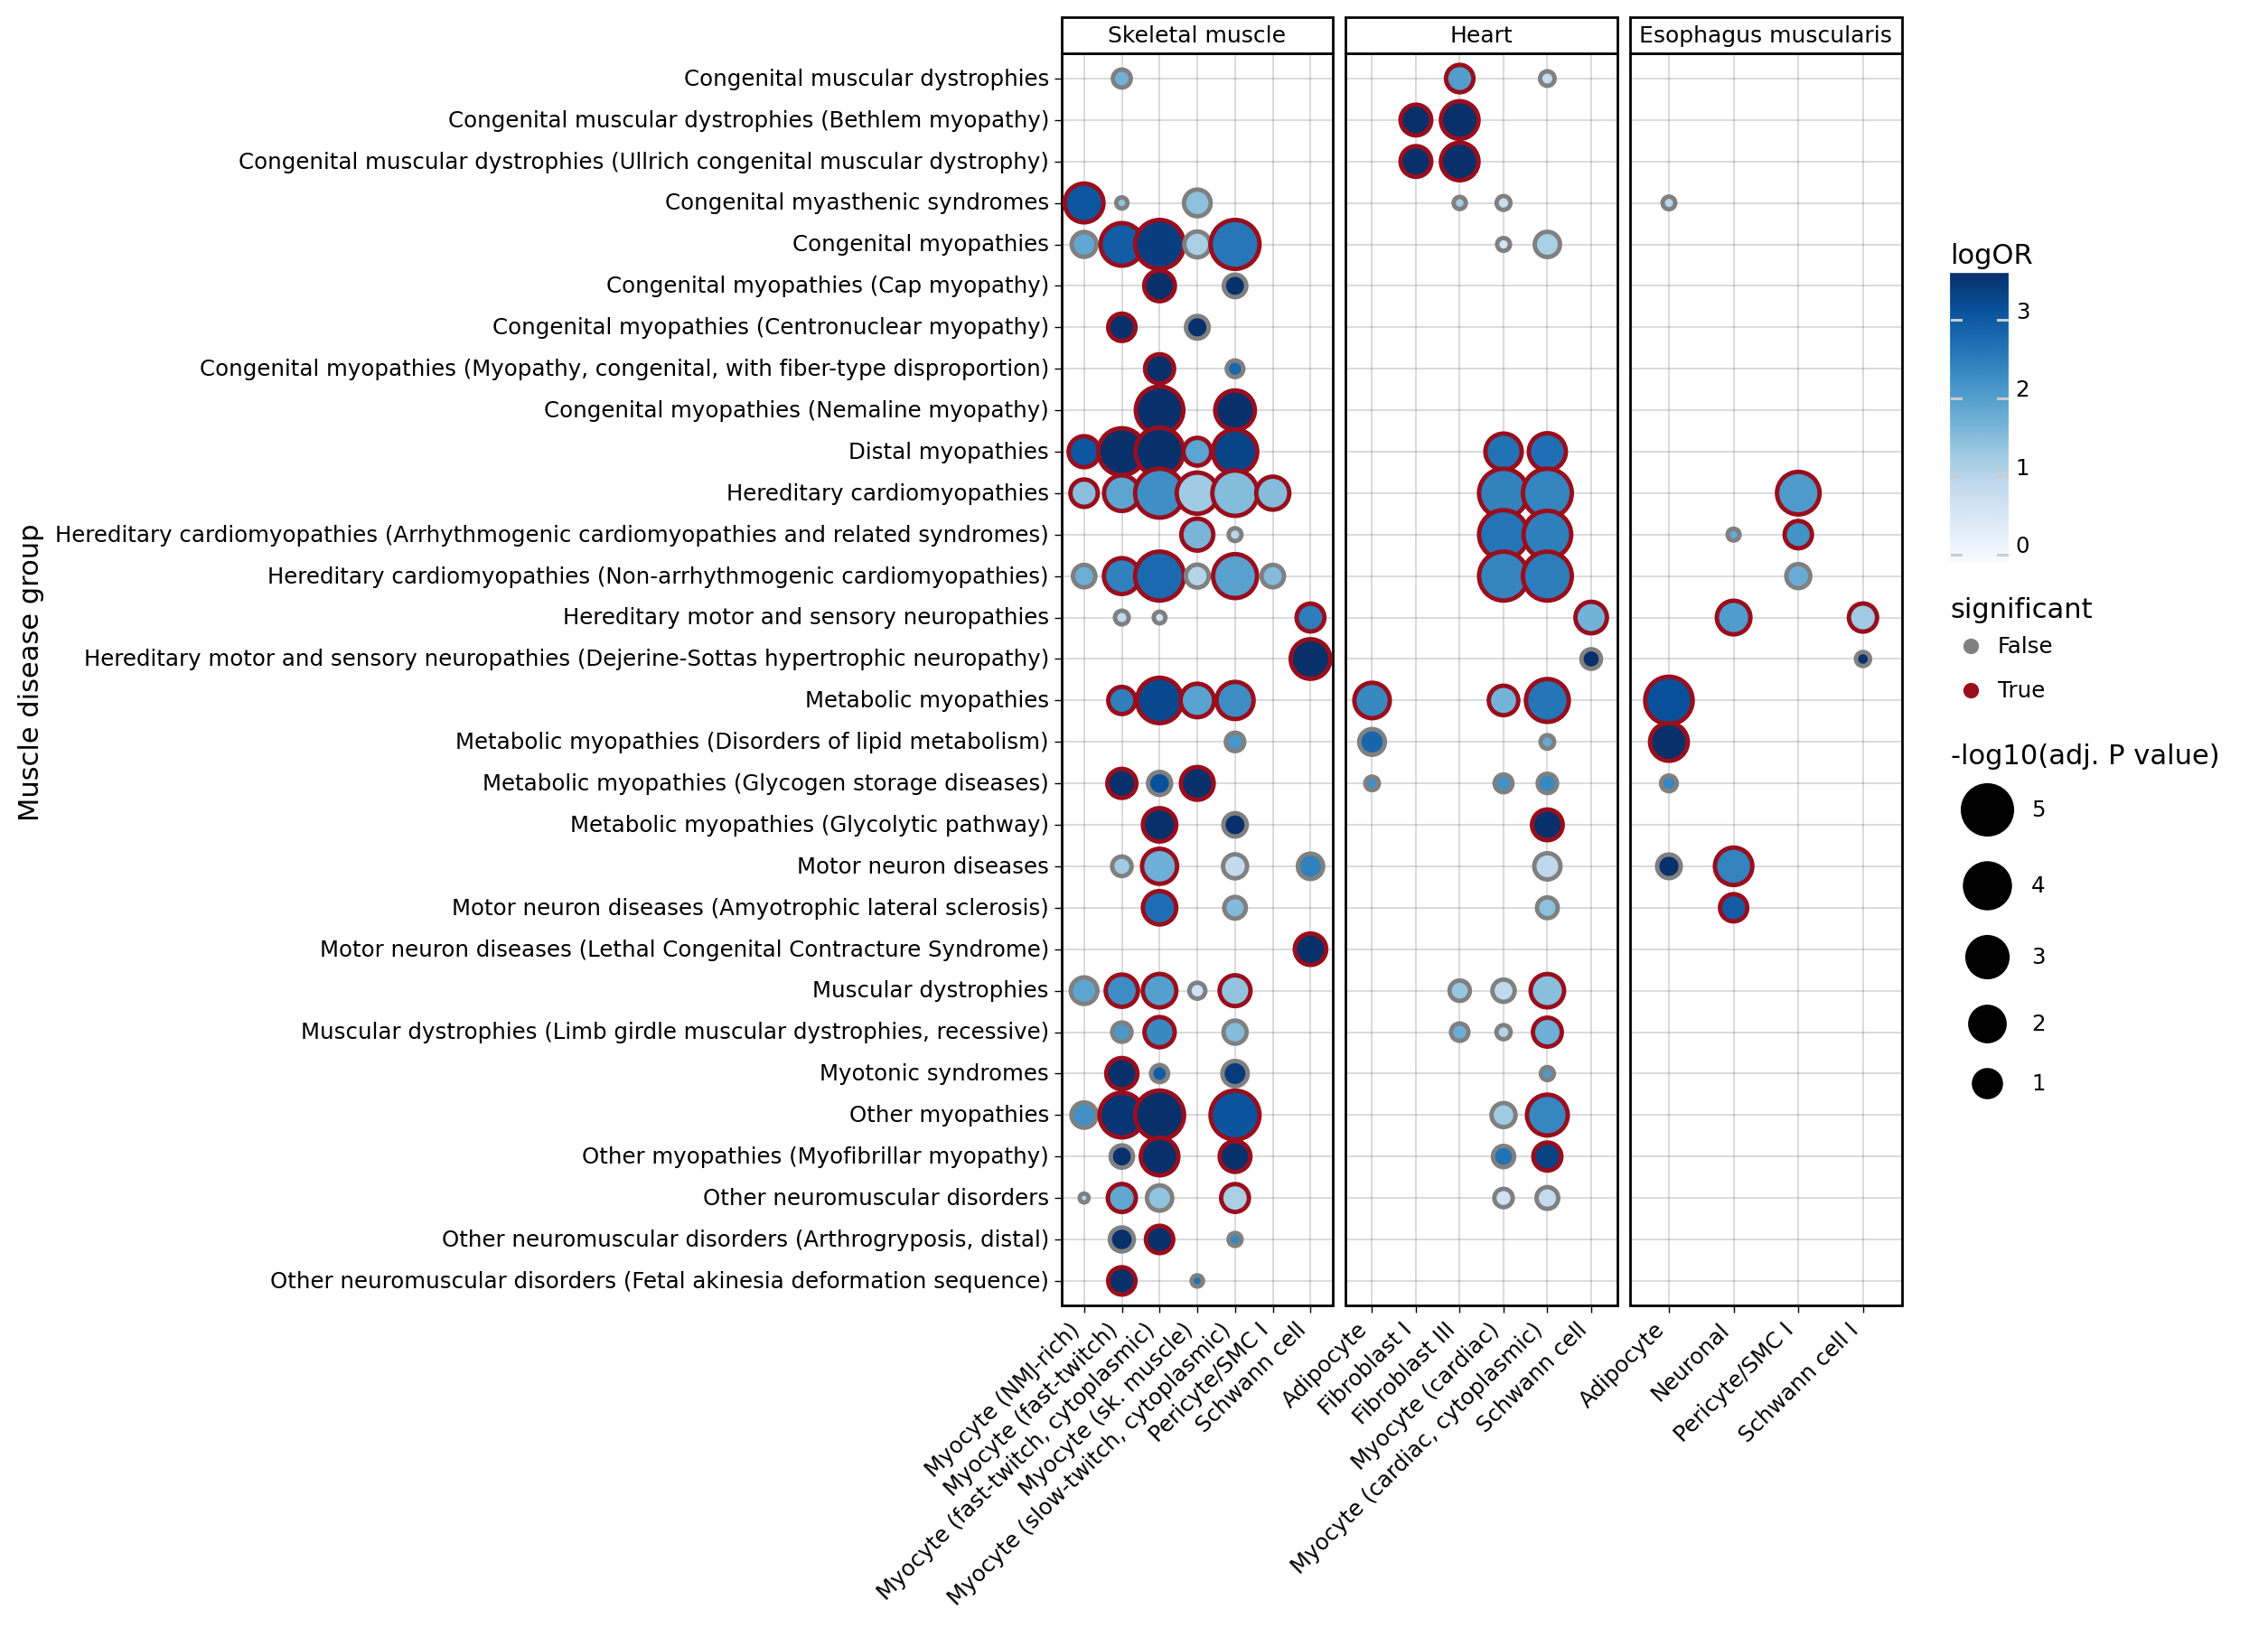

In [70]:
from plotnine import *

or_limit = 3.5
df.loc[df.logOR < -or_limit, 'logOR'] = -or_limit
df.loc[df.logOR > or_limit, 'logOR'] = or_limit
df.loc[df.neglog_pval_adj > 5, 'neglog_pval_adj'] = 5
df.loc[df.neglog_pval_adj == 0, 'neglog_pval_adj'] = np.nan

df['Disease group'] = pd.Categorical(df['Disease group'], categories=sorted(df['Disease group'].unique())[::-1])
df['tissue'] = pd.Categorical(df['tissue'], categories=['Skeletal muscle', 'Heart', 'Esophagus muscularis'])

limit = max(df.logOR.abs()) * np.array([-1, 1])

g = (
    ggplot(aes(x='celltype', y='Disease group'), data=df) +
    geom_point(aes(size='neglog_pval_adj', fill='logOR', color='significant'), stroke=1)+
    facet_wrap('tissue', nrow=1, scales='free_x') + 
    #scale_fill_distiller(type='div', limits=limit, name='log(odds ratio)') + 
    scale_fill_cmap('Blues', limits=[0, None]) +
    scale_color_manual(values=('#808080', '#990E1D')) + 
    labs(size = "-log10(adj. P value)", y='Muscle disease group', x='', title='') +
    guides(size = guide_legend(reverse=True)) +
    theme_linedraw() +
    scale_size(range = (1,10)) +
    scale_y_discrete(drop=False) +
    #scale_x_discrete(drop=False) +
    theme(
     strip_text_x = element_text(size=9, color='black', angle = 0),
     strip_text_y = element_text(size=9, color='black', angle = 0),      
     strip_background=element_rect(color='black', fill='white'),
      figure_size=(6,9),
      legend_key=element_blank(),
      axis_text_x = element_text(rotation=45, hjust=1.),
    )
)
ggsave(g, sc.settings.figdir / 'figure-4a.pdf', width=6, height=7)
print(g)

In [71]:
pd.options.display.max_colwidth = None

In [72]:
fisher_result_combined

Disease group  \
0                                                                           Congenital muscular dystrophies   
1                                                                           Congenital muscular dystrophies   
2                                                                           Congenital muscular dystrophies   
3                                                                           Congenital muscular dystrophies   
4                                                                           Congenital muscular dystrophies   
...                                                                                                     ...   
4317  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   
4318  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   
4319  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   
4320  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   
4321  Other neuromuscular disorders (Progressive external ophthalmoplegia with mitochondrial DNA deletions)   

                                           tissue-celltype  pval_fdr  \
0                           Esophagus muscularis|Adipocyte       1.0   
1        Esophagus muscularis|Endothelial cell (lymphatic)       1.0   
2       Esophagus muscularis|Endothelial cell (vascular) I       1.0   
3      Esophagus muscularis|Endothelial cell (vascular) II       1.0   
4     Esophagus muscularis|Endothelial cell (vascular) III       1.0   
...                                                    ...       ...   
4317    Skeletal muscle|Myocyte (slow-twitch, cytoplasmic)       1.0   
4318                        Skeletal muscle|Pericyte/SMC I       1.0   
4319                       Skeletal muscle|Pericyte/SMC II       1.0   
4320                        Skeletal muscle|Satellite cell       1.0   
4321                          Skeletal muscle|Schwann cell       1.0   

         logOR  significant  neglog_pval_adj                tissue  \
0     0.523353        False             -0.0  Esophagus muscularis   
1    -0.670945        False             -0.0  Esophagus muscularis   
2    -1.893069        False             -0.0  Esophagus muscularis   
3     0.948073        False             -0.0  Esophagus muscularis   
4    -1.791962        False             -0.0  Esophagus muscularis   
...        ...          ...              ...                   ...   
4317  1.760484        False             -0.0       Skeletal muscle   
4318      -inf        False             -0.0       Skeletal muscle   
4319      -inf        False             -0.0       Skeletal muscle   
4320      -inf        False             -0.0       Skeletal muscle   
4321      -inf        False             -0.0       Skeletal muscle   

                                celltype                        intersection  \
0                              Adipocyte  B3GALNT2,INPP5K,ITGA7,LMNA,POMGNT1   
1           Endothelial cell (lymphatic)                      DNM2,FKTN,LMNA   
2          Endothelial cell (vascular) I                                DNM2   
3         Endothelial cell (vascular) II                                TCAP   
4        Endothelial cell (vascular) III                              INPP5K   
...                                  ...                                 ...   
4317  Myocyte (slow-twitch, cytoplasmic)            DGUOK,POLG,RRM2B,SLC25A4   
4318                      Pericyte/SMC I                                       
4319                     Pericyte/SMC II                                       
4320                      Satellite cell                                       
4321                        Schwann cell                                       

      intersection_size  
0                     5  
1                     3  
2               

## Merge with muscle disease gene list

In [73]:
de = de.merge(muscle_diseases, left_on='gene', right_on='Gene', how='inner')

In [74]:
de['tissue_celltype'] = de['tissue'].astype(str) + '|' + de.celltype.astype(str)
de['tissue'] = pd.Categorical(de.tissue, categories=['Skeletal muscle', 'Heart', 'Esophagus muscularis'])

de.head()

celltype    gene      tstat          pvals  \
0                        Adipocyte  SLC1A3  22.605383   1.045569e-52   
1     Endothelial cell (lymphatic)  SLC1A3 -16.008574   1.903865e-54   
2    Endothelial cell (vascular) I  SLC1A3 -31.075413  3.733239e-206   
3   Endothelial cell (vascular) II  SLC1A3 -19.380472   4.447508e-76   
4  Endothelial cell (vascular) III  SLC1A3  -9.496008   1.382338e-20   

       pvals_fdr    log2FC  fraction_group  fraction_rest  mean_expressed  \
0   1.483734e-51  6.341252        0.898810       0.034083        1.318259   
1   4.904648e-53 -3.561511        0.003306       0.039620        0.895880   
2  3.157226e-204 -5.357486        0.001249       0.040157        0.693147   
3   1.498461e-74 -4.733961        0.001186       0.039274        1.098612   
4   1.523848e-19 -1.828008        0.013237       0.038960        0.730008   

   spring_score  ...    Gene   Item  \
0      5.345250  ...  SLC1A3  13.48   
1     -0.178490  ...  SLC1A3  13.48   
2     -0.195570  ...  SLC1A3  13.48   
3     -0.186802  ...  SLC1A3  13.48   
4     -0.149341  ...  SLC1A3  13.48   

                                  Gene symbol (chromosome) protein  \
0  SLC1A3 (5p13)  EAAT1 (excitatory amino acid transporter type 1)   
1  SLC1A3 (5p13)  EAAT1 (excitatory amino acid transporter type 1)   
2  SLC1A3 (5p13)  EAAT1 (excitatory amino acid transporter type 1)   
3  SLC1A3 (5p13)  EAAT1 (excitatory amino acid transporter type 1)   
4  SLC1A3 (5p13)  EAAT1 (excitatory amino acid transporter type 1)   

                 Disease group subgroup  \
0  Hereditary ataxias (Episodic ataxia)   
1  Hereditary ataxias (Episodic ataxia)   
2  Hereditary ataxias (Episodic ataxia)   
3  Hereditary ataxias (Episodic ataxia)   
4  Hereditary ataxias (Episodic ataxia)   

                                                                disease_id  \
0  Hereditary ataxias-Episodic ataxia-Episodic ataxia type-6 - (ad)-SLC1A3   
1  Hereditary ataxias-Episodic ataxia-Episodic ataxia type-6 - (ad)-SLC1A3   
2  Hereditary ataxias-Episodic ataxia-Episodic ataxia type-6 - (ad)-SLC1A3   
3  Hereditary ataxias-Episodic ataxia-Episodic ataxia type-6 - (ad)-SLC1A3   
4  Hereditary ataxias-Episodic ataxia-Episodic ataxia type-6 - (ad)-SLC1A3   

                          disease_cat                          disease_gene  \
0  Hereditary ataxias-Episodic ataxia  Episodic ataxia type-6 - (AD)-SLC1A3   
1  Hereditary ataxias-Episodic ataxia  Episodic ataxia type-6 - (AD)-SLC1A3   
2  Hereditary ataxias-Episodic ataxia  Episodic ataxia type-6 - (AD)-SLC1A3   
3  Hereditary ataxias-Episodic ataxia  Episodic ataxia type-6 - (AD)-SLC1A3   
4  Hereditary ataxias-Episodic ataxia  Episodic ataxia type-6 - (AD)-SLC1A3   

          disease_group_gene                  disease_group_subgroup_gene  \
0  Hereditary ataxias|SLC1A3  Hereditary ataxias (Episodic ataxia)|SLC1A3   
1  Hereditary ataxias|SLC1A3  Hereditary ataxias (Episodic ataxia)|SLC1A3   
2  Hereditary ataxias|SLC1A3  Hereditary ataxias (Episodic ataxia)|SLC1A3   
3  Hereditary ataxias|SLC1A3  Hereditary ataxias (Episodic ataxia)|SLC1A3   
4  Hereditary ataxias|SLC1A3  Hereditary ataxias (Episodic ataxia)|SLC1A3   

                                        tissue_celltype  
0                        Esophagus muscularis|Adipocyte  
1     Esophagus muscularis|Endothelial cell (lymphatic)  
2    Esophagus muscularis|Endothelial cell (vascular) I  
3   Esophagus muscularis|Endothelial cell (vascular) II  
4  Esophagus muscularis|Endothelial cell (vascular) III  

[5 rows x 27 columns]

In [75]:
de[(de.gene=='CACNA1A') & (de.celltype == 'Neuronal')]

celltype     gene     tstat     pvals  pvals_fdr    log2FC  \
14082  Neuronal  CACNA1A  0.341053  0.736028    0.79791  0.519282   
14083  Neuronal  CACNA1A  0.341053  0.736028    0.79791  0.519282   
14084  Neuronal  CACNA1A  0.341053  0.736028    0.79791  0.519282   
14085  Neuronal  CACNA1A  0.341053  0.736028    0.79791  0.519282   
14086  Neuronal  CACNA1A  0.341053  0.736028    0.79791  0.519282   

       fraction_group  fraction_rest  mean_expressed  spring_score  ...  \
14082            0.08       0.054732        0.693147      0.078839  ...   
14083            0.08       0.054732        0.693147      0.078839  ...   
14084            0.08       0.054732        0.693147      0.078839  ...   
14085            0.08       0.054732        0.693147      0.078839  ...   
14086            0.08       0.054732        0.693147      0.078839  ...   

          Gene   Item  \
14082  CACNA1A    7.9   
14083  CACNA1A   7.10   
14084  CACNA1A   13.6   
14085  CACNA1A  13.45   
14086  CACNA1A  13.50   

                                                         Gene symbol (chromosome) protein  \
14082  CACNA1A (19p13.13)  Calcium channel, voltage-dependent, P/Q type, alpha 1A subunit   
14083  CACNA1A (19p13.13)  Calcium channel, voltage-dependent, P/Q type, alpha 1A subunit   
14084  CACNA1A (19p13.13)  Calcium channel, voltage-dependent, P/Q type, alpha 1A subunit   
14085  CACNA1A (19p13.13)  Calcium channel, voltage-dependent, P/Q type, alpha 1A subunit   
14086  CACNA1A (19p13.13)  Calcium channel, voltage-dependent, P/Q type, alpha 1A subunit   

                              Disease group subgroup  \
14082  Ion channel muscle diseases (Calcium channel)   
14083  Ion channel muscle diseases (Calcium channel)   
14084    Hereditary ataxias (Spinocerebellar ataxia)   
14085           Hereditary ataxias (Episodic ataxia)   
14086                             Hereditary ataxias   

                                                                                                                        disease_id  \
14082  Ion channel muscle diseases-Calcium channel-Acetazolamide responsive hereditary paroxysmal cerebellar ataxia - (ad)-CACNA1A   
14083                                            Ion channel muscle diseases-Calcium channel-Episodic ataxia type-2 - (ad)-CACNA1A   
14084                                            Hereditary ataxias-Spinocerebellar ataxia-Spinocerebellar ataxia 6 - (ad)-CACNA1A   
14085                   Hereditary ataxias-Episodic ataxia-Episodic ataxia type-2 ,and familial hemiplegic migraine - (ad)-CACNA1A   
14086                           Hereditary ataxias-Acetazolamide responsive hereditary paroxysmal cerebellar ataxia - (ad)-CACNA1A   

                                       disease_cat  \
14082  Ion channel muscle diseases-Calcium channel   
14083  Ion channel muscle diseases-Calcium channel   
14084    Hereditary ataxias-Spinocerebellar ataxia   
14085           Hereditary ataxias-Episodic ataxia   
14086                           Hereditary ataxias   

                                                                          disease_gene  \
14082  Acetazolamide responsive hereditary paroxysmal cerebellar ataxia - (AD)-CACNA1A   
14083                                            Episodic ataxia type-2 - (AD)-CACNA1A   
14084                                          Spinocerebellar ataxia 6 - (AD)-CACNA1A   
14085          Episodic ataxia type-2 ,and familial hemiplegic migraine - (AD)-CACNA1A   
14086  Acetazolamide responsive hereditary paroxysmal cerebellar ataxia - (AD)-CACNA1A   

                        disease_group_gene  \
14082  Ion channel muscle diseases|CACNA1A   
14083  Ion channel muscle diseases|CACNA1A   
14084           Hereditary ataxias|CACNA1A   
14085           Hereditary ataxias|CACNA1A   
14086           Hereditary ataxias|CACNA1A   

                                 disease_group_subgroup_gene  \
14082  Ion channel muscle diseases (Calcium channel)|CACNA1A   
14083  Ion channel

In [76]:
de_broad = de_broad.merge(muscle_diseases, left_on='gene', right_on='Gene', how='inner')

## TF overlap

In [77]:
import dorothea

In [78]:
tfs = dorothea.load_regulons(['A', 'B', 'C', 'D', 'E'])

In [79]:
tfs

tf      ADNP  ADNP2  AEBP2  AHR  AHRR  AIRE  ALX1  ALX3  ALX4   AR  ...  \
target                                                              ...   
7SK.1    0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
A1BG     0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
A1CF     0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
A2M      0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
A2ML1    0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
...      ...    ...    ...  ...   ...   ...   ...   ...   ...  ...  ...   
ZYG11A   0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
ZYG11B   0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
ZYX      0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
ZZEF1    0.0    0.0    0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   
ZZZ3     0.0    0.0    1.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  ...   

tf      ZSCAN29  ZSCAN30  ZSCAN31  ZSCAN32  ZSCAN4  ZSCAN5A  ZSCAN9  ZXDA  \
target                                                                      
7SK.1       0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
A1BG        0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
A1CF        0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
A2M         0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
A2ML1       0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
...         ...      ...      ...      ...     ...      ...     ...   ...   
ZYG11A      0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
ZYG11B      0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
ZYX         0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
ZZEF1       0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   
ZZZ3        0.0      0.0      0.0      0.0     0.0      0.0     0.0   0.0   

tf      ZXDB  ZXDC  
target              
7SK.1    0.0   0.0  
A1BG     0.0   0.0  
A1CF     0.0   0.0  
A2M      0.0   0.0  
A2ML1    0.0   0.0  
...      ...   ...  
ZYG11A   0.0   0.0  
ZYG11B   0.0   0.0  
ZYX      0.0   0.0  
ZZEF1    0.0   1.0  
ZZZ3     0.0   0.0  

[20244 rows x 1395 columns]

In [80]:
tfs.columns[tfs.columns.isin(muscle_diseases.Gene)]

Index(['AR', 'DNMT1', 'DUX4', 'EGR2', 'GATAD1', 'HOXD10', 'NKX6-2', 'PAX7',
       'PHOX2A', 'PRDM16', 'TBP', 'ZBTB42', 'ZFHX2'],
      dtype='object', name='tf')

In [81]:
tfs.shape

(20244, 1395)

In [82]:
tf_de = de[de.significant & (de.log2FC>.5) & (de.fraction_group>.1) & (de.gene.isin(tfs.columns))].sort_values('pvals_fdr')

tf_de.gene.nunique()

3

In [83]:
', '.join(sorted(tf_de.gene.unique()))

'AR, PAX7, PRDM16'

In [84]:
tf_de[['celltype', 'tissue', 'gene', 'disease_id']].drop_duplicates().sort_values(['gene', 'celltype', 'tissue'])

celltype                tissue    gene  \
1892                         Adipocyte       Skeletal muscle      AR   
1871                         Adipocyte                 Heart      AR   
1848                         Adipocyte  Esophagus muscularis      AR   
1886                 Myocyte (cardiac)                 Heart      AR   
24528                   Satellite cell       Skeletal muscle    PAX7   
25552  Endothelial cell (vascular) III       Skeletal muscle  PRDM16   
25551  Endothelial cell (vascular) III       Skeletal muscle  PRDM16   
25509  Endothelial cell (vascular) III                 Heart  PRDM16   
25510  Endothelial cell (vascular) III                 Heart  PRDM16   
25463  Endothelial cell (vascular) III  Esophagus muscularis  PRDM16   
25464  Endothelial cell (vascular) III  Esophagus muscularis  PRDM16   
25531                Myocyte (cardiac)                 Heart  PRDM16   
25532                Myocyte (cardiac)                 Heart  PRDM16   
25578                   Pericyte/SMC I       Skeletal muscle  PRDM16   
25577                   Pericyte/SMC I       Skeletal muscle  PRDM16   
25536                   Pericyte/SMC I                 Heart  PRDM16   
25535                   Pericyte/SMC I                 Heart  PRDM16   
25493                   Pericyte/SMC I  Esophagus muscularis  PRDM16   
25494                   Pericyte/SMC I  Esophagus muscularis  PRDM16   
25499                  Schwann cell II  Esophagus muscularis  PRDM16   
25500                  Schwann cell II  Esophagus muscularis  PRDM16   

                                                                                                            disease_id  
1892                 Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1871                 Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1848                 Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1886                 Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
24528                                            Congenital myopathies-Congenital myopathy related to pax7 - (ar)-PAX7  
25552  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25551        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25509        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25510  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25463        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25464  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25531        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25532  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25578  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25577        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25536  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25535        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25493        Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
25494  Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
25499        Hereditary c

In [85]:
sorted(tf_de.gene.unique())

['AR', 'PAX7', 'PRDM16']

In [86]:
tf_de = de_broad[de_broad.significant & (de_broad.log2FC>.5) & (de_broad.fraction_group>.1) & (de_broad.gene.isin(tfs.columns))].sort_values('pvals_fdr')

tf_de.gene.nunique()

4

In [87]:
', '.join(sorted(tf_de.gene.unique()))

'AR, EGR2, PAX7, PRDM16'

In [88]:
targets = tfs.loc[(tfs[tf_de.gene.unique()]!=0).sum(1)>0, tf_de.gene.unique()]
targets

tf      PRDM16   AR  PAX7  EGR2
target                         
AADAT      1.0  0.0   0.0   0.0
AATK       1.0  0.0   0.0   0.0
ABCA4      0.0  0.0   1.0   0.0
ABCB1      0.0  0.0   0.0   1.0
ABCE1      0.0  1.0   0.0   0.0
...        ...  ...   ...   ...
ZFY        0.0  0.0   1.0   0.0
ZNF536     1.0  0.0   0.0   0.0
ZNF541     0.0  0.0   1.0   0.0
ZNF559     0.0  1.0   0.0   0.0
ZNF618     1.0  0.0   0.0   0.0

[851 rows x 4 columns]

In [89]:
(targets!=0).sum(0)

tf
PRDM16    529
AR        138
PAX7      177
EGR2       19
dtype: int64

In [90]:
pd.options.display.max_colwidth = 200

In [91]:
tf_de[['celltype', 'tissue', 'gene', 'disease_id']].drop_duplicates().sort_values(['gene', 'celltype', 'tissue'])

celltype                tissue    gene  \
1148           Adipocyte  Esophagus muscularis      AR   
1162           Adipocyte                 Heart      AR   
1175           Adipocyte       Skeletal muscle      AR   
1171   Myocyte (cardiac)                 Heart      AR   
17529       Schwann cell       Skeletal muscle    EGR2   
17530       Schwann cell       Skeletal muscle    EGR2   
17531       Schwann cell       Skeletal muscle    EGR2   
16097     Satellite cell       Skeletal muscle    PAX7   
16966  Myocyte (cardiac)                 Heart  PRDM16   
16967  Myocyte (cardiac)                 Heart  PRDM16   
16944       Pericyte/SMC  Esophagus muscularis  PRDM16   
16945       Pericyte/SMC  Esophagus muscularis  PRDM16   

                                                                                                                                                    disease_id  
1148                                                         Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1162                                                         Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1175                                                         Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
1171                                                         Motor neuron diseases-Spinal and bulbar muscular atrophy, x-linked, 1 (kennedy disease) - (xr)-AR  
17529                                                           Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 1d - (ad)-EGR2  
17530                      Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 4e (congenital hypomyelinating myopathy) - ( )-EGR2  
17531  Hereditary motor and sensory neuropathies-Dejerine-Sottas hypertrophic neuropathy-Dejerine-sottas hypertrophic neuropathy, dominant - (ad digenic)-EGR2  
16097                                                                                    Congenital myopathies-Congenital myopathy related to pax7 - (ar)-PAX7  
16966                                                Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
16967                                          Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16  
16944                                                Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Dilated cardiomyopathy, 1ll - (ad)-PRDM16  
16945                                          Hereditary cardiomyopathies-Non-arrhythmogenic cardiomyopathies-Left ventricular noncompaction, 8 - (ad)-PRDM16

In [92]:
de_broad[de_broad.significant & (de_broad.log2FC>.5) & (de_broad.fraction_group>.1) & (de_broad.gene.isin(targets.index[(targets['EGR2']!=0)]))].sort_values('pvals_fdr')[['celltype', 'gene', 'tissue', 'disease_id']]

celltype gene                tissue  \
31337  Schwann cell  MPZ  Esophagus muscularis   
31338  Schwann cell  MPZ  Esophagus muscularis   
31339  Schwann cell  MPZ  Esophagus muscularis   
31340  Schwann cell  MPZ  Esophagus muscularis   
31341  Schwann cell  MPZ  Esophagus muscularis   
31342  Schwann cell  MPZ  Esophagus muscularis   
31420  Schwann cell  MPZ                 Heart   
31419  Schwann cell  MPZ                 Heart   
31418  Schwann cell  MPZ                 Heart   
31417  Schwann cell  MPZ                 Heart   
31416  Schwann cell  MPZ                 Heart   
31415  Schwann cell  MPZ                 Heart   
31493  Schwann cell  MPZ       Skeletal muscle   
31494  Schwann cell  MPZ       Skeletal muscle   
31495  Schwann cell  MPZ       Skeletal muscle   
31496  Schwann cell  MPZ       Skeletal muscle   
31497  Schwann cell  MPZ       Skeletal muscle   
31498  Schwann cell  MPZ       Skeletal muscle   

                                                                                                                                            disease_id  
31337                                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 1b - (ad)-MPZ  
31338                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, dominant intermediate d - (ad)-MPZ  
31339              Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 4e (congenital hypomyelinating myopathy)  - ( )-MPZ  
31340  Hereditary motor and sensory neuropathies-Dejerine-Sottas hypertrophic neuropathy-Dejerine-sottas hypertrophic neuropathy, dominant  - (ad)-MPZ  
31341                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2i - (ad)-MPZ  
31342                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2j - (ad)-MPZ  
31420                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2j - (ad)-MPZ  
31419                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2i - (ad)-MPZ  
31418  Hereditary motor and sensory neuropathies-Dejerine-Sottas hypertrophic neuropathy-Dejerine-sottas hypertrophic neuropathy, dominant  - (ad)-MPZ  
31417              Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 4e (congenital hypomyelinating myopathy)  - ( )-MPZ  
31416                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, dominant intermediate d - (ad)-MPZ  
31415                                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 1b - (ad)-MPZ  
31493                                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 1b - (ad)-MPZ  
31494                                    Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, dominant intermediate d - (ad)-MPZ  
31495              Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth disease, type 4e (congenital hypomyelinating myopathy)  - ( )-MPZ  
31496  Hereditary motor and sensory neuropathies-Dejerine-Sottas hypertrophic neuropathy-Dejerine-sottas hypertrophic neuropathy, dominant  - (ad)-MPZ  
31497                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2i - (ad)-MPZ  
31498                                                  Hereditary motor and sensory neuropathies-CMT-Charcot-marie-tooth neuropathy type 2j - (ad)-MPZ

In [93]:
de_broad[de_broad.significant & (de_broad.log2FC>.5) & (de_broad.fraction_group>.1) & (de_broad.gene.isin(targets.index[(targets['PAX7']!=0)]))].sort_values('pvals_fdr')[['celltype', 'gene', 'tissue', 'disease_id']].drop_duplicates().gene.unique()

array(['TTN', 'RYR1', 'SDHA', 'UBAP1', 'ADCY6', 'ALG14'], dtype=object)

In [94]:
de_broad[de_broad.significant & (de_broad.log2FC>.5) & (de_broad.fraction_group>.1) & (de_broad.gene.isin(targets.index[(targets['AR']!=0)]))].sort_values('pvals_fdr')[['celltype', 'gene', 'tissue', 'disease_id']].drop_duplicates().gene.unique()

array(['ATM', 'NDRG1', 'KCNH2', 'ERBB3'], dtype=object)

## Panel B -- DEG and monogenic muscle disease overlap barplot

In [95]:
def remove_nonsig_tissue_disease(de):
    disease_blacklist = (de.groupby(['Disease group', 'Disease subgroup', 'disease_gene'])[['sig_and_pos']].sum()==0).reset_index()[['disease_gene', 'sig_and_pos']]
    disease_blacklist = disease_blacklist[disease_blacklist.sig_and_pos].disease_gene.values

    celltypetissue_blacklist = []
    #celltypetissue_blacklist = (de.groupby(['tissue_celltype'])[['sig_and_pos']].sum()==0).reset_index()[['tissue_celltype', 'sig_and_pos']]
    #celltypetissue_blacklist = celltypetissue_blacklist[celltypetissue_blacklist.sig_and_pos].tissue_celltype.values

    de = de[(~de.disease_gene.isin(disease_blacklist)) & (~de.tissue_celltype.isin(celltypetissue_blacklist))]
    return de

In [96]:
import scipy.cluster.hierarchy as sch

def reorder_categories(de):
    de = de.copy()
    disease_order_list = []

    for c in sorted(de.disease_cat.unique()):
        x = de[de.disease_cat == c]
        if x.disease_gene.nunique() == 1:
            disease_order_list.extend(x.disease_gene.unique())
            continue
        elif x.disease_gene.nunique() == 0:
            continue
        else:
            pass
        x = x[['sig_and_pos', 'disease_gene', 'tissue_celltype']].pivot('disease_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.T.corr().fillna(0)
        z_var = sch.linkage(corr_matrix)
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        disease_order_list.extend(dendro_info['ivl'])

    disease_gene_order_list = []
    
    for c in sorted(de['Disease group'].unique()):
        x = de[de['Disease group'] == c]
        if x.disease_group_gene.nunique() == 1:
            disease_gene_order_list.extend(x.disease_group_gene.unique())
            continue
        elif x.disease_group_gene.nunique() == 0:
            continue
        else:
            pass
        
        x = x[['sig_and_pos', 'disease_group_gene', 'tissue_celltype']].drop_duplicates().pivot('disease_group_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.T.corr().fillna(0)
        z_var = sch.linkage(corr_matrix, method='complete')
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        disease_gene_order_list.extend(dendro_info['ivl'])
            
    tissue_celltype_order_list = []
    
    for c in sorted(de.tissue.unique()):
        x = de[de.tissue == c]
        if x.tissue_celltype.nunique() == 1:
            tissue_celltype_order_list.extend(x.tissue_celltype.unique())
            continue
        elif x.tissue_celltype.nunique() == 0:
            continue
        else:
            pass
        x = x[['sig_and_pos', 'disease_gene', 'tissue_celltype']].drop_duplicates().pivot('disease_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.corr().fillna(0)
        z_var = sch.linkage(corr_matrix)
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        tissue_celltype_order_list.extend(dendro_info['ivl'])


    de['disease_gene'] = pd.Categorical(de['disease_gene'], categories=pd.Series(disease_order_list).unique())
    de['tissue_celltype'] = pd.Categorical(de['tissue_celltype'], categories=pd.Series(tissue_celltype_order_list).unique())
    de['disease_group_gene'] = pd.Categorical(de['disease_group_gene'], categories=pd.Series(disease_gene_order_list).unique())
    
    return de

## Plot mean z-score of DE genes from non-myocytes

In [97]:
exclude = [ 
    'Myocyte (sk. muscle)',
    'Myocyte (sk. muscle, cytoplasmic)',    
    'Myocyte (fast-twitch, cytoplasmic)',
    'Myocyte (slow-twitch, cytoplasmic)',
    'Myocyte (NMJ-rich)',
    'Myocyte (fast-twitch)',
    'Myocyte (smooth muscle TAGLN lo)',
    'Myocyte (smooth muscle)',
    'Myocyte (cardiac)',
    'Myocyte (cardiac, cytoplasmic)',
]

## Genes expressed by excluded myocyte groups

In [98]:
disease_genes_expr_by_myocytes = sorted(de[de.celltype.isin(exclude) & ((de.spring_score>0.1)|(de.fraction_group>0.1)) & (de.gene.isin(muscle_diseases.Gene))].gene.unique()) + ['CACNA1A', 'C9orf72', 'TRIP4', 'SPTLC2', 'ARHGEF10']
#disease_genes_expr_by_myocytes = sorted(de[de.celltype.isin(exclude) & (de.spring_score>0.1) & (de.gene.isin(muscle_diseases.Gene))].gene.unique())
disease_genes_expr_by_myocytes[:6]

['ABCC9', 'ABHD5', 'ACADVL', 'ACTA1', 'ACTC1', 'ACTN2']

In [99]:
#disease_genes_expr_by_myocytes = [x for x in disease_genes_expr_by_myocytes if x != 'MET']

In [100]:
len(disease_genes_expr_by_myocytes)

435

In [101]:
pd.options.display.max_columns = None

In [102]:
zscore_cutoff = 1.

de['sig_and_pos'] = de.significant & (de.spring_score>zscore_cutoff) & (de.fraction_group>.05)

gene_list = de[de.sig_and_pos & (~de.celltype.isin(exclude))].gene.tolist()

df = de[(de.gene.isin(gene_list)) & (~de.gene.isin(disease_genes_expr_by_myocytes))].copy()
df = df[~df.celltype.isin(exclude)].copy()
df = df[~df.celltype.str.contains('Unknown')].copy()

def simplify_ct(x):
    if x.endswith(' I'):
        return x[:-2]
    if x.endswith(' II'):
        return x[:-3]
    if x.endswith(' III'):
        return x[:-4]
    if x.endswith(' II)'):
        return f'{x[:-4]})'
    if x.endswith(' I)'):
        return f'{x[:-3]})'    
    return x

df.celltype = [simplify_ct(x) for x in df.celltype]
df = df.loc[df.groupby(['disease_group_gene', 'celltype', 'tissue'], observed=True).spring_score_nonzero.idxmax()]

In [103]:
df[(df.gene == 'CACNA1A') & (df.celltype=='Neuronal')]

Empty DataFrame
Columns: [celltype, gene, tstat, pvals, pvals_fdr, log2FC, fraction_group, fraction_rest, mean_expressed, spring_score, tissue, significant, spring_score_nonzero, tissue-celltype, Disease group, Disease subgroup, Disease phenotype, Gene, Item, Gene symbol (chromosome) protein, Disease group subgroup, disease_id, disease_cat, disease_gene, disease_group_gene, disease_group_subgroup_gene, tissue_celltype, sig_and_pos]
Index: []

In [104]:
df.celltype.loc[(~df.sig_and_pos) & (~df.celltype.isin(['Schwann cell', 'Neuronal']))] = 'Other'

df = remove_nonsig_tissue_disease(df)
df = reorder_categories(df)

#df.spring_score_nonzero.loc[(~df.significant)] = np.nan
df.spring_score_nonzero.loc[df.spring_score_nonzero>4] = 4

df = df[['disease_group_gene', 'spring_score_nonzero', 'celltype', 'tissue', 'Disease group', 'significant', 'sig_and_pos']].drop_duplicates()

color_dict = {k:v for k,v in zip(adata.obs['Granular cell type'].cat.categories, adata.uns['Granular cell type_colors'])}
color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

%load_ext rpy2.ipython

import textwrap

#dg_exclude = ['Ion channel muscle diseases', 'Congenital muscular dystrophies', 'Congenital myasthenic syndromes', 'Congenital myopathies'] #, 'Metabolic myopathies', ]
dg_exclude = ['Congenital muscular dystrophies', 'Congenital myasthenic syndromes', 'Congenital myopathies'] #, 'Metabolic myopathies', ]
df['Disease group wrap'] = [textwrap.fill(x, 20) if x not in dg_exclude else x for x in df['Disease group']]

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [105]:
[x.split('|')[-1] for x in df.disease_group_gene.cat.categories]

['COL6A3',
 'SNAP25',
 'MEGF10',
 'PAX7',
 'MME',
 'GJA5',
 'KCNE1',
 'SCN9A',
 'KIF1A',
 'SCN11A',
 'NEFH',
 'NEFL',
 'MME',
 'NGF',
 'JAG1',
 'MPZ',
 'GJC2',
 'KIF1A',
 'L1CAM',
 'PLP1',
 'NEFH',
 'PRPH',
 'WARS',
 'ADGRG6',
 'ERBB3',
 'COL6A3',
 'TYMP',
 'MET',
 'PIEZO2']

color_values = [
    '#5254a3', #'#6b6ecf', '#9c9ede', 
    '#393b79', '#3182bd', '#6baed6', #'#9ecae1', # '#c6dbef',     

    '#8c6d31', #'#bd9e39', '#e7ba52', '#e7cb94', 
    '#843c39', '#ad494a', '#d6616b', '#e7969c', 
    '#7b4173', '#a55194', '#ce6dbd', #'#de9ed6',
    '#637939', '#8ca252', #'#b5cf6b', #'#cedb9c', 
    '#e6550d', #'#fd8d3c', #'#fdae6b', '#fdd0a2', 
    '#636363', #'#969696', '#bdbdbd', '#d9d9d9'    
    '#31a354', '#74c476', #'#a1d99b', '#c7e9c0', 
    '#756bb1', '#9e9ac8', #'#bcbddc', '#dadaeb', 
]

In [106]:
color_dict = {
 'Adipocyte': '#5254a3',
 'Endothelial cell (lymphatic)': '#393b79',
 'Endothelial cell (vascular)': '#3182bd',
 'Fibroblast': '#6baed6',
 'ICCs': '#8c6d31',
 'Immune (B cell)': '#843c39',
 'Immune (DC)': '#ad494a',
 'Immune (DC/macrophage)': '#d6616b',
 'Immune (NK cell)': '#e7969c',
 'Immune (T cell)': '#7b4173',
 'Immune (macrophage)': '#a55194',
 'Immune (neutrophil)': '#ce6dbd',
 'Myocyte (NMJ-rich)': '#637939',
 'Neuronal': '#8ca252',
 'Pericyte/SMC': '#e6550d',
 'Satellite cell': '#636363',
 'Schwann cell': '#31a354',
 'Other': '#DDDDDD',
}

In [107]:
de[['celltype', 'gene', 'tstat', 'pvals', 'pvals_fdr', 'log2FC',
       'fraction_group', 'fraction_rest', 'mean_expressed', 'spring_score',
       'tissue', 'significant', 'spring_score_nonzero', 'Disease group',
       'Disease subgroup', 'Disease phenotype', 'Gene', 'Item',
       'Disease group subgroup', 'sig_and_pos']][de.sig_and_pos].to_excel('muscle_disease-DE-genetable-merged.xlsx', index=False)

In [108]:
df['celltype'] = pd.Categorical(df['celltype'], categories=sorted(set(adata.obs['Granular cell type'].cat.categories.tolist() + adata.obs['Broad cell type'].cat.categories.tolist())) + ['Other'])
df['celltype'].cat.remove_unused_categories(inplace=True)

#color_dict = {x: (col if x != 'Other' else '#DDDDDD') for x,col in zip(df['celltype'].cat.categories, color_values)}

color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

ad_colors = {x:y for x,y in zip(adata.obs['Broad cell type'].cat.categories, adata.uns['Broad cell type_colors'])}

In [109]:
df[df.disease_group_gene.str.endswith('ARHGEF10')]

Empty DataFrame
Columns: [disease_group_gene, spring_score_nonzero, celltype, tissue, Disease group, significant, sig_and_pos, Disease group wrap]
Index: []

In [110]:
df = df[df.significant]

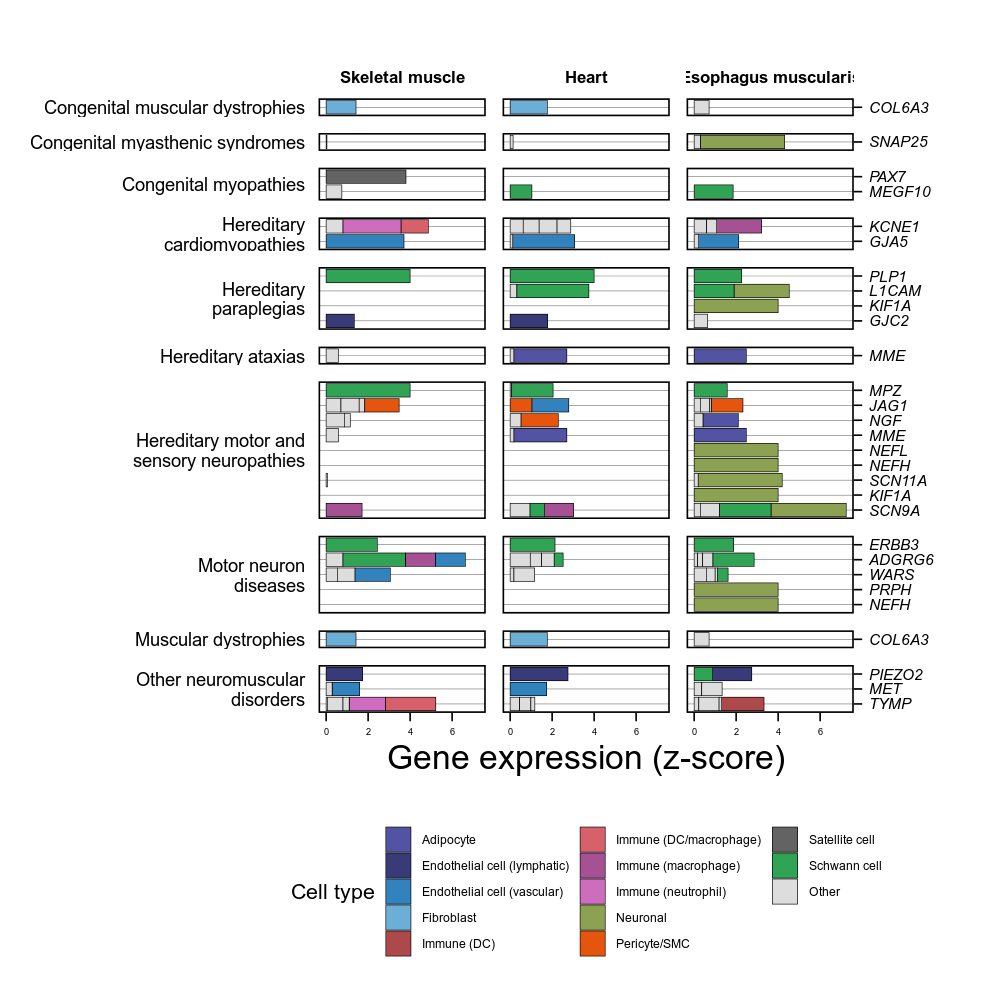

In [111]:
%%R -i df -i color_keys -i color_values -w 4.5 -h 4.5 -u in -r 220

library(ggplot2)

color_list = color_values
names(color_list) = color_keys

g = (
    ggplot(data=df, mapping=aes(x=disease_group_gene, y=spring_score_nonzero, fill=celltype)) + 
    #geom_bar(stat='identity', data=df[!df$sig_and_pos,], fill='gray', alpha=0.5) +    
    geom_bar(stat='identity', color='black', size=0.1) + 
    facet_grid(`Disease group wrap` ~ tissue, scales='free_y', space='free_y', switch='y') + 
    scale_fill_manual(values=color_list) + 
    scale_x_discrete(position = "top", labels=function(x){sapply(strsplit(x, '|', fixed=T), `[[`, 2)}) +
    theme_linedraw() + 
    labs(title='', y='Gene expression (z-score)', x='', fill='Cell type') +
    guides(
        fill = guide_legend(nrow=5)
    ) +
    theme(
          plot.title=element_text(size=8),
          axis.text.x=element_text(size=3),
          axis.text.y=element_text(size=5, face='italic'),                
          panel.grid.minor.x=element_blank(),
          panel.grid.major.x=element_blank(),
          strip.text.x = element_text(size=5.5, color='black', face='bold'),
          strip.text.y.left = element_text(size=6, color='black', angle = 0, hjust=1),        
          strip.background.y = element_blank(), #.y=element_rect(color='white', fill='white'),
          strip.background.x = element_blank(), #element_rect(color='black', fill='white'),        
          legend.position="bottom",
          legend.title=element_text(size=7), 
          legend.text=element_text(size=4),
          legend.key.size = unit(0.3, "cm"),
         ) + 
    coord_flip()
)

print(g)

ggsave('figures/figure-4c.pdf', w=4.5, h=4.5, useDingbats=F)

In [112]:
muscle_genes = {
    'Congenital muscular dystrophies': ['COL6A3'],  
    'Congenital myasthenic syndromes': ['SNAP25'],
    'Congenital myopathies': ['PAX7', 'MEGF10'],
    'Hereditary cardiomayopathies': ['KCNE1', 'GJA5',],
    'Hereditary paraplegias': ['PLP1', 'L1CAM', 'KIF1A', 'GJC2'],
    'Hereditary ataxias': ['MME'],
    'Hereditary motor and sensory neuropathies': ['MPZ', 'JAG1', 'NGF','MME', 'NEFL', 'NEFH', 'SCN11A','KIF1A', 'SCN9A'],
    'Motor neuron diseases': ['ERBB3', 'ADGRG6', 'WARS', 'PRPH', 'NEFH'],
    'Muscular dystrophies': ['COL6A3'],
    'Other neuromuscular disorders': ['PIEZO2','MET', 'TYMP'],
}

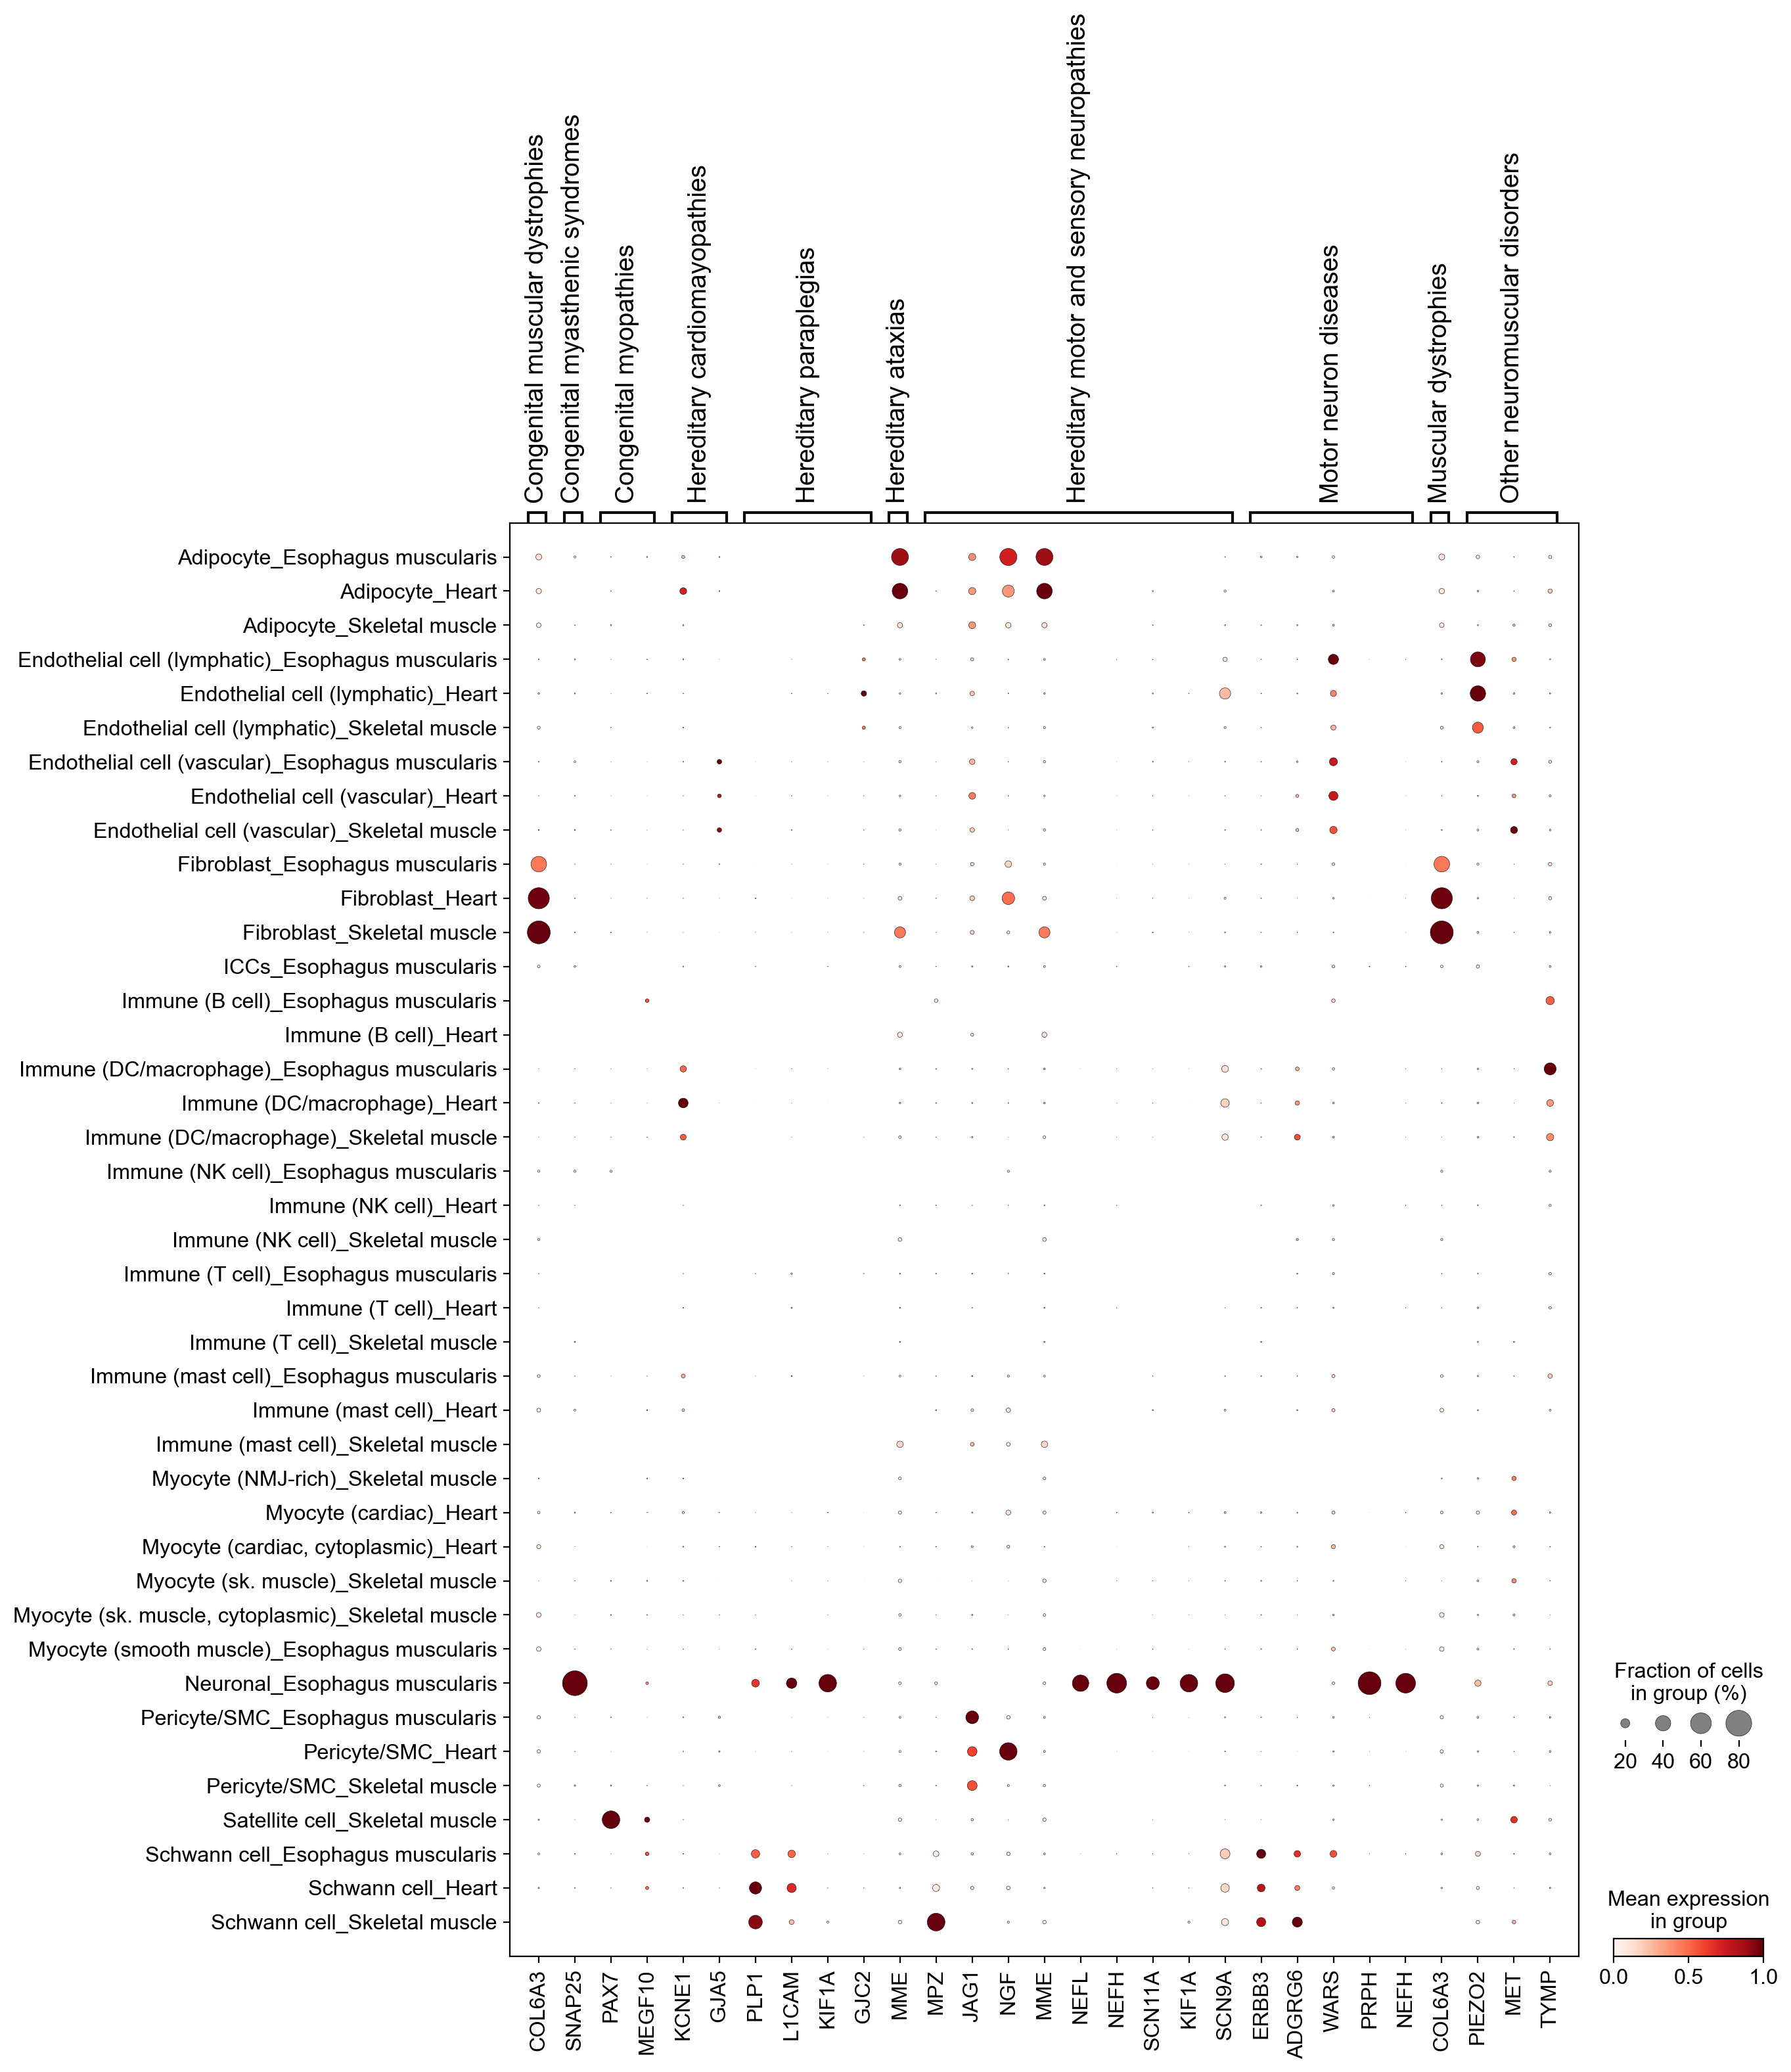

In [113]:
sc.pl.dotplot(
    adata[adata.obs.tissue.isin(['esophagusmuscularis', 'heart', 'skeletalmuscle'])], 
    muscle_genes, groupby=['Broad cell type', 'Tissue'], standard_scale='var')

In [114]:
mouse = sc.read('mouse-muscle.h5ad')

In [115]:
muscle_genes

{'Congenital muscular dystrophies': ['COL6A3'],
 'Congenital myasthenic syndromes': ['SNAP25'],
 'Congenital myopathies': ['PAX7', 'MEGF10'],
 'Hereditary cardiomayopathies': ['KCNE1', 'GJA5'],
 'Hereditary paraplegias': ['PLP1', 'L1CAM', 'KIF1A', 'GJC2'],
 'Hereditary ataxias': ['MME'],
 'Hereditary motor and sensory neuropathies': ['MPZ',
  'JAG1',
  'NGF',
  'MME',
  'NEFL',
  'NEFH',
  'SCN11A',
  'KIF1A',
  'SCN9A'],
 'Motor neuron diseases': ['ERBB3', 'ADGRG6', 'WARS', 'PRPH', 'NEFH'],
 'Muscular dystrophies': ['COL6A3'],
 'Other neuromuscular disorders': ['PIEZO2', 'MET', 'TYMP']}

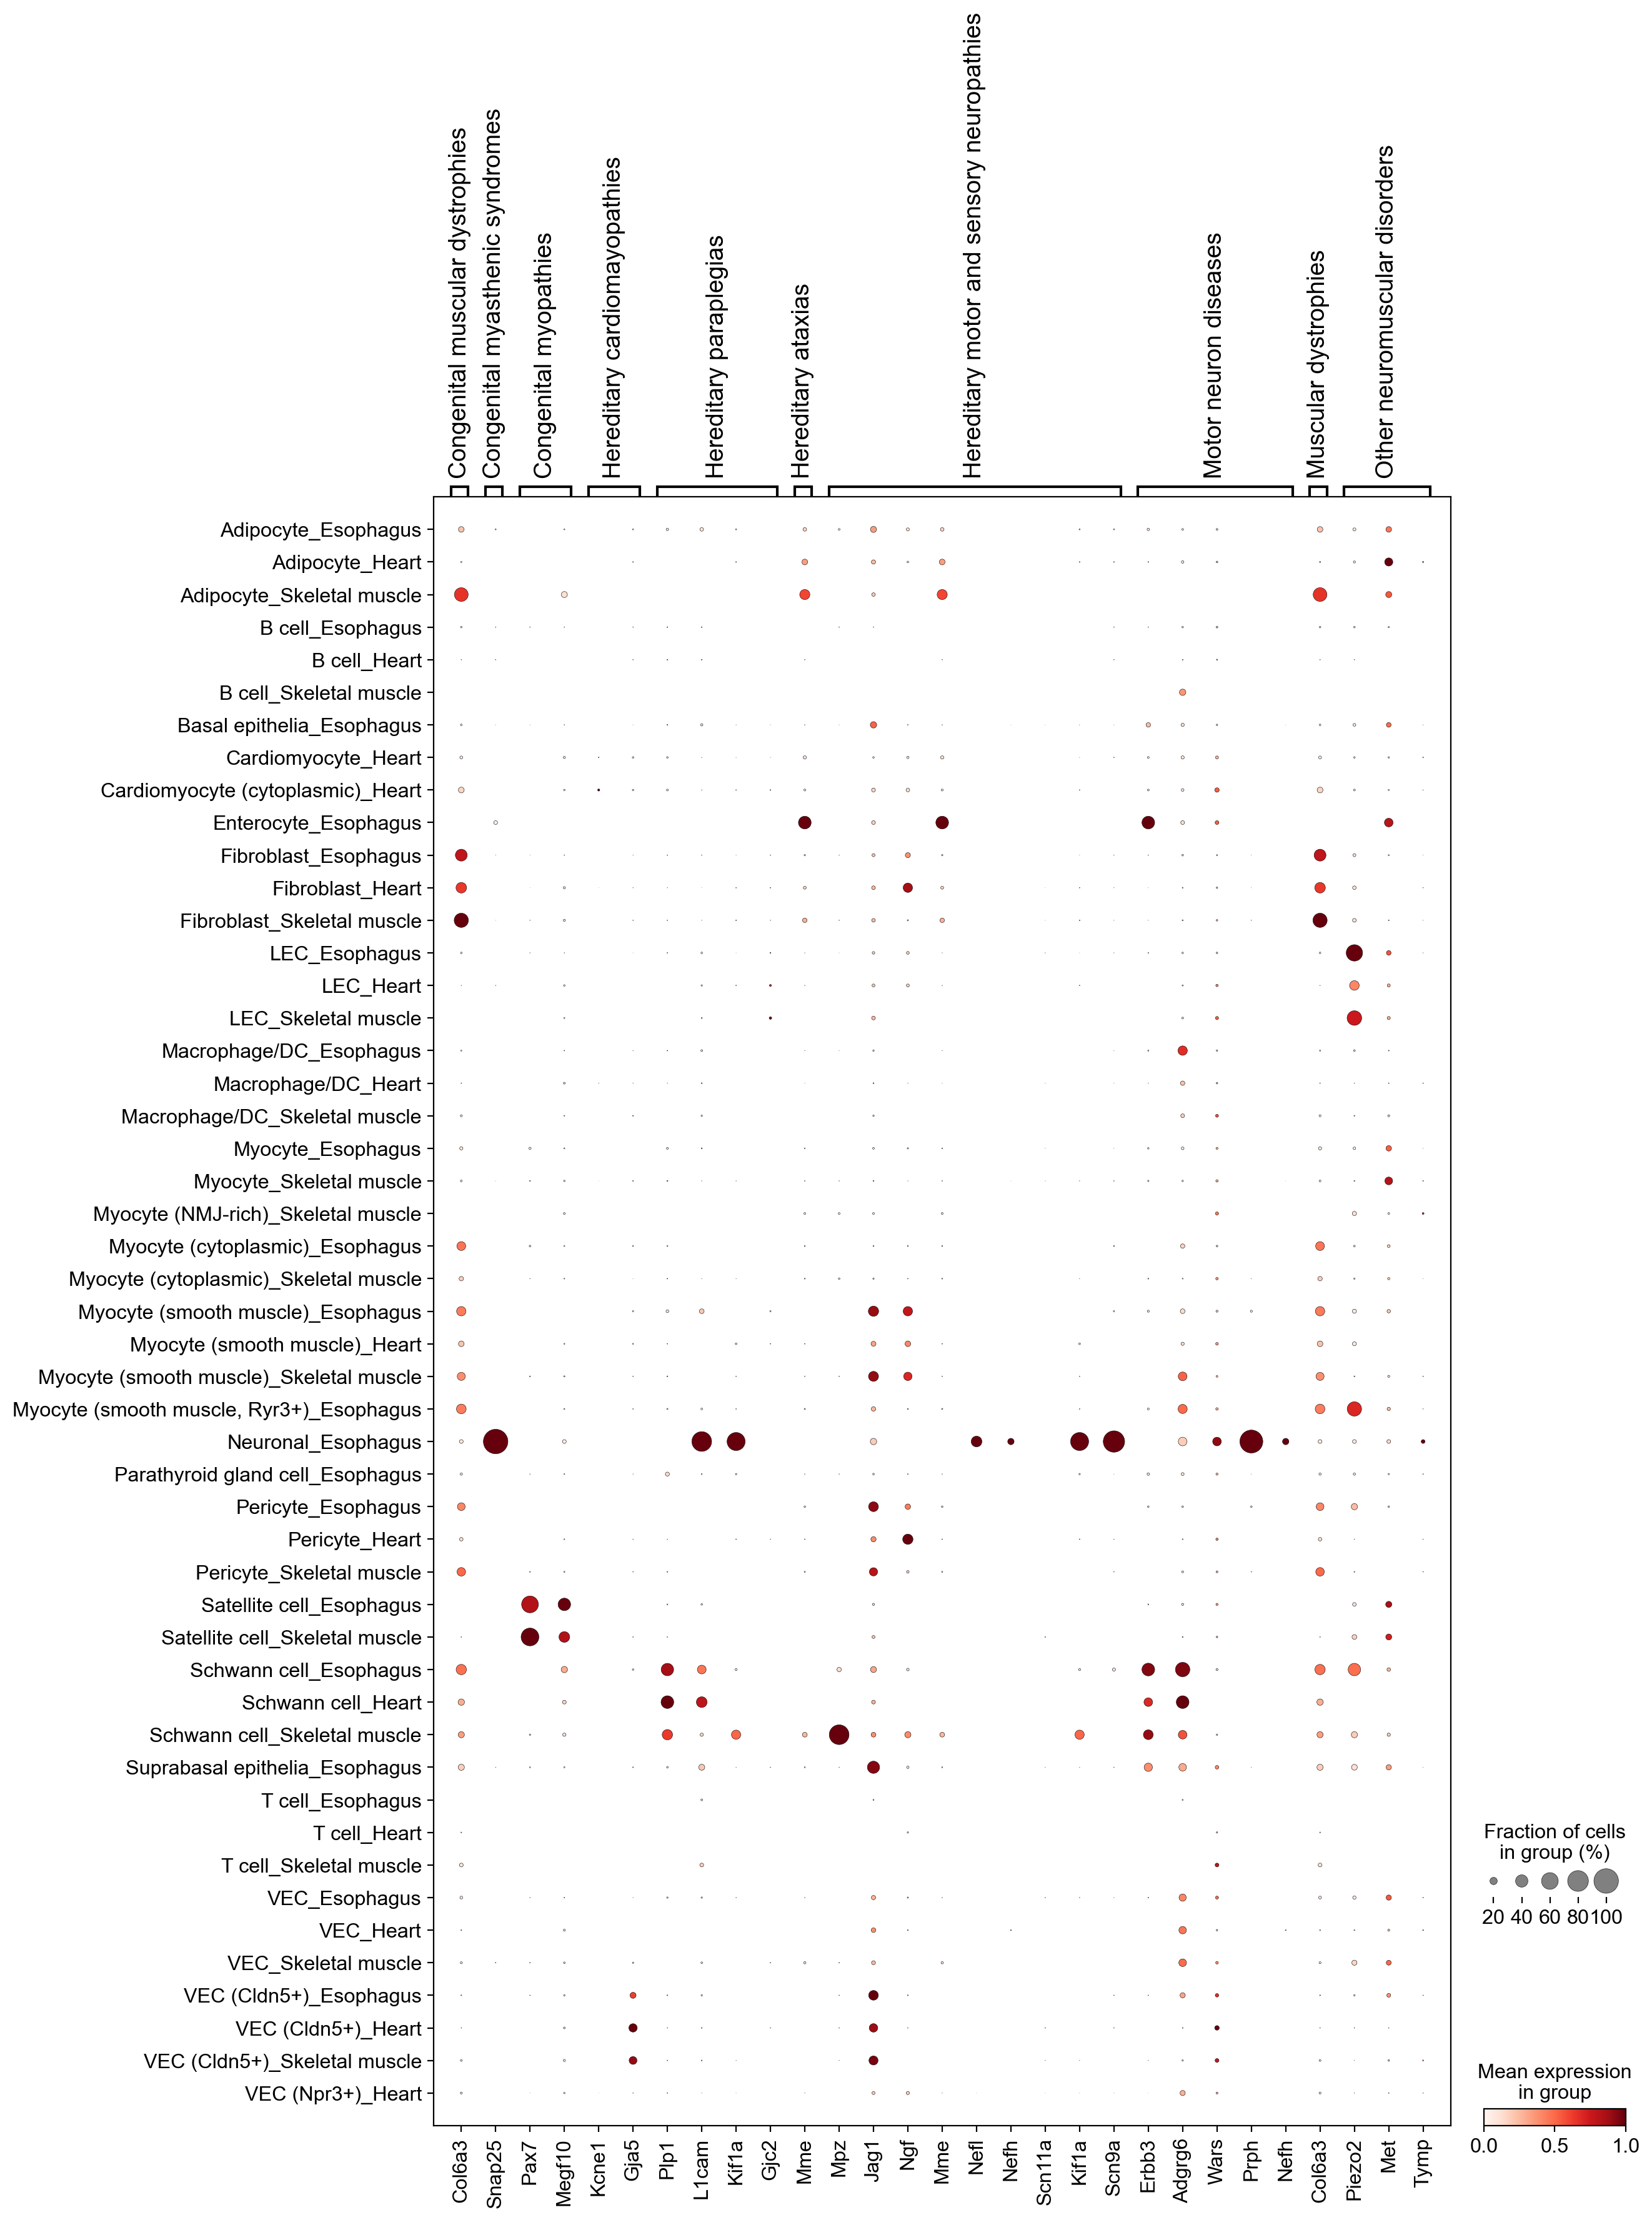

In [116]:
sc.pl.dotplot(
    mouse,
    {k:[x.capitalize() for x in v] for k,v in muscle_genes.items()},
    groupby=['Cell type', 'Tissue'],
    standard_scale='var',
)

In [117]:
muscle_genes = sorted(set([x.split('|')[1] for x in df.disease_group_gene]))
muscle_genes[:10]

['ADGRG6',
 'COL6A3',
 'ERBB3',
 'GJA5',
 'GJC2',
 'JAG1',
 'KCNE1',
 'KIF1A',
 'L1CAM',
 'MEGF10']

In [118]:
len(muscle_genes)

25

## GO enrichment

In [121]:
enrich_df = sc.queries.enrich(muscle_genes, gprofiler_kwargs={'sources': ['GO:BP', 'REAC', 'KEGG'], 'no_evidences': False, 'all_results': True})

In [122]:
enrich_df.significant = enrich_df.p_value<0.1

In [125]:
enrich_df.significant.sum()

33

In [127]:
enrich_df = enrich_df.explode('intersections')
enrich_df = enrich_df[(enrich_df.term_size<1500)]
#exp_df = exp_df[(exp_df.term_size<1500)]

In [128]:
enrich_df['f'] = 2*enrich_df.precision*enrich_df.recall / (enrich_df.precision+enrich_df.recall)

In [129]:
enrich_df['name'] = [f'{x[0].upper()}{x[1:]}' for x in enrich_df.name]

In [130]:
enrich_df = enrich_df[enrich_df.native.isin(enrich_df[enrich_df.significant].native)]

In [131]:
df

disease_group_gene  spring_score_nonzero  \
46584  Congenital muscular dystrophies|COL6A3              0.711956   
46684  Congenital muscular dystrophies|COL6A3              1.775985   
46760  Congenital muscular dystrophies|COL6A3              1.423661   
29087  Congenital myasthenic syndromes|SNAP25              0.308002   
29110  Congenital myasthenic syndromes|SNAP25              0.141295   
...                                       ...                   ...   
36470      Other neuromuscular disorders|TYMP              0.187909   
36488      Other neuromuscular disorders|TYMP              0.742034   
36449      Other neuromuscular disorders|TYMP              0.121258   
36490      Other neuromuscular disorders|TYMP              1.729363   
36497      Other neuromuscular disorders|TYMP              0.293908   

                  celltype                tissue  \
46584                Other  Esophagus muscularis   
46684           Fibroblast                 Heart   
46760           Fibroblast       Skeletal muscle   
29087                Other  Esophagus muscularis   
29110                Other                 Heart   
...                    ...                   ...   
36470                Other                 Heart   
36488                Other       Skeletal muscle   
36449                Other  Esophagus muscularis   
36490  Immune (neutrophil)       Skeletal muscle   
36497                Other       Skeletal muscle   

                         Disease group  significant  sig_and_pos  \
46584  Congenital muscular dystrophies         True        False   
46684  Congenital muscular dystrophies         True         True   
46760  Congenital muscular dystrophies         True         True   
29087  Congenital myasthenic syndromes         True        False   
29110  Congenital myasthenic syndromes         True        False   
...                                ...          ...          ...   
36470    Other neuromuscular disorders         True        False   
36488    Other neuromuscular disorders         True        False   
36449    Other neuromuscular disorders         True        False   
36490    Other neuromuscular disorders         True         True   
36497    Other neuromuscular disorders         True        False   

                    Disease group wrap  
46584  Congenital muscular dystrophies  
46684  Congenital muscular dystrophies  
46760  Congenital muscular dystrophies  
29087  Congenital myasthenic syndromes  
29110  Congenital myasthenic syndromes  
...                                ...  
36470   Other neuromuscular\ndisorders  
36488   Other neuromuscular\ndisorders  
36449   Other neuromuscular\ndisorders  
36490   Other neuromuscular\ndisorders  
36497   Other neuromuscular\ndisorders  

[129 rows x 8 columns]

In [132]:
df['gene'] = [x.split('|')[-1] for x in df.disease_group_gene]

In [133]:
merge_df = enrich_df.merge(df.drop(columns=['significant']), left_on='intersections', right_on='gene')

In [134]:
ct = merge_df.loc[merge_df.groupby('gene')['spring_score_nonzero'].idxmax().values][['gene', 'celltype', 'tissue']].set_index('gene').to_dict()

merge_df['celltype'] = merge_df.intersections.map(ct['celltype'])
merge_df['tissue'] = merge_df.intersections.map(ct['tissue'])

In [135]:
x = merge_df.assign(val=1)[['name', 'intersections', 'val']].drop_duplicates().pivot('name', 'intersections', 'val').fillna(0).astype(float)

corr_matrix = x.corr().fillna(0)
z_var = sch.linkage(corr_matrix)
dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
merge_df['intersections'] = pd.Categorical(merge_df['intersections'], categories=dendro_info['ivl'])

corr_matrix = x.T.corr().fillna(0)
z_var = sch.linkage(corr_matrix)
dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)

merge_df['name'] = pd.Categorical(merge_df['name'], categories=dendro_info['ivl'])

In [136]:
merge_df[merge_df.significant & (merge_df.source == 'REAC')].name.unique()

['Interaction between L1 and Ankyrins', 'Nervous system development']
Categories (2, object): ['Interaction between L1 and Ankyrins', 'Nervous system development']

In [137]:
merge_df.f.max()

0.14285714285714285

In [138]:
merge_df['neglogfdr'] = -np.log10(merge_df.p_value)

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 5.5 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/figure-4f.pdf


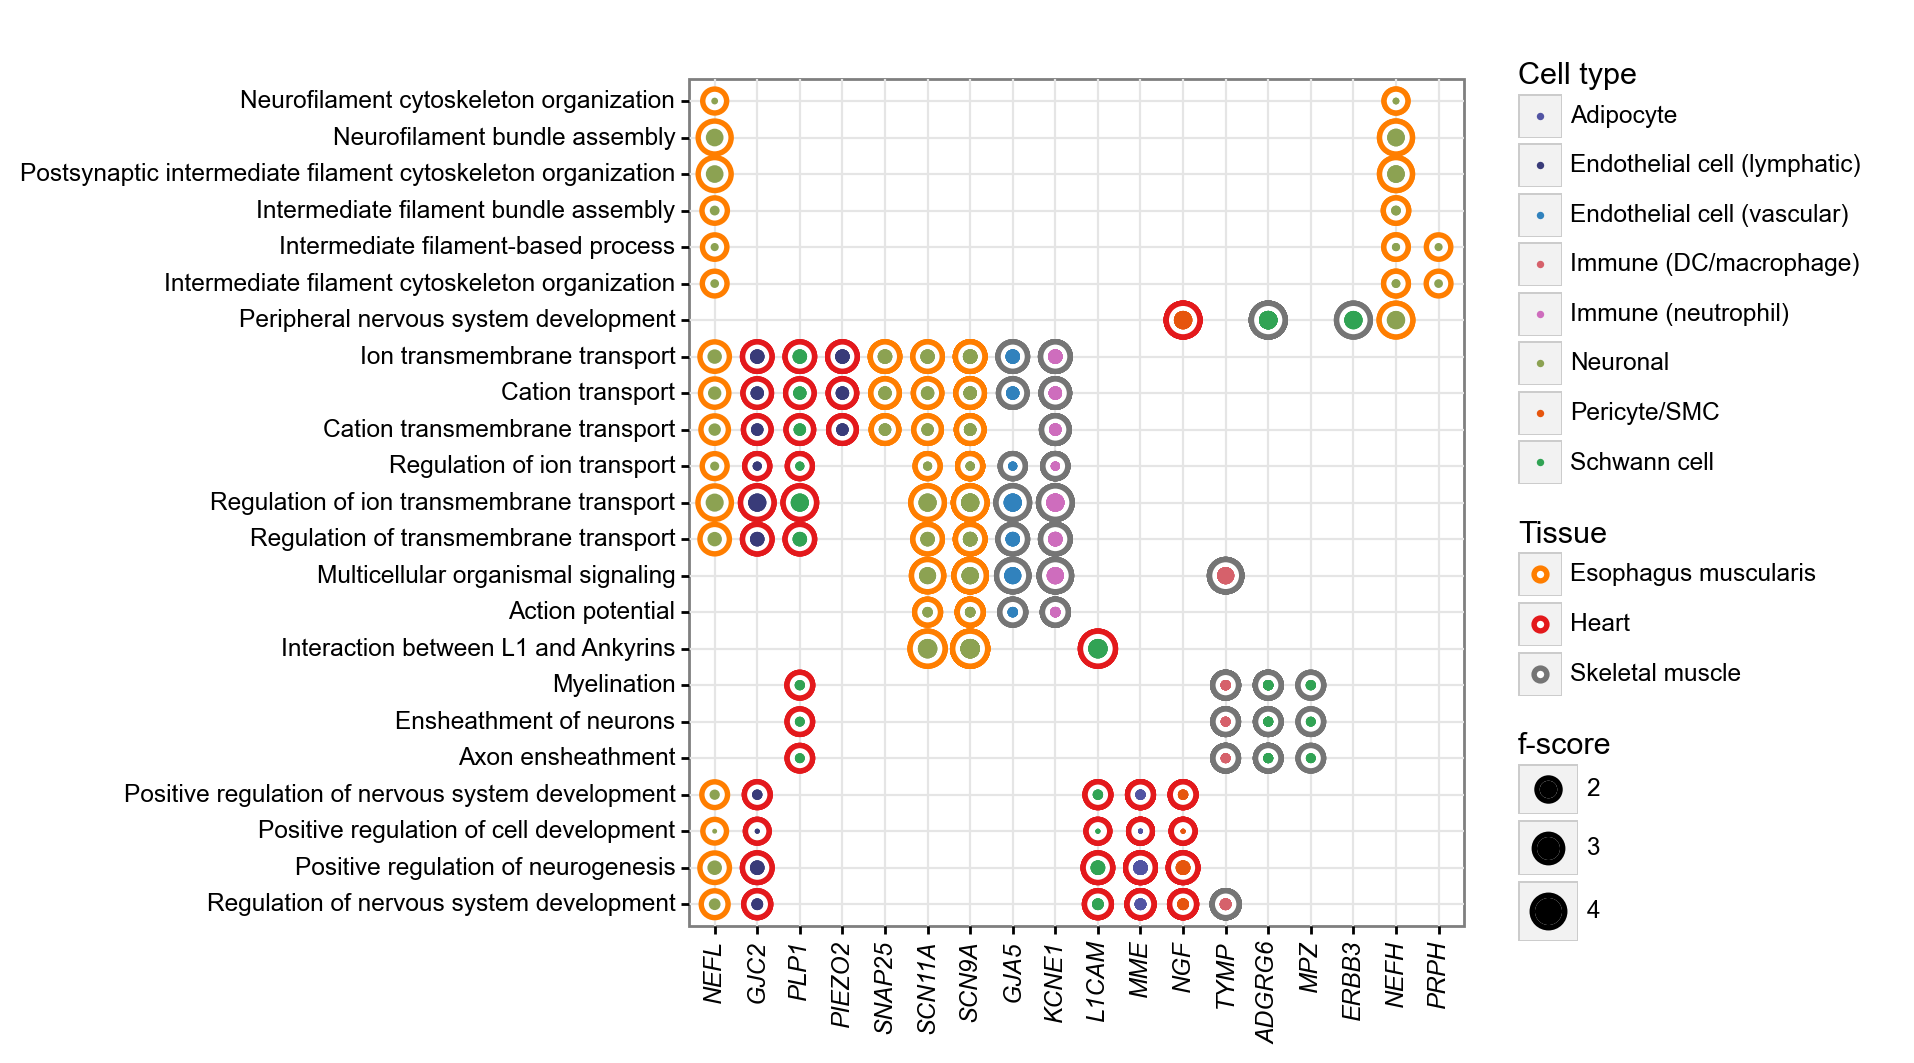

<ggplot: (8731485388475)>

In [143]:
g = (
    p9.ggplot(p9.aes(x='intersections', y='name'), data=merge_df[merge_df.name!='Nervous system development']) + 
    p9.geom_point(p9.aes(size='neglogfdr*2.05', color='tissue'), fill='white', stroke=1.1)+ #, show_legend=False) +                 
    p9.geom_point(p9.aes(size='neglogfdr', fill='celltype'), color='black', stroke=0) +
    #p9.geom_point(p9.aes(color='tissue'), fill='none', size=4, stroke=1.2) +         
    #p9.geom_point(p9.aes(fill='celltype'), color='white', size=2.7, stroke=0) + 
    p9.theme_bw() + 
    p9.labs(x='', y='', color='Tissue', fill='Cell type', size='f-score') + 
    p9.scale_fill_manual(values=color_dict) + 
    p9.scale_color_manual(values={'Esophagus muscularis': '#ff7e00', 'Heart':'#e3191c', 'Skeletal muscle': '#757575'}) +
    #p9.scale_size_continuous(trans='log', range=(1,5), breaks=[0.02, 0.05, 0.1, 0.15]) + 
    #p9.coord_flip() + 
    p9.theme(figure_size=(5,5.5), axis_text_x=element_text(angle=90, hjust=0.5, face='italic'), text=element_text(family='Arial', color='black'))
)

ggsave(g, 'figures/figure-4f.pdf')

g

/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 5 x 5.5 in image.
/home/gokcen/.miniconda3/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figures/figure-4f.pdf


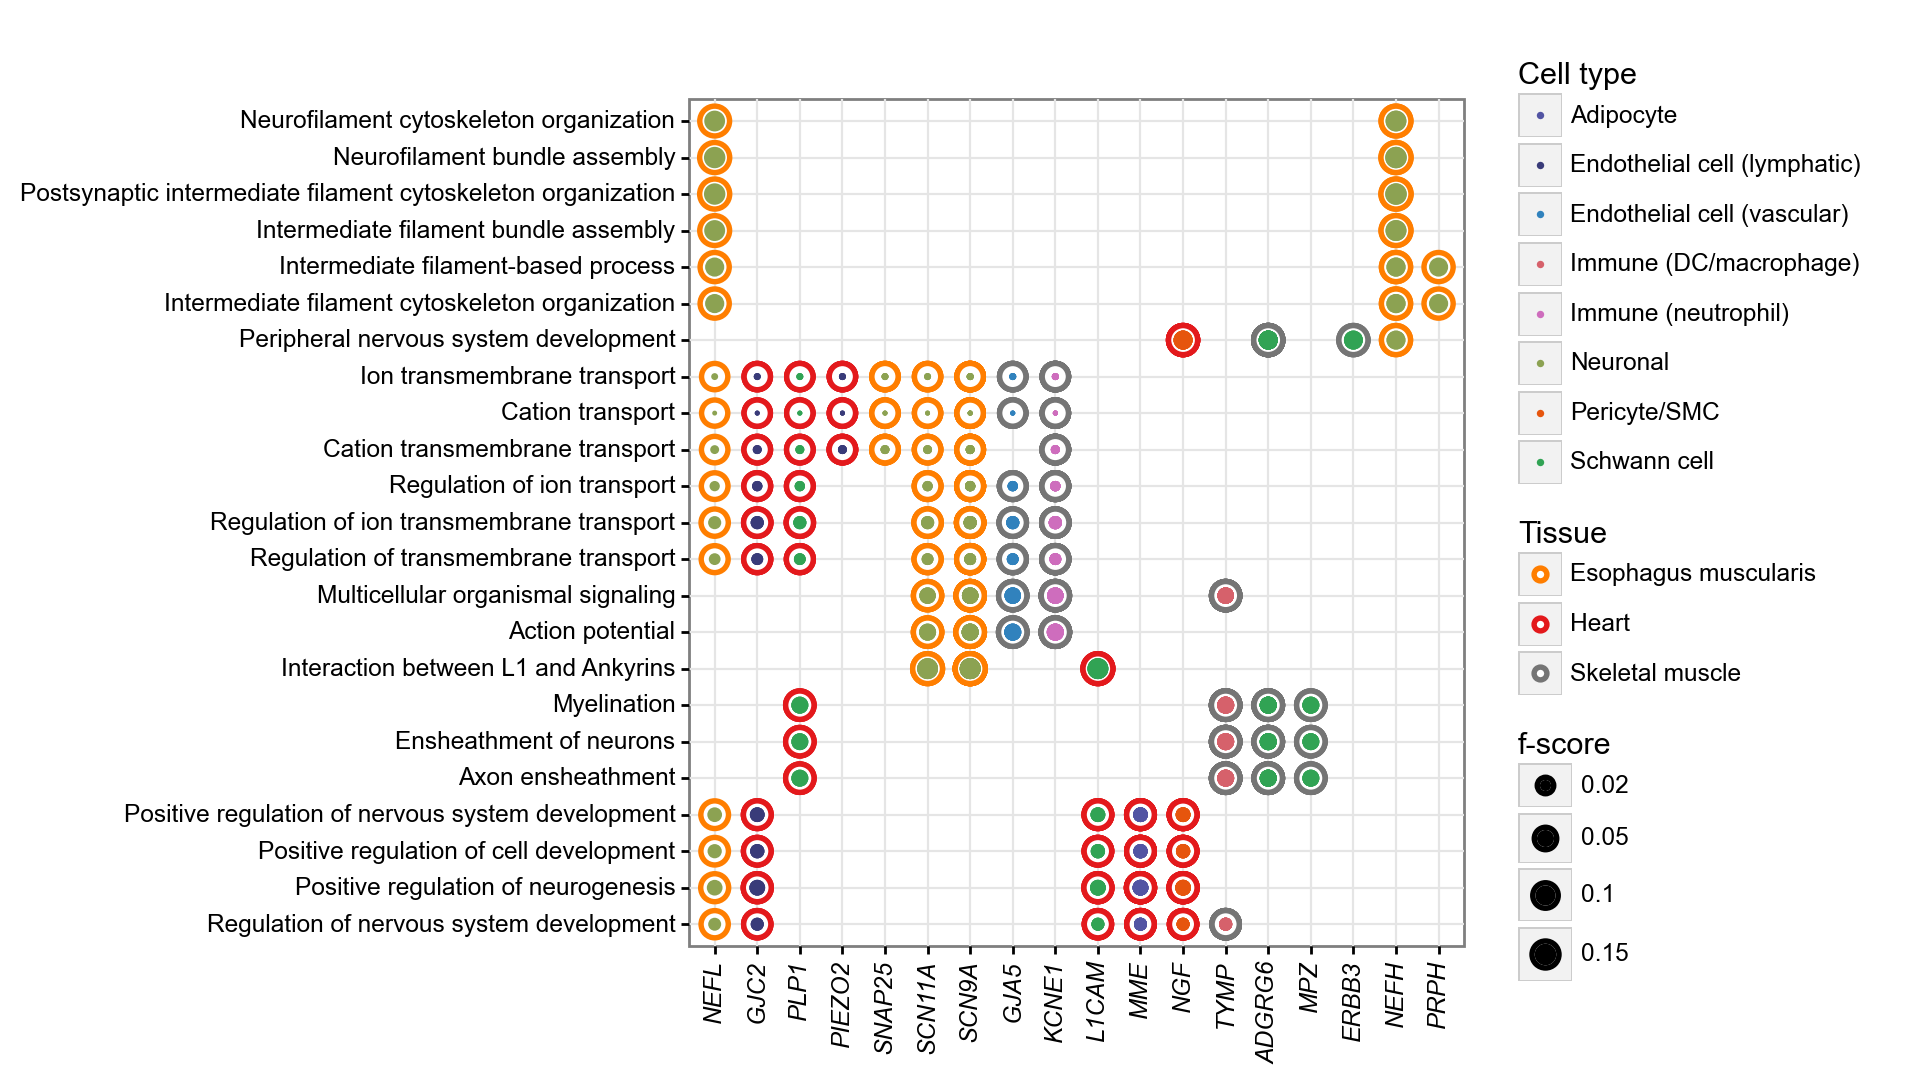

<ggplot: (8731485435615)>

In [150]:
g = (
    p9.ggplot(p9.aes(x='intersections', y='name'), data=merge_df[merge_df.name!='Nervous system development']) + 
    p9.geom_point(p9.aes(size='f**(0.5)', color='tissue'), fill='white', stroke=1.1) +                 
    p9.geom_point(p9.aes(size='f', fill='celltype'), color='black', stroke=0) +
    #p9.geom_point(p9.aes(color='tissue'), fill='none', size=4, stroke=1.2) +         
    #p9.geom_point(p9.aes(fill='celltype'), color='white', size=2.7, stroke=0) + 
    p9.theme_bw() + 
    p9.labs(x='', y='', color='Tissue', fill='Cell type', size='f-score') + 
    p9.scale_fill_manual(values=color_dict) + 
    p9.scale_color_manual(values={'Esophagus muscularis': '#ff7e00', 'Heart':'#e3191c', 'Skeletal muscle': '#757575'}) +
    p9.scale_size_continuous(trans='log', range=(1,5), breaks=[0.02, 0.05, 0.1, 0.15]) + 
    #p9.coord_flip() + 
    p9.theme(figure_size=(5,5.5), axis_text_x=element_text(angle=90, hjust=0.5, face='italic'), text=element_text(family='Arial', color='black'))
)

ggsave(g, 'figures/figure-4f.pdf')

g

## Plot mean z-score of DE genes for myocytes

In [797]:
include = [ 
    'Myocyte (sk. muscle)',
    'Myocyte (NMJ-rich)',
    'Myocyte (sk. muscle, cytoplasmic)',    
    'Myocyte (fast-twitch, cytoplasmic)',
    'Myocyte (slow-twitch, cytoplasmic)',
    'Myocyte (fast-twitch)',
    'Myocyte (smooth muscle TAGLN lo)',
    'Myocyte (smooth muscle)',
    'Myocyte (cardiac)',
    'Myocyte (cardiac, cytoplasmic)',
]

In [798]:
x = de[['celltype', 'tissue']].drop_duplicates()
x[x.tissue == 'Esophagus muscularis']

celltype                tissue
0                          Adipocyte  Esophagus muscularis
1       Endothelial cell (lymphatic)  Esophagus muscularis
2      Endothelial cell (vascular) I  Esophagus muscularis
3     Endothelial cell (vascular) II  Esophagus muscularis
4    Endothelial cell (vascular) III  Esophagus muscularis
5                       Fibroblast I  Esophagus muscularis
6                      Fibroblast II  Esophagus muscularis
7                               ICCs  Esophagus muscularis
8                    Immune (B cell)  Esophagus muscularis
9                        Immune (DC)  Esophagus muscularis
10            Immune (DC/macrophage)  Esophagus muscularis
11                  Immune (NK cell)  Esophagus muscularis
12                   Immune (T cell)  Esophagus muscularis
13             Immune (macrophage I)  Esophagus muscularis
14            Immune (macrophage II)  Esophagus muscularis
15                Immune (mast cell)  Esophagus muscularis
16  Myocyte (smooth muscle TAGLN lo)  Esophagus muscularis
17           Myocyte (smooth muscle)  Esophagus muscularis
18                          Neuronal  Esophagus muscularis
19                    Pericyte/SMC I  Esophagus muscularis
20                   Pericyte/SMC II  Esophagus muscularis
21                    Schwann cell I  Esophagus muscularis
22                   Schwann cell II  Esophagus muscularis

In [799]:
zscore_cutoff = 1.

de['sig_and_pos'] = de.significant & (de.spring_score>zscore_cutoff) & (de.fraction_group>.05)

gene_list = de[de.sig_and_pos & (de.celltype.isin(include))].gene.tolist()

df = de[(de.gene.isin(gene_list))].copy()
df = df[df.celltype.isin(include)].copy()
df = df[~df.celltype.str.contains('Unknown')].copy()
df.celltype.loc[~df.sig_and_pos] = 'Other'

df = remove_nonsig_tissue_disease(df)
#df = reorder_categories(df)

#df.spring_score_nonzero.loc[(~df.significant)] = np.nan
df.spring_score_nonzero.loc[df.spring_score_nonzero>4] = 4

df = df[['disease_group_gene', 'spring_score_nonzero', 'celltype', 'tissue', 'Disease group', 'significant', 'sig_and_pos']].drop_duplicates()

color_dict = {k:v for k,v in zip(adata.obs['Granular cell type'].cat.categories, adata.uns['Granular cell type_colors'])}
color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

%load_ext rpy2.ipython

color_values = [
    #'#5254a3', #'#6b6ecf', '#9c9ede', 


    #'#8c6d31', #'#bd9e39', '#e7ba52', '#e7cb94', 
    '#843c39', '#ad494a', #'#d6616b', '#e7969c', 
    '#393b79', '#3182bd', '#6baed6', #'#9ecae1', # '#c6dbef',     
    #'#7b4173', '#a55194', '#ce6dbd', #'#de9ed6',
    '#637939', '#8ca252', '#b5cf6b', #'#cedb9c', 
    #'#e6550d', #'#fd8d3c', #'#fdae6b', '#fdd0a2', 
    #'#636363', #'#969696', '#bdbdbd', '#d9d9d9'    
    #'#31a354', '#74c476', #'#a1d99b', '#c7e9c0', 
    #'#756bb1', 
    '#9e9ac8', #'#bcbddc', '#dadaeb', 
]

import textwrap

dg_exclude = ['Ion channel muscle diseases', 'Hereditary paraplegias', 'Congenital muscular dystrophies', 'Congenital myasthenic syndromes'] #'Congenital myopathies', 'Metabolic myopathies', ]
df['Disease group wrap'] = [textwrap.fill(x, 20) if x not in dg_exclude else x for x in df['Disease group']]

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [800]:
len(set(gene_list))

113

de[['celltype', 'gene', 'tstat', 'pvals', 'pvals_fdr', 'log2FC',
       'fraction_group', 'fraction_rest', 'mean_expressed', 'spring_score',
       'tissue', 'significant', 'spring_score_nonzero', 'Disease group',
       'Disease subgroup', 'Disease phenotype', 'Gene', 'Item',
       'Disease group subgroup', 'sig_and_pos']][de.sig_and_pos].to_excel('muscle_disease-DE-genetable-merged.xlsx', index=False)

In [801]:
def simplify_ct(x):
    if x.endswith(' I'):
        return x[:-2]
    if x.endswith(' II'):
        return x[:-3]
    if x.endswith(' III'):
        return x[:-4]
    if x.endswith(' II)'):
        return f'{x[:-4]})'
    return x

df.celltype = [simplify_ct(x) for x in df.celltype]

df['celltype'] = pd.Categorical(df['celltype'], categories=sorted(set(adata.obs['Granular cell type'].cat.categories.tolist() + adata.obs['Broad cell type'].cat.categories.tolist())) + ['Other'])
df['celltype'].cat.remove_unused_categories(inplace=True)

df['celltype'].cat.categories

color_dict = {x: (col if x != 'Other' else '#DDDDDD') for x,col in zip(df['celltype'].cat.categories, color_values)}

color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

ad_colors = {x:y for x,y in zip(adata.obs['Broad cell type'].cat.categories, adata.uns['Broad cell type_colors'])}

In [802]:
muscle_diseases.Gene.nunique()

606

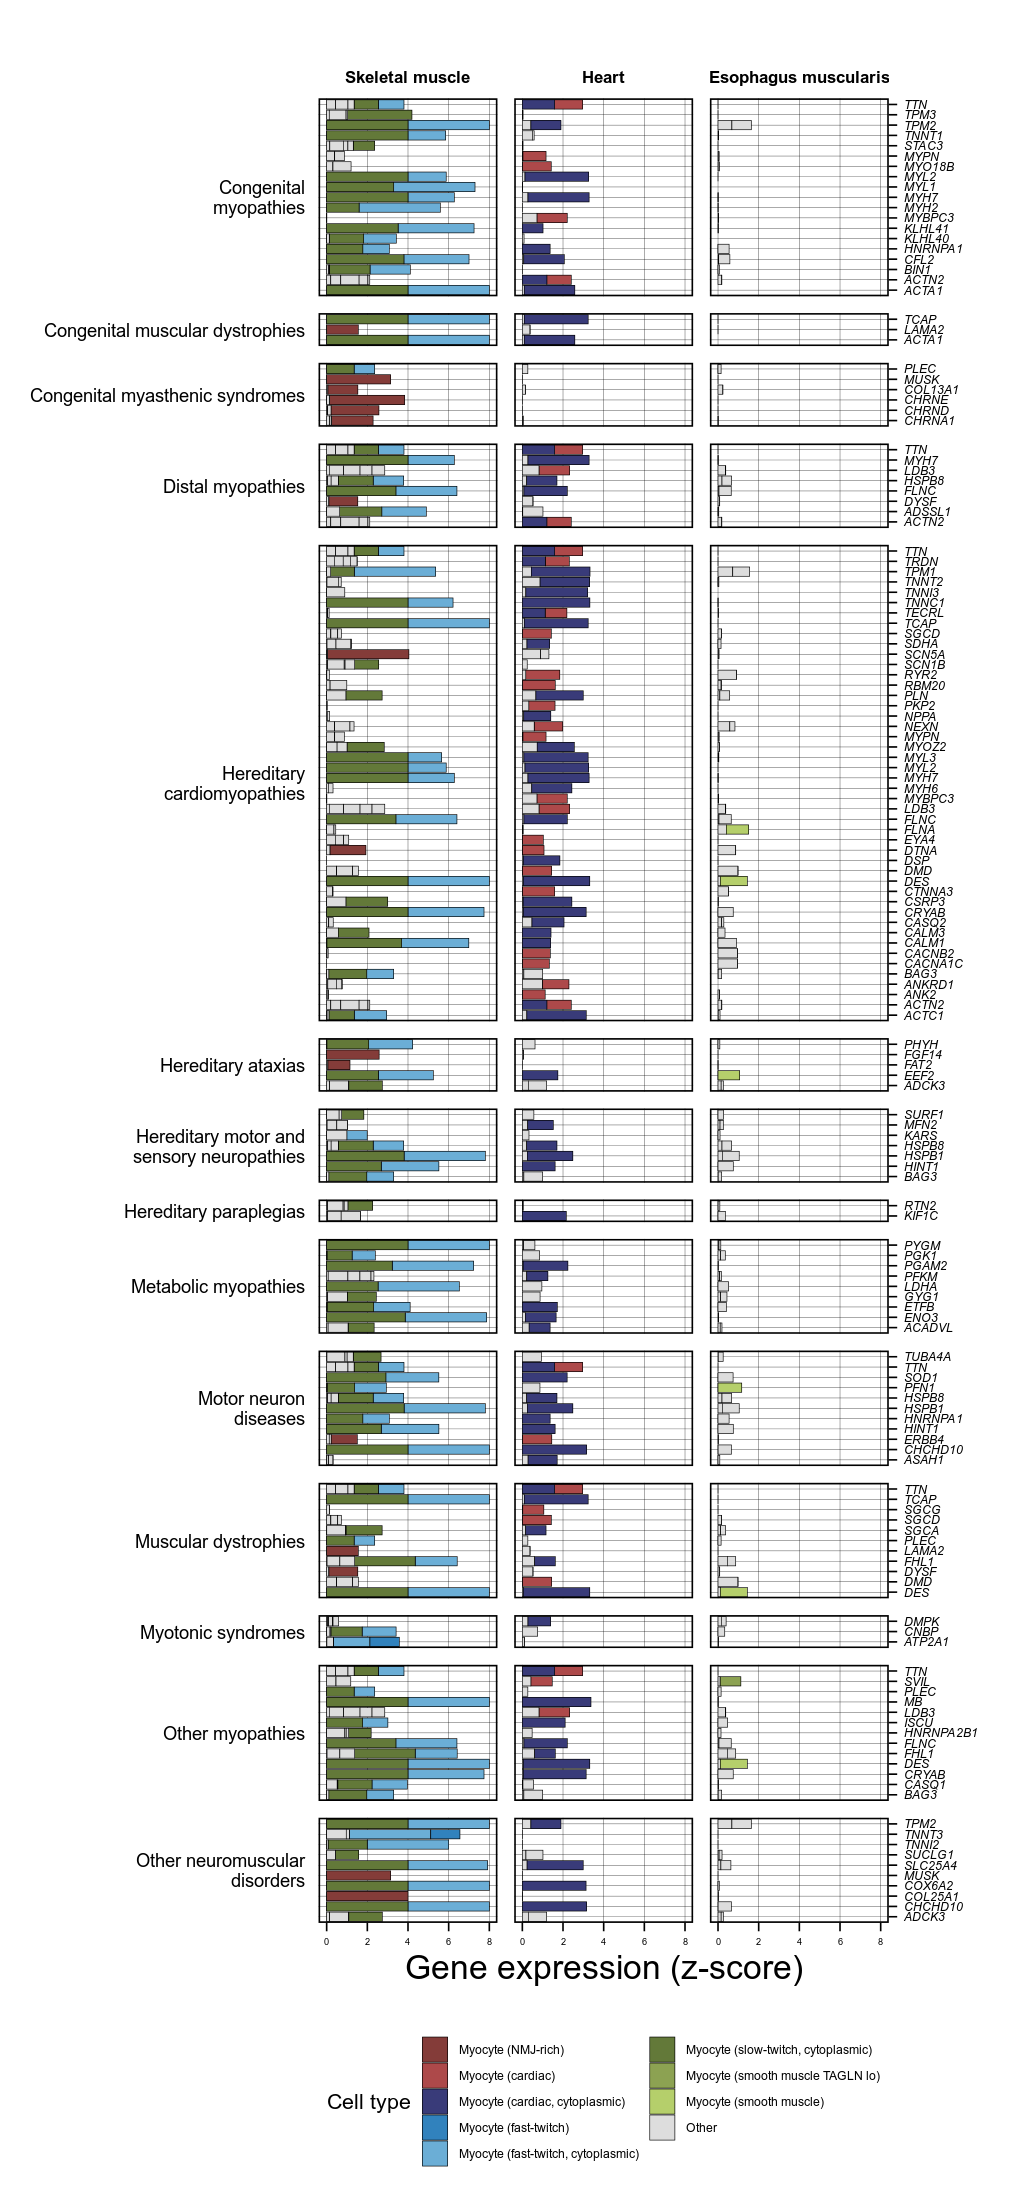

In [804]:
%%R -i df -i color_keys -i color_values -w 4.7 -h 10 -u in -r 220

library(ggplot2)

color_list = color_values
names(color_list) = color_keys

g = (
    ggplot(data=df, mapping=aes(x=disease_group_gene, y=spring_score_nonzero, fill=celltype)) + 
    #geom_bar(stat='identity', data=df[!df$sig_and_pos,], fill='gray', alpha=0.5) +    
    geom_bar(stat='identity', color='black', size=0.1) + 
    facet_grid(`Disease group wrap` ~ tissue, scales='free_y', space='free_y', switch='y') + 
    scale_fill_manual(values=color_list) + 
    scale_x_discrete(position = "top", labels=function(x){sapply(strsplit(x, '|', fixed=T), `[[`, 2)}) +
    theme_linedraw() + 
    labs(title='', y='Gene expression (z-score)', x='', fill='Cell type') +
    guides(
        fill = guide_legend(nrow=5)
    ) +
    theme(
          plot.title=element_text(size=8),
          axis.text.x=element_text(size=3),
          axis.text.y=element_text(size=4, face='italic'),                
          panel.grid.minor.x=element_blank(),
          strip.text.x = element_text(size=5.5, color='black', face='bold'),
          strip.text.y.left = element_text(size=6, color='black', angle = 0, hjust=1),        
          strip.background.y=element_blank(), #rect(color='white', fill='white'),
          strip.background.x=element_blank(), #rect(color='black', fill='white'),        
          legend.position="bottom",
          legend.title=element_text(size=7), 
          legend.text=element_text(size=4),
          legend.key.size = unit(0.3, "cm"),
         ) + 
    coord_flip()
)

print(g)

ggsave('figures/figure-S15.pdf', w=5, h=10, useDingbats=F)

## Panel B -- DEG and monogenic muscle disease overlap barplot -- with subgroups

In [805]:
def remove_nonsig_tissue_disease(de):
    disease_blacklist = (de.groupby(['Disease group', 'Disease subgroup', 'disease_gene'])[['sig_and_pos']].sum()==0).reset_index()[['disease_gene', 'sig_and_pos']]
    disease_blacklist = disease_blacklist[disease_blacklist.sig_and_pos].disease_gene.values

    celltypetissue_blacklist = []
    #celltypetissue_blacklist = (de.groupby(['tissue_celltype'])[['sig_and_pos']].sum()==0).reset_index()[['tissue_celltype', 'sig_and_pos']]
    #celltypetissue_blacklist = celltypetissue_blacklist[celltypetissue_blacklist.sig_and_pos].tissue_celltype.values

    de = de[(~de.disease_gene.isin(disease_blacklist)) & (~de.tissue_celltype.isin(celltypetissue_blacklist))]
    return de

In [806]:
import scipy.cluster.hierarchy as sch

def reorder_categories(de):
    de = de.copy()
    disease_order_list = []

    for c in sorted(de.disease_cat.unique()):
        x = de[de.disease_cat == c]
        if x.disease_gene.nunique() == 1:
            disease_order_list.extend(x.disease_gene.unique())
            continue
        elif x.disease_gene.nunique() == 0:
            continue
        else:
            pass
        x = x[['sig_and_pos', 'disease_gene', 'tissue_celltype']].drop_duplicates().pivot('disease_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.T.corr().fillna(0)
        z_var = sch.linkage(corr_matrix)
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        disease_order_list.extend(dendro_info['ivl'])

    disease_gene_order_list = []
    
    for c in sorted(de['Disease group subgroup'].unique()):
        x = de[de['Disease group subgroup'] == c]
        if x.disease_group_subgroup_gene.nunique() == 1:
            disease_gene_order_list.extend(x.disease_group_subgroup_gene.unique())
            continue
        elif x.disease_group_subgroup_gene.nunique() == 0:
            continue
        else:
            pass
        
        x = x[['sig_and_pos', 'disease_group_subgroup_gene', 'tissue_celltype']].drop_duplicates().pivot('disease_group_subgroup_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.T.corr().fillna(0)
        z_var = sch.linkage(corr_matrix, method='complete')
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        disease_gene_order_list.extend(dendro_info['ivl'])
            
    tissue_celltype_order_list = []
    
    for c in sorted(de.tissue.unique()):
        x = de[de.tissue == c]
        if x.tissue_celltype.nunique() == 1:
            tissue_celltype_order_list.extend(x.tissue_celltype.unique())
            continue
        elif x.tissue_celltype.nunique() == 0:
            continue
        else:
            pass
        x = x[['sig_and_pos', 'disease_gene', 'tissue_celltype']].drop_duplicates().pivot('disease_gene', 'tissue_celltype', 'sig_and_pos').fillna(False).astype(float)
        corr_matrix = x.corr().fillna(0)
        z_var = sch.linkage(corr_matrix)
        dendro_info = sch.dendrogram(z_var, labels=corr_matrix.index.values, no_plot=True)
        tissue_celltype_order_list.extend(dendro_info['ivl'])


    de['disease_gene'] = pd.Categorical(de['disease_gene'], categories=pd.Series(disease_order_list).unique().tolist())
    de['tissue_celltype'] = pd.Categorical(de['tissue_celltype'], categories=pd.Series(tissue_celltype_order_list).unique().tolist())
    de['disease_group_subgroup_gene'] = pd.Categorical(de['disease_group_subgroup_gene'], categories=pd.Series(disease_gene_order_list).unique().tolist())
    
    return de

## Plot mean z-score of DE genes from non-myocytes (without excluding gene expressed in myocytes)

In [807]:
color_keys

['Myocyte (NMJ-rich)',
 'Myocyte (cardiac)',
 'Myocyte (cardiac, cytoplasmic)',
 'Myocyte (fast-twitch)',
 'Myocyte (fast-twitch, cytoplasmic)',
 'Myocyte (slow-twitch, cytoplasmic)',
 'Myocyte (smooth muscle TAGLN lo)',
 'Myocyte (smooth muscle)',
 'Other']

In [808]:
color_values

['#843c39',
 '#ad494a',
 '#393b79',
 '#3182bd',
 '#6baed6',
 '#637939',
 '#8ca252',
 '#b5cf6b',
 '#DDDDDD']

In [809]:
exclude = [ 
    'Myocyte (sk. muscle)',
    'Myocyte (sk. muscle, cytoplasmic)',    
    'Myocyte (fast-twitch, cytoplasmic)',
    'Myocyte (slow-twitch, cytoplasmic)',
    'Myocyte (fast-twitch)',
    'Myocyte (smooth muscle TAGLN lo)',
    'Myocyte (smooth muscle)',
    'Myocyte (NMJ-rich)',    
    'Myocyte (cardiac)',
    'Myocyte (cardiac, cytoplasmic)',
]

zscore_cutoff = 1.

de['sig_and_pos'] = de.significant & (de.spring_score>zscore_cutoff) & (de.fraction_group>.05)

gene_list = de[de.sig_and_pos & (~de.celltype.isin(exclude))].gene.tolist()

group = 'Cool genes'
df = de[(de.gene.isin(gene_list))].copy()
df = df[~df.celltype.isin(exclude)].copy()

df = df[~df.celltype.str.contains('Unknown')].copy()

df.celltype.loc[~df.sig_and_pos] = 'Other'

title = group

df = remove_nonsig_tissue_disease(df)
df = reorder_categories(df)

#df.spring_score_nonzero.loc[(~df.significant)] = np.nan
df.spring_score_nonzero.loc[df.spring_score_nonzero>4] = 4

df = df[['disease_group_subgroup_gene', 'spring_score_nonzero', 'celltype', 'tissue', 'Disease group subgroup', 'significant', 'sig_and_pos']].drop_duplicates()

color_dict = {k:v for k,v in zip(adata.obs['Granular cell type'].cat.categories, adata.uns['Granular cell type_colors'])}
color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

%load_ext rpy2.ipython

color_values = [
    '#5254a3', #'#6b6ecf', '#9c9ede', 
    '#393b79', '#3182bd', '#6baed6', '#9ecae1', # '#c6dbef',     

    '#8c6d31', #'#bd9e39', '#e7ba52', '#e7cb94', 
    '#843c39', '#ad494a', '#d6616b', '#e7969c', 
    '#7b4173', '#a55194', '#ce6dbd', '#de9ed6',
    #'#637939', 
    '#8ca252', #'#b5cf6b', #'#cedb9c', 
    '#e6550d', #'#fd8d3c', #'#fdae6b', '#fdd0a2', 
    '#636363', #'#969696', '#bdbdbd', '#d9d9d9'    
    '#31a354', '#74c476', #'#a1d99b', '#c7e9c0', 
    '#756bb1', '#9e9ac8', #'#bcbddc', '#dadaeb', 
]

import textwrap

#dg_exclude = ['Ion channel muscle diseases'] #'Congenital myopathies', 'Metabolic myopathies', ]
df['Disease group wrap'] = df['Disease group subgroup'] #[textwrap.fill(x, 20) if x not in dg_exclude else x for x in df['Disease group subgroup']]

def simplify_ct(x):
    if x.endswith(' I'):
        return x[:-2]
    if x.endswith(' II'):
        return x[:-3]
    if x.endswith(' III'):
        return x[:-4]
    if x.endswith(' I)'):
        return f'{x[:-3]})'    
    if x.endswith(' II)'):
        return f'{x[:-4]})'
    return x

df.celltype = [simplify_ct(x) for x in df.celltype]
df = df.loc[df.groupby(['disease_group_subgroup_gene', 'celltype', 'tissue'], observed=True).spring_score_nonzero.idxmax()]


df['celltype'] = pd.Categorical(df['celltype'], categories=sorted(set(adata.obs['Granular cell type'].cat.categories.tolist() + adata.obs['Broad cell type'].cat.categories.tolist())) + ['Other'])
df['celltype'].cat.remove_unused_categories(inplace=True)

df['celltype'].cat.categories

color_dict = {x: (col if x != 'Other' else '#DDDDDD') for x,col in zip(df['celltype'].cat.categories, color_values)}

color_keys = list(color_dict.keys())
color_values = list(color_dict.values())

ad_colors = {x:y for x,y in zip(adata.obs['Broad cell type'].cat.categories, adata.uns['Broad cell type_colors'])}

/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/gokcen/.miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [810]:
df.celltype.cat.categories

Index(['Adipocyte', 'Endothelial cell (cardiac microvascular)',
       'Endothelial cell (lymphatic)', 'Endothelial cell (vascular)',
       'Fibroblast', 'ICCs', 'Immune (B cell)', 'Immune (DC)',
       'Immune (DC/macrophage)', 'Immune (LAMs)', 'Immune (NK cell)',
       'Immune (T cell)', 'Immune (macrophage)', 'Immune (neutrophil)',
       'Neuronal', 'Pericyte/SMC', 'Satellite cell', 'Schwann cell', 'Other'],
      dtype='object')

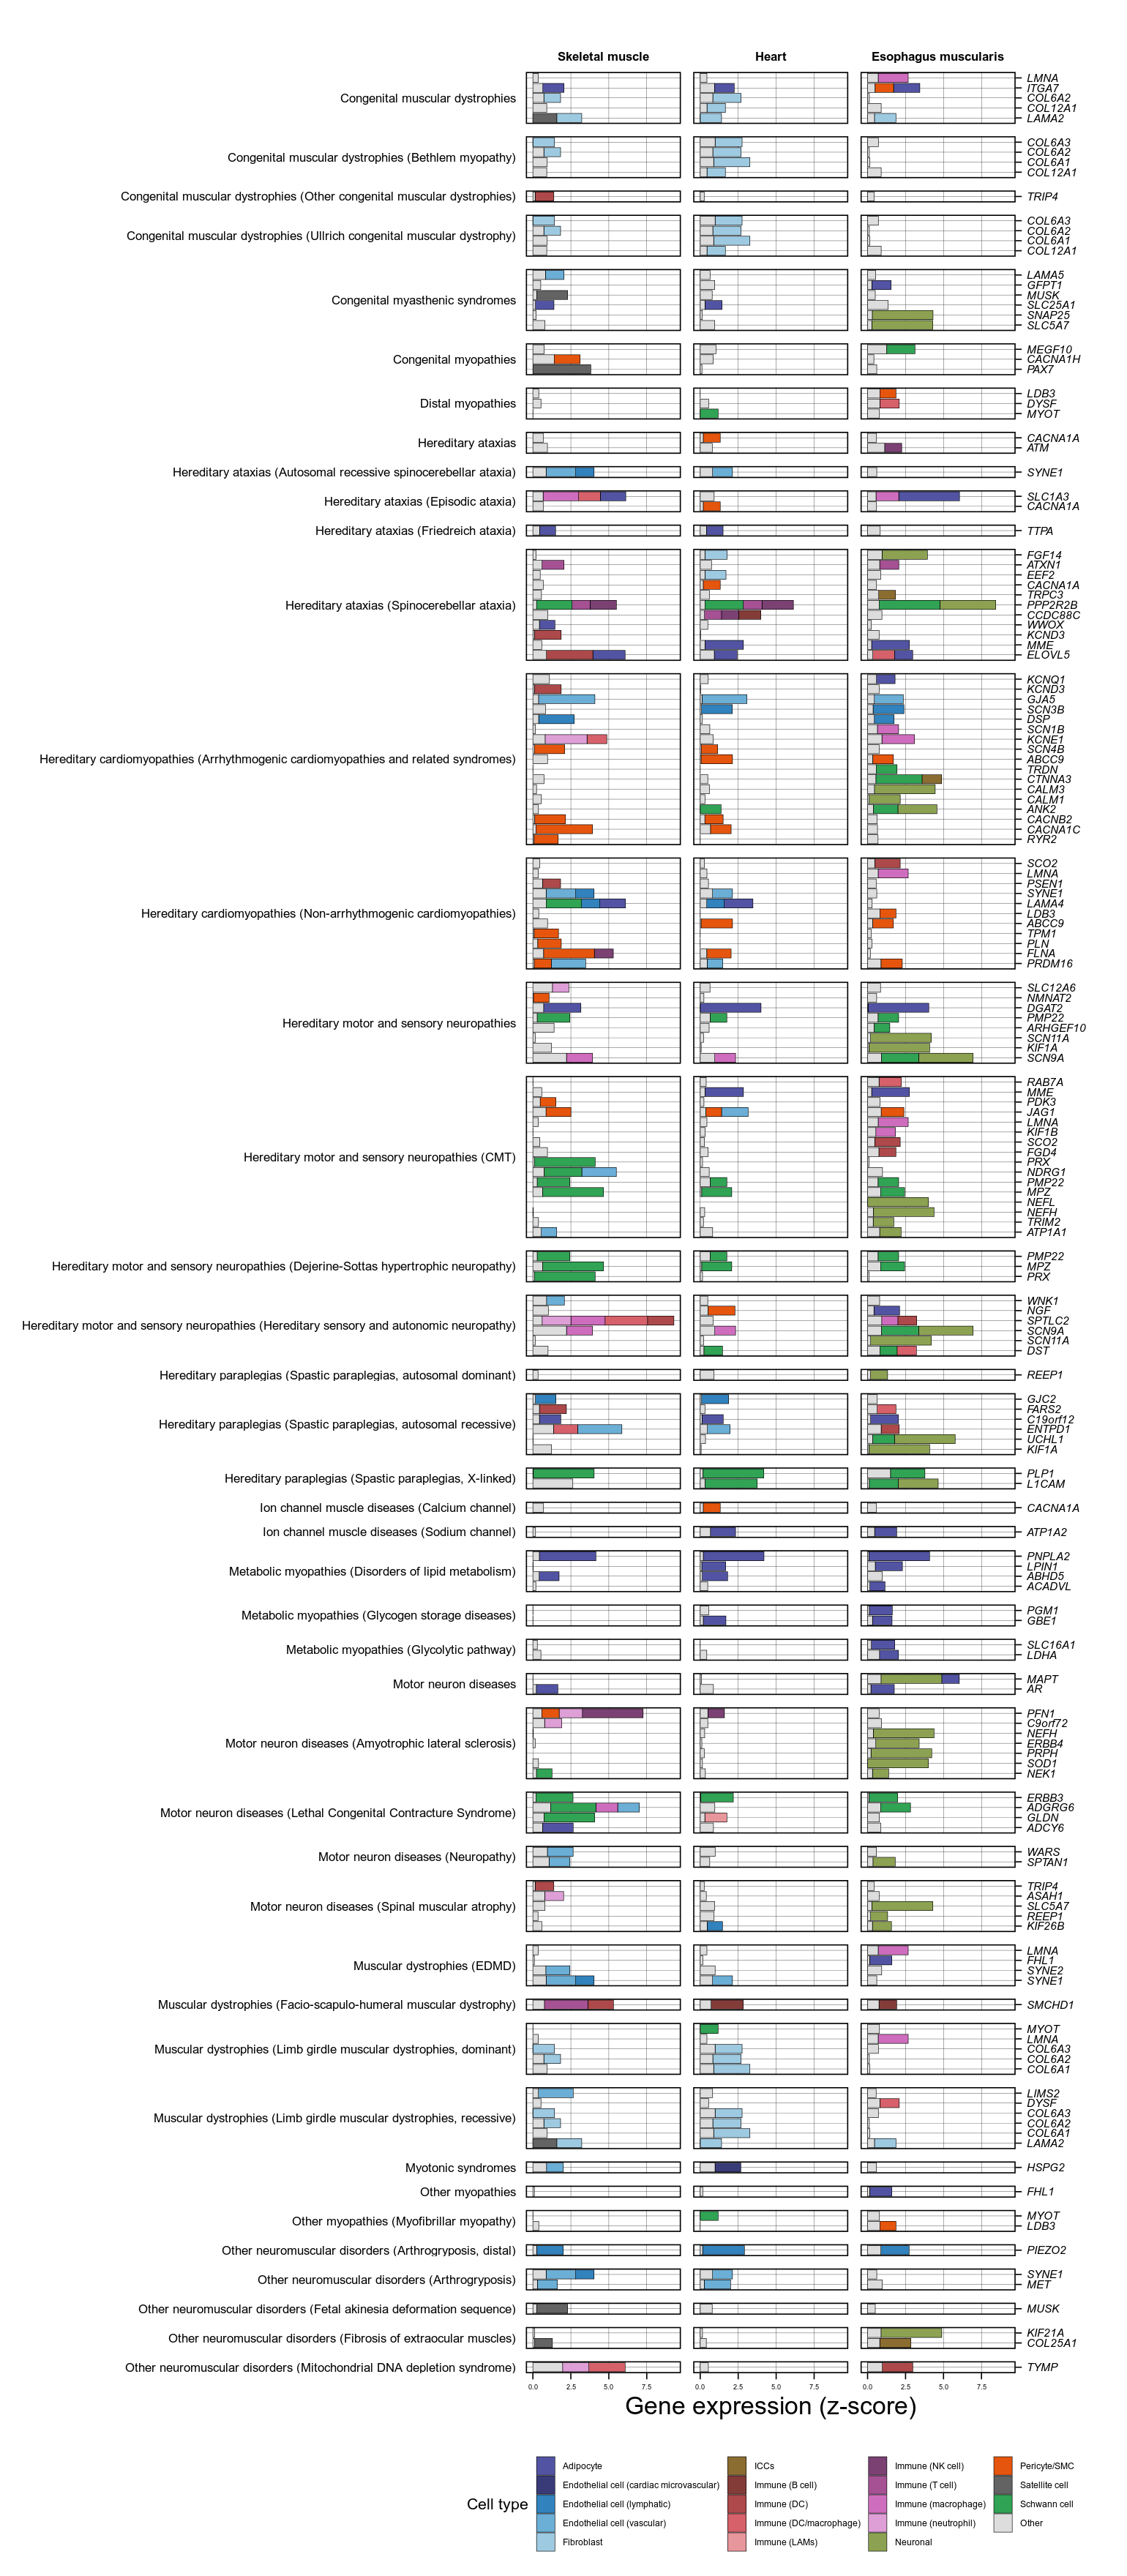

In [814]:
%%R -i df -i color_keys -i color_values -w 7 -h 16 -u in -r 220

library(ggplot2)

color_list = color_values
names(color_list) = color_keys

g = (
    ggplot(data=df, mapping=aes(x=disease_group_subgroup_gene, y=spring_score_nonzero, fill=celltype)) + 
    #geom_bar(stat='identity', data=df[!df$sig_and_pos,], fill='gray', alpha=0.5) +    
    geom_bar(stat='identity', color='black', size=0.1) + 
    facet_grid(`Disease group wrap` ~ tissue, scales='free_y', space='free_y', switch='y') + 
    scale_fill_manual(values=color_list) + 
    scale_x_discrete(position = "top", labels=function(x){sapply(strsplit(x, '|', fixed=T), `[[`, 2)}) +
    theme_linedraw() + 
    labs(title='', y='Gene expression (z-score)', x='', fill='Cell type') +
    guides(
        fill = guide_legend(nrow=5)
    ) +
    theme(
          plot.title=element_text(size=8),
          axis.text.x=element_text(size=3),
          axis.text.y=element_text(size=5, face='italic'),                
          panel.grid.minor.x=element_blank(),
          strip.text.x = element_text(size=5.5, color='black', face='bold'),
          strip.text.y.left = element_text(size=5.5, color='black', angle = 0, hjust=1),        
          strip.background.y=element_blank(), #rect(color='white', fill='white'),
          strip.background.x=element_blank(), #rect(color='black', fill='white'),        
          legend.position="bottom",
          legend.title=element_text(size=7), 
          legend.text=element_text(size=4),
          legend.key.size = unit(0.3, "cm"),
         ) + 
    coord_flip()
)

print(g)

ggsave('figures/Figure-S14.pdf', w=7, h=16, useDingbats=F)

In [813]:
len(set([x[1] for x in df.disease_group_subgroup_gene.str.split('|')]))

125

## Receptor ligand integration

In [449]:
de = pd.concat([v.assign(tissue=k) for k,v in de_dict_granular.items()], axis=0)
de = de.drop(columns='marker').drop_duplicates()
#de = de[de.tissue.isin(['Esophagus muscularis', 'Skeletal muscle', 'Heart'])].copy()
de = de.rename(columns={'group': 'celltype', 'genes': 'gene'})
de['spring_score_nonzero'] = np.maximum(de.spring_score, 0)

In [450]:
de

celltype      gene       tstat          pvals  \
0                Adipocyte     ACACB  116.209862   0.000000e+00   
1                Adipocyte      FASN   73.344101   0.000000e+00   
2                Adipocyte     LPIN1   69.438484   0.000000e+00   
3                Adipocyte    MLXIPL   68.346466   0.000000e+00   
4                Adipocyte      EBF1   65.418724   0.000000e+00   
...                    ...       ...         ...            ...   
342183  Unknown (SFN-GJA1)     ARL15  -21.668438   1.337465e-83   
342184  Unknown (SFN-GJA1)   LDLRAD4  -21.863287   2.175499e-95   
342185  Unknown (SFN-GJA1)  RALGAPA2  -23.831993  2.072160e-100   
342186  Unknown (SFN-GJA1)     PTPRM  -27.015974  1.296138e-120   
342187  Unknown (SFN-GJA1)    CADPS2  -27.218916  2.230389e-152   

            pvals_fdr     log2FC  fraction_group  fraction_rest  \
0        0.000000e+00   7.378525        0.989749       0.050786   
1        0.000000e+00   5.751882        0.904897       0.067257   
2        0.000000e+00   5.585775        0.893508       0.073122   
3        0.000000e+00   7.598430        0.858200       0.010232   
4        0.000000e+00   4.084034        0.900911       0.123409   
...               ...        ...             ...            ...   
342183   2.971848e-80  -3.627186        0.035714       0.297270   
342184   8.459427e-92  -5.113667        0.006494       0.164973   
342185   1.074346e-96  -4.127691        0.032468       0.301654   
342186  1.008006e-116  -3.929472        0.032468       0.302251   
342187  3.469146e-148 -26.890396        0.000000       0.142459   

        mean_expressed  spring_score  tissue  significant  \
0             2.252317      1.921656  Breast         True   
1             1.597452      1.691138  Breast         True   
2             1.470923      1.667113  Breast         True   
3             1.058530      1.727318  Breast         True   
4             1.322609      1.401352  Breast         True   
...                ...           ...     ...          ...   
342183        0.730008     -0.456783    Skin        False   
342184        0.693147     -0.370510    Skin        False   
342185        0.693147     -0.473259    Skin        False   
342186        0.774240     -0.544440    Skin        False   
342187        0.000000     -0.372292    Skin        False   

        spring_score_nonzero  
0                   1.921656  
1                   1.691138  
2                   1.667113  
3                   1.727318  
4                   1.401352  
...                      ...  
342183              0.000000  
342184              0.000000  
342185              0.000000  
342186              0.000000  
342187              0.000000  

[2814679 rows x 13 columns]

In [451]:
t2T = adata.obs[['Tissue', 'tissue']].drop_duplicates().reset_index(drop=True).set_index('tissue')['Tissue'].to_dict()
t2T

{'skeletalmuscle': 'Skeletal muscle',
 'breast': 'Breast',
 'esophagusmucosa': 'Esophagus mucosa',
 'esophagusmuscularis': 'Esophagus muscularis',
 'heart': 'Heart',
 'lung': 'Lung',
 'prostate': 'Prostate',
 'skin': 'Skin'}

In [28]:
cpdb_results = pd.read_pickle('../cellphonedb_results_20201230.pkl')
cpdb_results['tissue'] = cpdb_results['tissue'].map(t2T)

cpdb_results = cpdb_results[cpdb_results.pval<0.1].reset_index(drop=True)

cpdb_results['celltype_pair'] = cpdb_results['celltype_pair'].str.replace('Unknown (NRG1-NRG3)', 'Endothelial cell (cardiac microvascular)', regex=False)

cpdb_results['celltype_a'] = [new_granular.get(x.split('|')[0], x.split('|')[0]) for x in cpdb_results['celltype_pair']]
cpdb_results['celltype_b'] = [new_granular.get(x.split('|')[1], x.split('|')[1]) for x in cpdb_results['celltype_pair']]

cpdb_results['celltype_pair'] = cpdb_results['celltype_a'] + '|' + cpdb_results['celltype_b']

In [29]:
cpdb_results.head()

id_cp_interaction interacting_pair      partner_a      partner_b gene_a  \
0   CPI-SS0755A26DD       FGF1_FGFR1  simple:P05230  simple:P11362   FGF1   
1   CPI-SS068C742A1      FGF1_TGFBR3  simple:P05230  simple:Q03167   FGF1   
2   CPI-SS088A0A760        EGFR_COPA  simple:P00533  simple:P53621   EGFR   
3   CPI-SS0DE0A486F       NRP1_VEGFA  simple:O14786  simple:P15692   NRP1   
4   CPI-SS033E6DE7E       NRP1_VEGFB  simple:O14786  simple:P49765   NRP1   

   gene_b  secreted  receptor_a  receptor_b annotation_strategy  is_integrin  \
0   FGFR1      True       False        True             curated        False   
1  TGFBR3      True       False        True        InnateDB-All        False   
2    COPA      True        True       False        InnateDB-All        False   
3   VEGFA      True        True       False             curated        False   
4   VEGFB      True        True       False             curated        False   

         celltype_pair   mean  pval  tissue  significant  neglogpval  
0  Adipocyte|Adipocyte  0.632   0.0  Breast         True        15.0  
1  Adipocyte|Adipocyte  0.998   0.0  Breast         True        15.0  
2  Adipocyte|Adipocyte  0.688   0.0  Breast         True        15.0  
3  Adipocyte|Adipocyte  1.185   0.0  Breast         True        15.0  
4  Adipocyte|Adipocyte  0.333   0.0  Breast         True        15.0

In [32]:
cpdb_results[cpdb_results.significant].drop(columns=['neglogpval']).to_excel('../Table S4.xlsx', index=False)

In [454]:
#pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [455]:
cpdb_results = cpdb_results.merge(de.rename(columns={x:f'{x}_DE_gene_a' for x in de.columns}), 
                   left_on=['tissue', 'celltype_a', 'gene_a'], 
                   right_on=['tissue_DE_gene_a', 'celltype_DE_gene_a', 'gene_DE_gene_a'],
                   how='left').drop(columns=['celltype_DE_gene_a', 'gene_DE_gene_a', 'tissue_DE_gene_a'])

In [456]:
cpdb_results = cpdb_results.merge(de.rename(columns={x:f'{x}_DE_gene_b' for x in de.columns}), 
                   left_on=['tissue', 'celltype_b', 'gene_b'], 
                   right_on=['tissue_DE_gene_b', 'celltype_DE_gene_b', 'gene_DE_gene_b'],
                   how='left').drop(columns=['celltype_DE_gene_b', 'gene_DE_gene_b', 'tissue_DE_gene_b'])

In [457]:
cpdb_results

id_cp_interaction      interacting_pair      partner_a  \
0       CPI-SS0755A26DD            FGF1_FGFR1  simple:P05230   
1       CPI-SS068C742A1           FGF1_TGFBR3  simple:P05230   
2       CPI-SS088A0A760             EGFR_COPA  simple:P00533   
3       CPI-SS0DE0A486F            NRP1_VEGFA  simple:O14786   
4       CPI-SS033E6DE7E            NRP1_VEGFB  simple:O14786   
...                 ...                   ...            ...   
46483   CPI-SC08A98E7D4   COL7A1_a2b1 complex  simple:Q02388   
46484   CPI-SC01E9FAC20  COL16A1_a2b1 complex  simple:Q07092   
46485   CPI-SC0CE6F5084  COL27A1_a2b1 complex  simple:Q8IZC6   
46486   CPI-SC06873D10F  COL17A1_a2b1 complex  simple:Q9UMD9   
46487   CPI-SC0D9B795CC     CDH1_a2b1 complex  simple:P12830   

                  partner_b   gene_a          gene_b  secreted  receptor_a  \
0             simple:P11362     FGF1           FGFR1      True       False   
1             simple:Q03167     FGF1          TGFBR3      True       False   
2             simple:P53621     EGFR            COPA      True        True   
3             simple:P15692     NRP1           VEGFA      True        True   
4             simple:P49765     NRP1           VEGFB      True        True   
...                     ...      ...             ...       ...         ...   
46483  complex:a2b1 complex   COL7A1  (ITGB1, ITGA2)      True       False   
46484  complex:a2b1 complex  COL16A1  (ITGB1, ITGA2)      True       False   
46485  complex:a2b1 complex  COL27A1  (ITGB1, ITGA2)      True       False   
46486  complex:a2b1 complex  COL17A1  (ITGB1, ITGA2)      True       False   
46487  complex:a2b1 complex     CDH1  (ITGB1, ITGA2)     False       False   

       receptor_b annotation_strategy  is_integrin  \
0            True             curated        False   
1            True        InnateDB-All        False   
2           False        InnateDB-All        False   
3           False             curated        False   
4           False             curated        False   
...           ...                 ...          ...   
46483       False             curated         True   
46484       False             curated         True   
46485       False             curated         True   
46486       False             curated         True   
46487       False             curated         True   

                               celltype_pair   mean   pval  tissue  \
0                        Adipocyte|Adipocyte  0.632  0.000  Breast   
1                        Adipocyte|Adipocyte  0.998  0.000  Breast   
2                        Adipocyte|Adipocyte  0.688  0.000  Breast   
3                        Adipocyte|Adipocyte  1.185  0.000  Breast   
4                        Adipocyte|Adipocyte  0.333  0.000  Breast   
...                                      ...    ...    ...     ...   
46483  Unknown (SFN-GJA1)|Unknown (SFN-GJA1)  0.520  0.000    Skin   
46484  Unknown (SFN-GJA1)|Unknown (SFN-GJA1)  0.291  0.060    Skin   
46485  Unknown (SFN-GJA1)|Unknown (SFN-GJA1)  0.312  0.081    Skin   
46486  Unknown (SFN-GJA1)|Unknown (SFN-GJA1)  0.953  0.000    Skin   
46487  Unknown (SFN-GJA1)|Unknown (SFN-GJA1)  0.361  0.000    Skin   

       significant  neglogpval          celltype_a          celltype_b  \
0             True   15.000000           Adipocyte           Adipocyte   
1             True   15.000000           Adipocyte           Adipocyte   
2             True   15.000000           Adipocyte           Adipocyte   
3             True   15.000000           Adipocyte           Adipocyte   
4             True   15.000000           Adipocyte           Adipocyte   
...            ...         ...                 ...                 ...   
46483         True   15.000000  Unknown (SFN-GJA1)  Unknown (SFN-GJA1)   
46484        False    1.221849  Unknown (SFN-GJA1)  Unknown (SFN-GJA1)   
46485        False    1.091515  Unknown (SFN-GJA1)  Unknown (SFN-GJA1)   
46486         True   15.000000  Unknown (SFN-GJA1)  Unknown (SFN-GJA1)

In [458]:
cpdb_results['spring_score_mean'] = (cpdb_results['spring_score_DE_gene_a'] + cpdb_results['spring_score_DE_gene_b']) / 2
cpdb_results['spring_score_min'] = np.minimum(cpdb_results['spring_score_DE_gene_a'], cpdb_results['spring_score_DE_gene_b'])
cpdb_results['spring_score_max'] = np.maximum(cpdb_results['spring_score_DE_gene_a'], cpdb_results['spring_score_DE_gene_b'])
cpdb_results['log2FC_mean'] = (cpdb_results['log2FC_DE_gene_a'] + cpdb_results['log2FC_DE_gene_b']) / 2
#cpdb_results.drop(columns=['celltype_a', 'celltype_b'], inplace=True)

In [459]:
with pd.ExcelWriter('cpdb_de_20201230.xlsx') as writer:  
    for t in sorted(cpdb_results.tissue.unique()):
        cpdb_results[cpdb_results.tissue == t].drop(columns=['tissue']).to_excel(writer, sheet_name=t, index=None)

In [460]:
cpdb_results[cpdb_results.interacting_pair.str.contains('SPP1')]

id_cp_interaction   interacting_pair      partner_a  \
1249    CPI-SS02AB0C3E0          SPP1_CD44  simple:P10451   
1271    CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   
1279    CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   
1287    CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   
1300    CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   
...                 ...                ...            ...   
39931   CPI-SS02AB0C3E0          SPP1_CD44  simple:P10451   
39971   CPI-SS02AB0C3E0          SPP1_CD44  simple:P10451   
40036   CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   
40042   CPI-SS02AB0C3E0          SPP1_CD44  simple:P10451   
40085   CPI-SC01AB9BED7  SPP1_a9b1 complex  simple:P10451   

                  partner_b gene_a          gene_b  secreted  receptor_a  \
1249          simple:P16070   SPP1            CD44      True       False   
1271   complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   
1279   complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   
1287   complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   
1300   complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   
...                     ...    ...             ...       ...         ...   
39931         simple:P16070   SPP1            CD44      True       False   
39971         simple:P16070   SPP1            CD44      True       False   
40036  complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   
40042         simple:P16070   SPP1            CD44      True       False   
40085  complex:a9b1 complex   SPP1  (ITGB1, ITGA9)      True       False   

       receptor_b           annotation_strategy  is_integrin  \
1249         True  I2D,IMEx,InnateDB-All,IntAct        False   
1271        False                       curated         True   
1279        False                       curated         True   
1287        False                       curated         True   
1300        False                       curated         True   
...           ...                           ...          ...   
39931        True  I2D,IMEx,InnateDB-All,IntAct        False   
39971        True  I2D,IMEx,InnateDB-All,IntAct        False   
40036       False                       curated         True   
40042        True  I2D,IMEx,InnateDB-All,IntAct        False   
40085       False                       curated         True   

                                                celltype_pair   mean  pval  \
1249                         Immune (macrophage II)|Adipocyte  0.632  0.00   
1271      Immune (macrophage II)|Endothelial cell (lymphatic)  0.951  0.00   
1279     Immune (macrophage II)|Endothelial cell (vascular) I  0.755  0.00   
1287    Immune (macrophage II)|Endothelial cell (vascular) II  0.675  0.00   
1300   Immune (macrophage II)|Endothelial cell (vascular) III  0.766  0.00   
...                                                       ...    ...   ...   
39931                             Schwann cell|Neuroendocrine  0.529  0.06   
39971                               Schwann cell|Pericyte/SMC  0.612  0.00   
40036                               Schwann cell|Pericyte/SMC  0.486  0.00   
40042                               Schwann cell|Schwann cell  0.823  0.00   
40085                               Schwann cell|Schwann cell  0.498  0.00   

         tissue  significant  neglogpval              celltype_a  \
1249     Breast         True   15.000000  Immune (macrophage II)   
1271     Breast         True   15.000000  Immune (macrophage II)   
1279     Breast         True   15.000000  Immune (macrophage II)   
1287     Breast         True   15.000000  Immune (macrophage II)   
1300     Breast         True   15.000000  Immune (macrophage II)   
...         ...          ...         ...                     ...   
39931  Prostate        False    1.221849            Schwann cell   
39971  Prostate         True   15.000000            Schwann cell   
40036  Prostate         True   15.000000  

In [461]:
lams = cpdb_results[cpdb_results.tissue == 'Heart'][cpdb_results[cpdb_results.tissue == 'Heart'].celltype_pair.str.contains('LAM')]

In [462]:
lams.sort_values('spring_score_mean', ascending=False).head(20)

id_cp_interaction    interacting_pair       partner_a      partner_b  \
20045   CPI-SS06E42DB13       ADIPOQ_CLEC2D   simple:Q15848  simple:Q9UHP7   
23239   CPI-SS0E2863F09   TNFRSF17_TNFSF13B   simple:Q02223  simple:Q9Y275   
23637   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23705   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23865   CPI-SS0A021DB6E           CCL5_CCR1   simple:P13501  simple:P32246   
23676   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23617   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23687   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23603   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23662   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23778   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23955   CPI-SS08991B378           CD6_ALCAM   simple:P30203  simple:Q13740   
23559   CPI-SS02AB0C3E0           SPP1_CD44   simple:P10451  simple:P16070   
23244   CPI-SS08330207B       BTLA_TNFRSF14   simple:Q7Z6A9  simple:Q92956   
23793   CPI-SS076BC3BA6       HLA-DPB1_NRG1  simple:HLADPB1  simple:Q02297   
20404   CPI-SS03A3EE72E          FLT4_PDGFC   simple:P35916  simple:Q9NRA1   
23612   CPI-SS06CBC985C            LTBR_LTB   simple:P36941  simple:Q06643   
23240   CPI-SS09648FAA9  TNFRSF13C_TNFSF13B   simple:Q96RJ3  simple:Q9Y275   
23863   CPI-SS0E292C126        KLRB1_CLEC2D   simple:Q12918  simple:Q9UHP7   
23609   CPI-SS0CBC7840D          PTPRC_CD22   simple:P08575  simple:P20273   

          gene_a    gene_b  secreted  receptor_a  receptor_b  \
20045     ADIPOQ    CLEC2D      True       False        True   
23239   TNFRSF17  TNFSF13B      True        True       False   
23637       SPP1      CD44      True       False        True   
23705       SPP1      CD44      True       False        True   
23865       CCL5      CCR1      True       False        True   
23676       SPP1      CD44      True       False        True   
23617       SPP1      CD44      True       False        True   
23687       SPP1      CD44      True       False        True   
23603       SPP1      CD44      True       False        True   
23662       SPP1      CD44      True       False        True   
23778       SPP1      CD44      True       False        True   
23955        CD6     ALCAM      True       False       False   
23559       SPP1      CD44      True       False        True   
23244       BTLA  TNFRSF14     False        True        True   
23793   HLA-DPB1      NRG1      True        True        True   
20404       FLT4     PDGFC      True        True       False   
23612       LTBR       LTB     False        True       False   
23240  TNFRSF13C  TNFSF13B      True        True       False   
23863      KLRB1    CLEC2D     False        True        True   
23609      PTPRC      CD22     False       False        True   

                annotation_strategy  is_integrin  \
20045                   IMEx,IntAct        False   
23239                       curated        False   
23637  I2D,IMEx,InnateDB-All,IntAct        False   
23705  I2D,IMEx,InnateDB-All,IntAct        False   
23865                       curated        False   
23676  I2D,IMEx,InnateDB-All,IntAct        False   
23617  I2D,IMEx,InnateDB-All,IntAct        False   
23687  I2D,IMEx,InnateDB-All,IntAct        False   
23603  I2D,IMEx,InnateDB-All,IntAct        False   
23662  I2D,IMEx,InnateDB-All,IntAct        False   
23778  I2D,IMEx,InnateDB-All,IntAct        False   
23955                       curated        False   
23559  I2D,IMEx,InnateDB-All,IntAct        False   
23244       guidetopharmacology.org        False   
23793                  InnateDB-All        False   
20404       guidetopharmacology.org        False   
23612                       curated        False   
23240       guidetopharmacology.org        False   
23863                       curate

## Plot myocyte interactions

In [463]:
muscle_disease_genes = muscle_diseases.Gene.unique()

In [464]:
muscle_ina = np.array([np.any(np.isin(x if isinstance(x, tuple) else [x], muscle_disease_genes)) for x in cpdb_results.gene_a])
muscle_inb = np.array([np.any(np.isin(x if isinstance(x, tuple) else [x], muscle_disease_genes)) for x in cpdb_results.gene_b])

In [465]:
idx = (muscle_ina | muscle_inb) & (~cpdb_results.is_integrin) & (cpdb_results.tissue.isin(['Skeletal muscle', 'Heart', 'Esophagus muscularis'])) & (cpdb_results.celltype_pair.str.contains('Myocyte', case=False))
cpdb_results[idx][['interacting_pair', 'gene_a', 'gene_b']].drop_duplicates()

interacting_pair           gene_a           gene_b
17773                 CD46_JAG1             CD46             JAG1
17789   TGFB1_TGFbeta receptor2            TGFB1  (TGFBR2, ACVR1)
20086                NRG2_ERBB4             NRG2            ERBB4
20444                NRG3_ERBB4             NRG3            ERBB4
20458   TGFB2_TGFbeta receptor2            TGFB2  (TGFBR2, ACVR1)
21302               JAG1_NOTCH2             JAG1           NOTCH2
23719               LGALS9_DAG1           LGALS9             DAG1
24229          ACVR1_BMPR2_BMP6   (ACVR1, BMPR2)             BMP6
24230   ACVR_1A2A receptor_BMP6  (ACVR1, ACVR2A)             BMP6
24369                NRG1_ERBB4             NRG1            ERBB4
24414          ACVR1_BMPR2_BMP5   (ACVR1, BMPR2)             BMP5
24415   ACVR_1A2A receptor_BMP5  (ACVR1, ACVR2A)             BMP5
24446                NRG2_ERBB3             NRG2            ERBB3
24487  ACVR_1A2A receptor_INHBA  (ACVR1, ACVR2A)            INHBA
24562                 NPPA_NPR3             NPPA             NPR3
24598                 NPPA_NPR1             NPPA             NPR1
25518                ERBB3_NRG1            ERBB3             NRG1
41997                ERBB4_NRG4            ERBB4             NRG4

In [466]:
muscle_pairs = sorted(cpdb_results[idx].interacting_pair.unique())
muscle_pairs

['ACVR1_BMPR2_BMP5',
 'ACVR1_BMPR2_BMP6',
 'ACVR_1A2A receptor_BMP5',
 'ACVR_1A2A receptor_BMP6',
 'ACVR_1A2A receptor_INHBA',
 'CD46_JAG1',
 'ERBB3_NRG1',
 'ERBB4_NRG4',
 'JAG1_NOTCH2',
 'LGALS9_DAG1',
 'NPPA_NPR1',
 'NPPA_NPR3',
 'NRG1_ERBB4',
 'NRG2_ERBB3',
 'NRG2_ERBB4',
 'NRG3_ERBB4',
 'TGFB1_TGFbeta receptor2',
 'TGFB2_TGFbeta receptor2']

In [467]:
cpdb_results[cpdb_results.interacting_pair.isin(muscle_pairs)].sort_values('spring_score_mean', ascending=False)

id_cp_interaction         interacting_pair      partner_a  \
12291   CPI-SS0BD5C2A23               NRG1_ERBB4  simple:Q02297   
2431    CPI-SS0D5E30C6C               NRG3_ERBB4  simple:P56975   
10914   CPI-SS0E063192D               NRG2_ERBB4  simple:O14511   
14529   CPI-SS0E063192D               NRG2_ERBB4  simple:O14511   
9539    CPI-SS0BD5C2A23               NRG1_ERBB4  simple:Q02297   
...                 ...                      ...            ...   
43187   CPI-SC0984894BC  TGFB1_TGFbeta receptor2  simple:P01137   
44632   CPI-SC0984894BC  TGFB1_TGFbeta receptor2  simple:P01137   
44750   CPI-SC0984894BC  TGFB1_TGFbeta receptor2  simple:P01137   
45421   CPI-SC0984894BC  TGFB1_TGFbeta receptor2  simple:P01137   
45683   CPI-SC032246C72  TGFB2_TGFbeta receptor2  simple:P61812   

                       partner_b gene_a           gene_b  secreted  \
12291              simple:Q15303   NRG1            ERBB4      True   
2431               simple:Q15303   NRG3            ERBB4      True   
10914              simple:Q15303   NRG2            ERBB4      True   
14529              simple:Q15303   NRG2            ERBB4      True   
9539               simple:Q15303   NRG1            ERBB4      True   
...                          ...    ...              ...       ...   
43187  complex:TGFbeta receptor2  TGFB1  (TGFBR2, ACVR1)      True   
44632  complex:TGFbeta receptor2  TGFB1  (TGFBR2, ACVR1)      True   
44750  complex:TGFbeta receptor2  TGFB1  (TGFBR2, ACVR1)      True   
45421  complex:TGFbeta receptor2  TGFB1  (TGFBR2, ACVR1)      True   
45683  complex:TGFbeta receptor2  TGFB2  (TGFBR2, ACVR1)      True   

       receptor_a  receptor_b annotation_strategy  is_integrin  \
12291        True        True             curated        False   
2431        False        True             curated        False   
10914       False        True             curated        False   
14529       False        True             curated        False   
9539         True        True             curated        False   
...           ...         ...                 ...          ...   
43187       False        True             curated        False   
44632       False        True             curated        False   
44750       False        True             curated        False   
45421       False        True             curated        False   
45683       False        True             curated        False   

                                     celltype_pair   mean  pval  \
12291                Neuroendocrine|Neuroendocrine  3.324   0.0   
2431   Endothelial cell (lymphatic)|Neuroendocrine  2.419   0.0   
10914                Mucous cell II|Neuroendocrine  1.960   0.0   
14529                  Schwann cell|Neuroendocrine  1.961   0.0   
9539         Immune (macrophage II)|Neuroendocrine  2.084   0.0   
...                                            ...    ...   ...   
43187       Endothelial cell (lymphatic)|Adipocyte  0.262   0.0   
44632             Immune (DC/macrophage)|Adipocyte  0.292   0.0   
44750                Immune (Langerhans)|Adipocyte  0.394   0.0   
45421                    Pericyte/SMC II|Adipocyte  0.343   0.0   
45683     Sebaceous gland cell (CYP4F3+)|Adipocyte  0.235   0.0   

                 tissue  significant  neglogpval  \
12291  Esophagus mucosa         True        15.0   
2431   Esophagus mucosa         True        15.0   
10914  Esophagus mucosa         True        15.0   
14529  Esophagus mucosa         True        15.0   
9539   Esophagus mucosa         True        15.0   
...                 ...          ...         ...   
43187              Skin         True        15.0   
44632              Skin         True        15.0   
44750              Skin         True        15.0   
45421              Skin         True        15.0   
45683              Skin         True        15.0   

                           celltype_a      celltype_b  tstat_DE_gene_a  \
12291                  Neuroendocrine  Neuroendocrine         5

In [468]:
table = cpdb_results[
    cpdb_results.interacting_pair.isin(muscle_pairs) & 
    (cpdb_results.tissue.isin(['Skeletal muscle', 'Esophagus muscularis', 'Heart'])) &
    (cpdb_results.celltype_pair.str.contains('Myocyte', case=False)) &
    (~cpdb_results.interacting_pair.str.contains('TGF'))
]

table

id_cp_interaction interacting_pair      partner_a      partner_b gene_a  \
17773   CPI-SS01A07768A        CD46_JAG1  simple:P15529  simple:P78504   CD46   
17825   CPI-SS01A07768A        CD46_JAG1  simple:P15529  simple:P78504   CD46   
18038   CPI-SS01A07768A        CD46_JAG1  simple:P15529  simple:P78504   CD46   
18062   CPI-SS01A07768A        CD46_JAG1  simple:P15529  simple:P78504   CD46   
18136   CPI-SS01A07768A        CD46_JAG1  simple:P15529  simple:P78504   CD46   
...                 ...              ...            ...            ...    ...   
42474   CPI-SS074CF011C       ERBB4_NRG4  simple:Q15303  simple:Q8WWG1  ERBB4   
42478   CPI-SS074CF011C       ERBB4_NRG4  simple:Q15303  simple:Q8WWG1  ERBB4   
42481   CPI-SS074CF011C       ERBB4_NRG4  simple:Q15303  simple:Q8WWG1  ERBB4   
42773   CPI-SS0E063192D       NRG2_ERBB4  simple:O14511  simple:Q15303   NRG2   
42925   CPI-SS0BF9FA3F2       ERBB3_NRG1  simple:P21860  simple:Q02297  ERBB3   

      gene_b  secreted  receptor_a  receptor_b annotation_strategy  \
17773   JAG1     False        True       False             curated   
17825   JAG1     False        True       False             curated   
18038   JAG1     False        True       False             curated   
18062   JAG1     False        True       False             curated   
18136   JAG1     False        True       False             curated   
...      ...       ...         ...         ...                 ...   
42474   NRG4      True        True       False             curated   
42478   NRG4      True        True       False             curated   
42481   NRG4      True        True       False             curated   
42773  ERBB4      True       False        True             curated   
42925   NRG1      True        True        True             curated   

       is_integrin  \
17773        False   
17825        False   
18038        False   
18062        False   
18136        False   
...            ...   
42474        False   
42478        False   
42481        False   
42773        False   
42925        False   

                                                          celltype_pair  \
17773                        Myocyte (smooth muscle TAGLN lo)|Adipocyte   
17825  Myocyte (smooth muscle TAGLN lo)|Endothelial cell (vascular) III   
18038                   Myocyte (smooth muscle TAGLN lo)|Pericyte/SMC I   
18062                  Myocyte (smooth muscle TAGLN lo)|Pericyte/SMC II   
18136           Myocyte (smooth muscle)|Endothelial cell (vascular) III   
...                                                                 ...   
42474                               Pericyte/SMC I|Myocyte (sk. muscle)   
42478                              Pericyte/SMC I|Myocyte (fast-twitch)   
42481                                 Pericyte/SMC I|Myocyte (NMJ-rich)   
42773                                 Satellite cell|Myocyte (NMJ-rich)   
42925                                   Schwann cell|Myocyte (NMJ-rich)   

        mean  pval                tissue  significant  neglogpval  \
17773  0.271  0.02  Esophagus muscularis        False     1.69897   
17825  0.338  0.00  Esophagus muscularis         True    15.00000   
18038  0.625  0.00  Esophagus muscularis         True    15.00000   
18062  0.479  0.00  Esophagus muscularis         True    15.00000   
18136  0.315  0.00  Esophagus muscularis         True    15.00000   
...      ...   ...                   ...          ...         ...   
42474  0.480  0.00       Skeletal muscle         True    15.00000   
42478  0.475  0.00       Skeletal muscle         True    15.00000   
42481  0.484  0.00       Skeletal muscle         True    15.00000   
42773  1.023  0.00       Skeletal muscle         True    15.00000   
42925  0.490  0.00       Skeletal muscle         True    15.00000   

                             celltype_a                       celltype_b  \
17773  Myocyte (smooth muscle TAGLN lo)                        Adipocyte   
17825  Myocyte (smooth muscle TAGLN lo)  Endo

In [469]:
table.receptor_a.loc[table.gene_a == 'NRG1'] = False
table.receptor_b.loc[table.gene_b == 'NRG1'] = False

In [470]:
genes  = [[x] if isinstance(x, str) else list(x) for x in table.gene_b.values.tolist() + table.gene_a.values.tolist() ]
genes = list(set([y for x in genes for y in x]))
genes

['NRG3',
 'LGALS9',
 'BMP5',
 'NRG4',
 'NRG1',
 'INHBA',
 'CD46',
 'JAG1',
 'NPPA',
 'ACVR2A',
 'NRG2',
 'ERBB3',
 'NPR3',
 'BMP6',
 'DAG1',
 'BMPR2',
 'ERBB4',
 'NOTCH2',
 'ACVR1',
 'NPR1']

In [471]:
muscle_df = muscle_diseases[muscle_diseases.Gene.isin(genes)][['Gene', 'Disease group', 'Disease subgroup', 'Disease phenotype']]
muscle_df

Gene                              Disease group  \
38    DAG1                       Muscular dystrophies   
96    DAG1            Congenital muscular dystrophies   
220  ACVR1                           Other myopathies   
423   NPPA                Hereditary cardiomyopathies   
542  ERBB4                      Motor neuron diseases   
557  ERBB3                      Motor neuron diseases   
730   JAG1  Hereditary motor and sensory neuropathies   

                                                 Disease subgroup  \
38                    Limb girdle muscular dystrophies, recessive   
96   Congenital muscle dystrophies due to defective glycosylation   
220                                                                 
423         Arrhythmogenic cardiomyopathies and related syndromes   
542                                 Amyotrophic lateral sclerosis   
557                        Lethal congenital contracture syndrome   
730                                                           Cmt   

                                                                       Disease phenotype  
38                                                                        LGMDR16 - (AR)  
96   Congenital muscular dystrophy with hypoglycosylation of dystroglycan type A9 - (AR)  
220                                         Fibrodysplasia ossificans progressiva - (AD)  
423                                                        Atrial fibrillation, 6 - (AD)  
542                                              Amyotrophic lateral sclerosis 19 - (AD)  
557                                      Lethal Congenital Contracture Syndrome 2 - (AR)  
730                          Charcot-Marie-Tooth disease, axonal, related to JAG1 - (AD)

In [472]:
def simplify_ct(x):
    if x.endswith(' I'):
        return x[:-2]
    if x.endswith(' II'):
        return x[:-3]
    if x.endswith(' III'):
        return x[:-4]
    if x.endswith(' I)'):
        return f'{x[:-3]})'    
    if x.endswith(' II)'):
        return f'{x[:-4]})'
    return x

table.celltype_a = [simplify_ct(x) for x in table.celltype_a]
table.celltype_b = [simplify_ct(x) for x in table.celltype_b]

## ggraph

In [473]:
df = table[['gene_a', 'gene_b', 'celltype_a', 'celltype_b', 'tissue', 'receptor_a', 'receptor_b', 
            'significant_DE_gene_a', 'significant_DE_gene_b', 'spring_score_nonzero_DE_gene_a', 'spring_score_nonzero_DE_gene_b']].drop_duplicates().reset_index(drop=True)

df.gene_a = [x if isinstance(x, str) else '-'.join(x) for x in df.gene_a]
df.gene_b = [x if isinstance(x, str) else '-'.join(x) for x in df.gene_b]

df['sigpos_a'] = df.significant_DE_gene_a & (df.spring_score_nonzero_DE_gene_a>1.5)
df['sigpos_b'] = df.significant_DE_gene_b & (df.spring_score_nonzero_DE_gene_b>1.5)

df['gene_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.gene_a, df.gene_b, df.receptor_a, df.receptor_b)]
df['gene_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.gene_a, df.gene_b, df.receptor_a, df.receptor_b)]

df['celltype_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.celltype_a, df.celltype_b, df.receptor_a, df.receptor_b)]
df['celltype_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.celltype_a, df.celltype_b, df.receptor_a, df.receptor_b)]

df['significant_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.sigpos_a, df.sigpos_b, df.receptor_a, df.receptor_b)]
df['significant_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.sigpos_a, df.sigpos_b, df.receptor_a, df.receptor_b)]

df.drop(columns=['gene_a', 'gene_b', 'celltype_a', 'celltype_b', 'receptor_a', 'receptor_b', 'sigpos_a', 'sigpos_b',
                'significant_DE_gene_a', 'significant_DE_gene_b', 'spring_score_nonzero_DE_gene_a', 'spring_score_nonzero_DE_gene_b'], inplace=True)

df['gene_receptor_id'] = [f'{x}-rec' for x in df.gene_receptor]
df['gene_ligand_id'] = [f'{x}-lig' for x in df.gene_ligand]

df['celltype_receptor_id'] = [f'{x}-rec-{t}' for x,t in zip(df.celltype_receptor, df.tissue)]
df['celltype_ligand_id'] = [f'{x}-lig-{t}' for x,t in zip(df.celltype_ligand, df.tissue)]

df

tissue gene_receptor gene_ligand  \
0    Esophagus muscularis          CD46        JAG1   
1    Esophagus muscularis          CD46        JAG1   
2    Esophagus muscularis          CD46        JAG1   
3    Esophagus muscularis          CD46        JAG1   
4    Esophagus muscularis          CD46        JAG1   
..                    ...           ...         ...   
129       Skeletal muscle         ERBB4        NRG4   
130       Skeletal muscle         ERBB4        NRG4   
131       Skeletal muscle         ERBB4        NRG4   
132       Skeletal muscle         ERBB4        NRG2   
133       Skeletal muscle         ERBB3        NRG1   

                    celltype_receptor              celltype_ligand  \
0    Myocyte (smooth muscle TAGLN lo)                    Adipocyte   
1    Myocyte (smooth muscle TAGLN lo)  Endothelial cell (vascular)   
2    Myocyte (smooth muscle TAGLN lo)                 Pericyte/SMC   
3    Myocyte (smooth muscle TAGLN lo)                 Pericyte/SMC   
4             Myocyte (smooth muscle)  Endothelial cell (vascular)   
..                                ...                          ...   
129                      Pericyte/SMC         Myocyte (sk. muscle)   
130                      Pericyte/SMC        Myocyte (fast-twitch)   
131                      Pericyte/SMC           Myocyte (NMJ-rich)   
132                Myocyte (NMJ-rich)               Satellite cell   
133                      Schwann cell           Myocyte (NMJ-rich)   

     significant_receptor  significant_ligand gene_receptor_id gene_ligand_id  \
0                   False               False         CD46-rec       JAG1-lig   
1                   False               False         CD46-rec       JAG1-lig   
2                   False               False         CD46-rec       JAG1-lig   
3                   False               False         CD46-rec       JAG1-lig   
4                   False               False         CD46-rec       JAG1-lig   
..                    ...                 ...              ...            ...   
129                 False               False        ERBB4-rec       NRG4-lig   
130                 False               False        ERBB4-rec       NRG4-lig   
131                 False               False        ERBB4-rec       NRG4-lig   
132                 False               False        ERBB4-rec       NRG2-lig   
133                  True               False        ERBB3-rec       NRG1-lig   

                                          celltype_receptor_id  \
0    Myocyte (smooth muscle TAGLN lo)-rec-Esophagus muscularis   
1    Myocyte (smooth muscle TAGLN lo)-rec-Esophagus muscularis   
2    Myocyte (smooth muscle TAGLN lo)-rec-Esophagus muscularis   
3    Myocyte (smooth muscle TAGLN lo)-rec-Esophagus muscularis   
4             Myocyte (smooth muscle)-rec-Esophagus muscularis   
..                                                         ...   
129                           Pericyte/SMC-rec-Skeletal muscle   
130                           Pericyte/SMC-rec-Skeletal muscle   
131                           Pericyte/SMC-rec-Skeletal muscle   
132                     Myocyte (NMJ-rich)-rec-Skeletal muscle   
133                           Schwann cell-rec-Skeletal muscle   

                                       celltype_ligand_id  
0                      Adipocyte-lig-Esophagus muscularis  
1    Endothelial cell (vascular)-lig-Esophagus muscularis  
2                   Pericyte/SMC-lig-Esophagus muscularis  
3                   Pericyte/SMC-lig-Esophagus muscularis  
4    Endothelial cell (vascular)-lig-Esophagus muscularis  
..                                                    ...  
129              Myocyte (sk. muscle)-lig-Skeletal muscle  
130             Myocyte (fast-twitch)-lig-Skeletal muscle  
131                Myocyte (NMJ-rich)-lig-Skeletal muscle  
132                    Satellite cell-lig-Skeletal muscle  
133                Myocyte (NMJ-rich)-lig-Skeletal muscle  

[134 rows x 11 columns]

In [474]:
nodes = pd.concat([
    df[['gene_receptor_id', 'gene_receptor']].drop_duplicates().rename(columns={'gene_receptor_id': 'node_id', 'gene_receptor': 'label'}).assign(layer=3, type='gene', type2='gene'),
    df[['gene_ligand_id', 'gene_ligand']].drop_duplicates().rename(columns={'gene_ligand_id': 'node_id', 'gene_ligand': 'label'}).assign(layer=2, type='gene', type2='gene'),
    
    df[['celltype_ligand_id', 'celltype_ligand', 'tissue']].drop_duplicates().rename(columns={'celltype_ligand_id': 'node_id', 'celltype_ligand': 'label', 'tissue': 'type'}).assign(layer=1, type2='celltype'),
    df[['celltype_receptor_id', 'celltype_receptor', 'tissue']].drop_duplicates().rename(columns={'celltype_receptor_id': 'node_id', 'celltype_receptor': 'label', 'tissue': 'type'}).assign(layer=4, type2='celltype'),
], axis=0).drop_duplicates().reset_index(drop=True)

from textwrap import fill

nodes['label_unwrapped'] = nodes['label']
#nodes['label'] = [fill(x, 30) for x in nodes['label']]
nodes

node_id  \
0                                                    CD46-rec   
1                                                   ERBB4-rec   
2                                                  NOTCH2-rec   
3                                                    DAG1-rec   
4                                             ACVR1-BMPR2-rec   
5                                            ACVR1-ACVR2A-rec   
6                                                   ERBB3-rec   
7                                                    NPR3-rec   
8                                                    NPR1-rec   
9                                                    JAG1-lig   
10                                                   NRG2-lig   
11                                                   NRG3-lig   
12                                                 LGALS9-lig   
13                                                   BMP6-lig   
14                                                   NRG1-lig   
15                                                   BMP5-lig   
16                                                  INHBA-lig   
17                                                   NPPA-lig   
18                                                   NRG4-lig   
19                         Adipocyte-lig-Esophagus muscularis   
20       Endothelial cell (vascular)-lig-Esophagus muscularis   
21                      Pericyte/SMC-lig-Esophagus muscularis   
22                                        Adipocyte-lig-Heart   
23                     Endothelial cell (lymphatic)-lig-Heart   
24                      Endothelial cell (vascular)-lig-Heart   
25                                    Immune (LAMs)-lig-Heart   
26                                Myocyte (cardiac)-lig-Heart   
27                                     Pericyte/SMC-lig-Heart   
28         Endothelial cell (cardiac microvascular)-lig-Heart   
29                   Myocyte (cardiac, cytoplasmic)-lig-Heart   
30                              Adipocyte-lig-Skeletal muscle   
31           Endothelial cell (lymphatic)-lig-Skeletal muscle   
32            Endothelial cell (vascular)-lig-Skeletal muscle   
33                            Immune (DC)-lig-Skeletal muscle   
34                       Immune (NK cell)-lig-Skeletal muscle   
35                     Immune (mast cell)-lig-Skeletal muscle   
36                   Myocyte (sk. muscle)-lig-Skeletal muscle   
37                             Fibroblast-lig-Skeletal muscle   
38                  Myocyte (fast-twitch)-lig-Skeletal muscle   
39                     Myocyte (NMJ-rich)-lig-Skeletal muscle   
40                           Pericyte/SMC-lig-Skeletal muscle   
41                         Satellite cell-lig-Skeletal muscle   
42  Myocyte (smooth muscle TAGLN lo)-rec-Esophagus muscularis   
43           Myocyte (smooth muscle)-rec-Esophagus muscularis   
44                                Myocyte (cardiac)-rec-Heart   
45                   Myocyte (cardiac, cytoplasmic)-rec-Heart   
46                                     Pericyte/SMC-rec-Heart   
47                                     Schwann cell-rec-Heart   
48         Endothelial cell (cardiac microvascular)-rec-Heart   
49                     Myocyte (NMJ-rich)-rec-Skeletal muscle   
50                   Myocyte (sk. muscle)-rec-Skeletal muscle   
51     Myocyte (slow-twitch, cytoplasmic)-rec-Skeletal muscle   
52                  Myocyte (fast-twitch)-rec-Skeletal muscle   
53            Endothelial cell (vascular)-rec-Skeletal muscle   
54                           Pericyte/SMC-rec-Skeletal muscle   
55                           Schwann cell-rec-Skeletal muscle   
56                            Immune (DC)-rec-Skeletal muscle   

                                       label  layer                  type  \
0                                       CD46      3                  gene   
1                                      ERBB4      3                  gene   
2                                     NOTCH2      3 

In [475]:
edges = pd.concat([
    df[['gene_ligand_id', 'gene_receptor_id']].drop_duplicates().rename(columns={'gene_receptor_id': 'from', 'gene_ligand_id': 'to'}).assign(significant=True, type='reclig'),
    df[['celltype_ligand_id', 'gene_ligand_id', 'significant_ligand']].drop_duplicates().rename(columns={'celltype_ligand_id': 'from', 'gene_ligand_id': 'to', 'significant_ligand': 'significant'}),
    df[['celltype_receptor_id', 'gene_receptor_id', 'significant_receptor']].drop_duplicates().rename(columns={'celltype_receptor_id': 'from', 'gene_receptor_id': 'to', 'significant_receptor': 'significant'}),    
], axis=0).fillna('')

edges = edges.groupby(['to', 'from', 'type'])[['significant']].agg(lambda x: np.sum(x).astype(bool)).reset_index()

edges

to                                             from    type  \
0   ACVR1-ACVR2A-rec           Myocyte (NMJ-rich)-rec-Skeletal muscle           
1   ACVR1-ACVR2A-rec                      Myocyte (cardiac)-rec-Heart           
2    ACVR1-BMPR2-rec           Myocyte (NMJ-rich)-rec-Skeletal muscle           
3    ACVR1-BMPR2-rec                      Myocyte (cardiac)-rec-Heart           
4    ACVR1-BMPR2-rec         Myocyte (sk. muscle)-rec-Skeletal muscle           
..               ...                                              ...     ...   
87          NRG3-lig  Endothelial cell (vascular)-lig-Skeletal muscle           
88          NRG4-lig                                        ERBB4-rec  reclig   
89          NRG4-lig           Myocyte (NMJ-rich)-lig-Skeletal muscle           
90          NRG4-lig        Myocyte (fast-twitch)-lig-Skeletal muscle           
91          NRG4-lig         Myocyte (sk. muscle)-lig-Skeletal muscle           

    significant  
0         False  
1         False  
2         False  
3         False  
4         False  
..          ...  
87        False  
88         True  
89        False  
90        False  
91        False  

[92 rows x 4 columns]

In [476]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [477]:
color_dict

{'Adipocyte': '#5254a3',
 'Endothelial cell (cardiac microvascular)': '#393b79',
 'Endothelial cell (lymphatic)': '#3182bd',
 'Endothelial cell (vascular)': '#6baed6',
 'Fibroblast': '#9ecae1',
 'ICCs': '#8c6d31',
 'Immune (B cell)': '#843c39',
 'Immune (DC)': '#ad494a',
 'Immune (DC/macrophage)': '#d6616b',
 'Immune (NK cell)': '#e7969c',
 'Immune (T cell)': '#7b4173',
 'Immune (macrophage)': '#a55194',
 'Immune (neutrophil)': '#ce6dbd',
 'Neuronal': '#637939',
 'Pericyte/SMC': '#8ca252',
 'Satellite cell': '#e6550d',
 'Schwann cell': '#636363',
 'Other': '#DDDDDD'}

In [478]:
color_dict['Immune (LAMs)'] = '#8c6d31'
color_dict['Immune (DC)'] = '#bd9e39'
color_dict['Immune (mast cell)'] = '#e7ba52'

In [479]:
color_values = [
    '#5254a3', #'#6b6ecf', '#9c9ede', 
    '#393b79', '#3182bd', '#6baed6', '#9ecae1', # '#c6dbef',     

    '#8c6d31', #'#bd9e39', '#e7ba52', '#e7cb94', 
    '#843c39', '#ad494a', '#d6616b', '#e7969c', 
    '#7b4173', '#a55194', '#ce6dbd', #'#de9ed6',
    '#637939', '#8ca252', #'#b5cf6b', #'#cedb9c', 
    '#e6550d', #'#fd8d3c', #'#fdae6b', '#fdd0a2', 
    '#636363', #'#969696', '#bdbdbd', '#d9d9d9'    
    '#31a354', '#74c476', #'#a1d99b', '#c7e9c0', 
    '#756bb1', '#9e9ac8', #'#bcbddc', '#dadaeb', 
]

In [480]:
color_dict['Myocyte (sk. muscle)'] = '#636363'
color_dict['Myocyte (slow-twitch, cytoplasmic)'] = '#969696'
color_dict['Myocyte (fast-twitch)'] = '#bdbdbd'
color_dict['Myocyte (cardiac)'] = '#e3191c'
color_dict['Myocyte (cardiac, cytoplasmic)'] = '#88191c'
color_dict['Myocyte (smooth muscle)'] = '#ff7e00'
color_dict['Myocyte (smooth muscle TAGLN lo)'] = '#ff7eaa'
color_dict['Pericyte/SMC'] = '#c7e9c0'

In [481]:
color_names, color_values = zip(*color_dict.items())
color_names = list(color_names)
color_values = list(color_values)

R[write to console]: 
Attaching package: ‘tidygraph’


R[write to console]: The following object is masked from ‘package:AnnotationDbi’:

    select


R[write to console]: The following objects are masked from ‘package:IRanges’:

    active, slice


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    active, rename


R[write to console]: The following object is masked from ‘package:stats’:

    filter


R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:tidygraph’:

    groups


R[write to console]: The following object is masked from ‘package:IRanges’:

    union


R[write to console]: The following object is masked from ‘package:S4Vectors’:

    union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    normalize, path, union


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]:

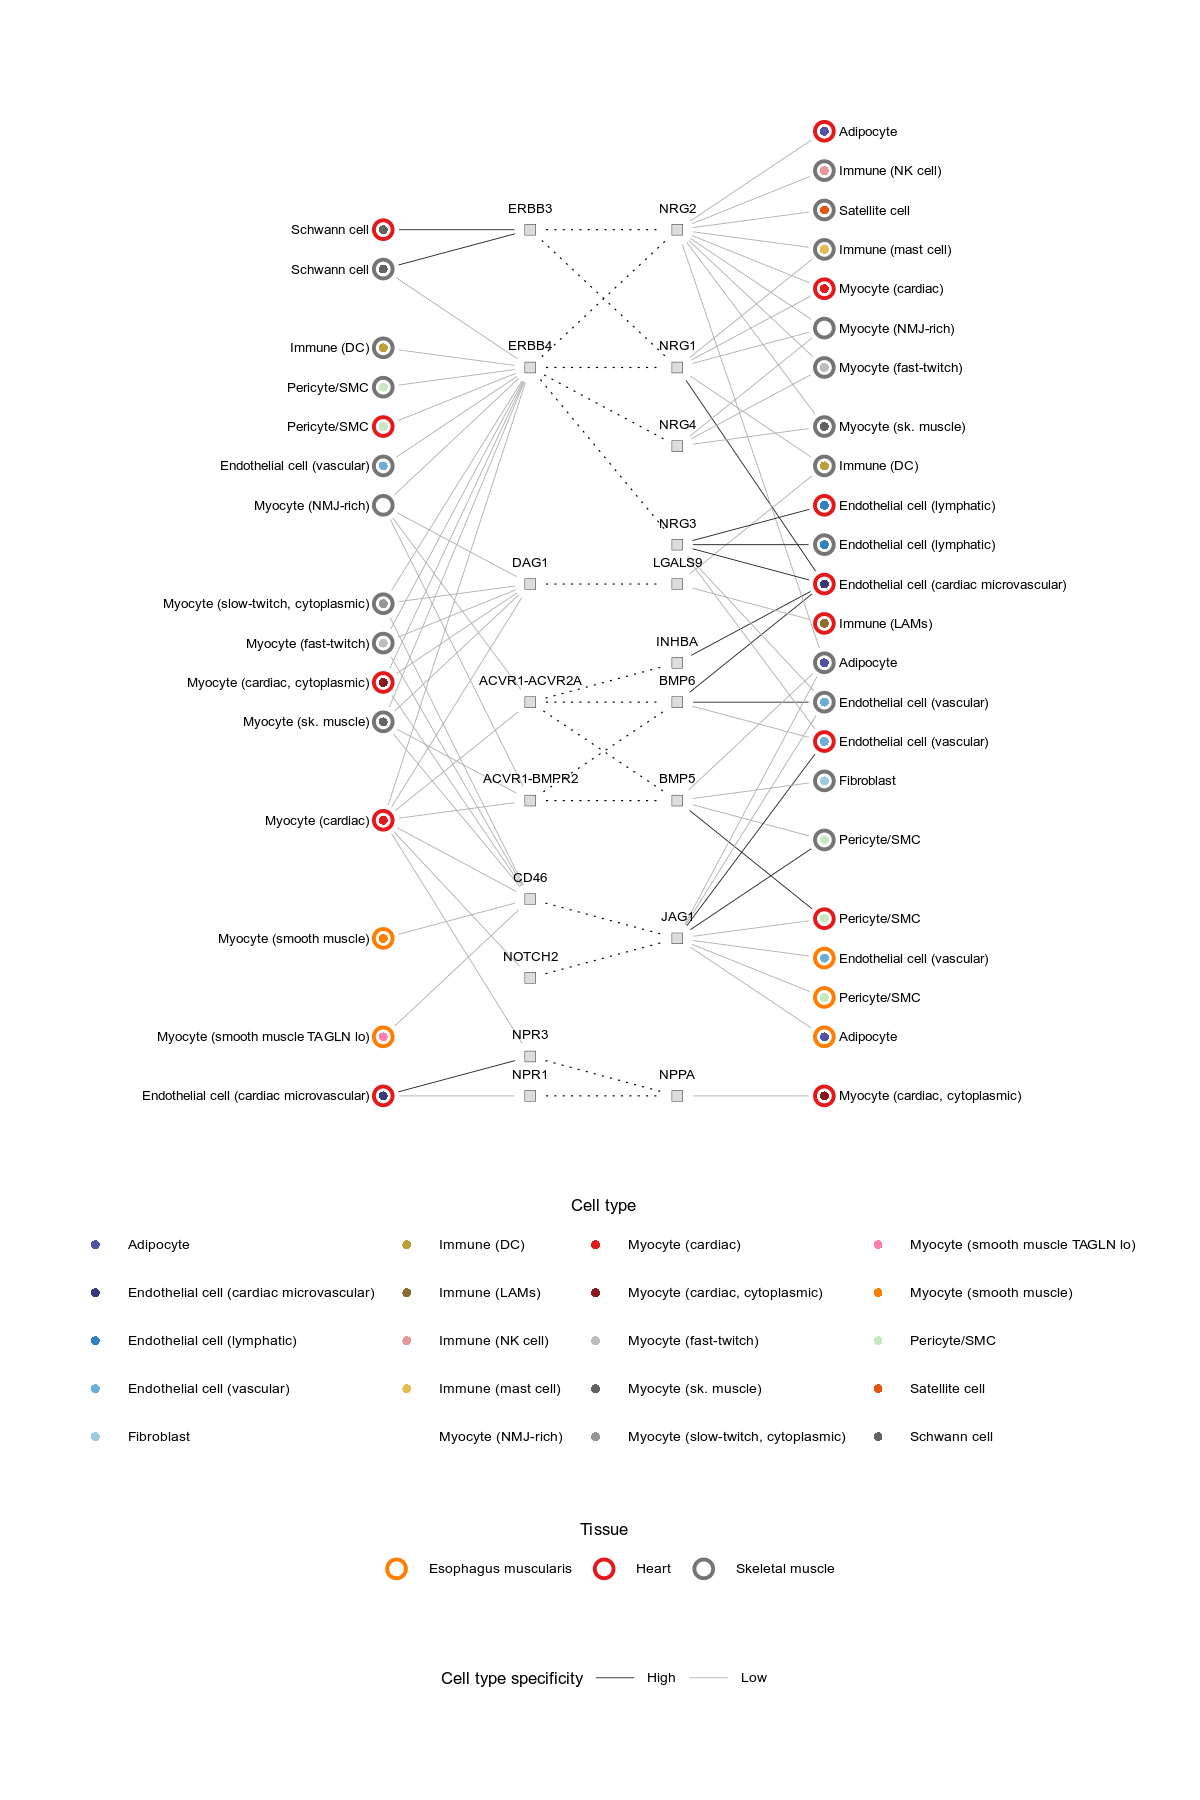

In [482]:
%%R -w 6 -h 9 -u in -r 200 -i nodes -i edges -i color_names -i color_values

library(ggraph)
library(tidygraph)
library(graphlayouts)
library(igraph)
library(ggrepel)

graph <- tbl_graph(nodes=nodes, edges=edges, node_key='node_id', directed=F)
colors = unlist(color_values)
names(colors) = unlist(color_names)

g = ggraph(graph, layout='sugiyama', layers=nodes$layer) + 
    geom_edge_link(aes(filter=type=='', color=!significant), width=0.15, start_cap = circle(2, 'mm'), end_cap = circle(2, 'mm')) + 
    geom_edge_link(aes(filter=type!=''), linetype='dotted', width=0.2, start_cap = circle(2, 'mm'), end_cap = circle(2, 'mm')) +     
    geom_node_point(aes(fill=label_unwrapped, filter=(type2=='celltype')), shape=21, size=1.5, color='white', stroke=0) +
    geom_node_point(aes(color=type, filter=(type2=='celltype')), shape=21, size=2.5, stroke=1) + 
    geom_node_point(aes(filter=(type2=='gene')), fill='#DDDDDD', shape=22, size=2, stroke=0.1, show.legend=F) +     
    geom_node_text(aes(label=label, filter=layer==1), color='black', repel=F, size=1.7, nudge_x=0, nudge_y=0.1, hjust=0) + 
    geom_node_text(aes(label=label, filter=layer==4), color='black', repel=F, size=1.7, nudge_x=0, nudge_y=-0.1, hjust=1) +     
    geom_node_text(aes(label=label, filter=(type2=='gene')), color='black', repel=F, size=1.7, nudge_x=.55) +    
    scale_color_manual(values=list(`Esophagus muscularis`='#ff7e00', Heart='#e3191c', `Skeletal muscle`='#757575')) +
    scale_fill_manual(values=colors) + 
    labs(color='Tissue', fill='Cell type') +
    coord_flip() +
    guides(color = guide_legend(title.position = "top"), fill = guide_legend(title.position = "top", ncol=4)) +
    scale_y_continuous(expand = c(.45, .45)) +
    scale_linetype_discrete(name='DEG', labels=c('A', 'B')) +
    scale_edge_color_manual(values=c('#222222', '#afafaf'), labels=c('High', 'Low'), name='Cell type specificity') +
    theme_graph(fg_text_colour = 'white', base_family = 'Helvetica') + 
    theme(
        legend.position='bottom',
        legend.box='vertical',
        legend.title=element_text(size=6, hjust=0.5), 
        legend.text=element_text(size=5)
    )
    
ggsave('figures/figure-4b.pdf', g, width=6, height=9, useDingbats=F)

g

## Plot muscle disease genes that are involved in the interaction of non-myocytes

In [483]:
muscle_ina = np.array([np.any(np.isin(x if isinstance(x, tuple) else [x], muscle_genes)) for x in cpdb_results.gene_a])
muscle_inb = np.array([np.any(np.isin(x if isinstance(x, tuple) else [x], muscle_genes)) for x in cpdb_results.gene_b])

In [484]:
cpdb_results[(muscle_ina | muscle_inb)][['interacting_pair', 'gene_a', 'gene_b']].drop_duplicates()

interacting_pair  gene_a           gene_b
7               NOTCH1_JAG1  NOTCH1             JAG1
8                 CD46_JAG1    CD46             JAG1
30              JAG1_NOTCH4    JAG1           NOTCH4
36      COL6A3_a1b1 complex  COL6A3   (ITGB1, ITGA1)
95              JAG1_NOTCH2    JAG1           NOTCH2
142    COL6A3_a11b1 complex  COL6A3  (ITGB1, ITGA11)
162     COL6A3_a2b1 complex  COL6A3   (ITGB1, ITGA2)
178             JAG1_NOTCH3    JAG1           NOTCH3
883              ERBB3_NRG1   ERBB3             NRG1
1277             LGALS9_MET  LGALS9              MET
10454            NRG2_ERBB3    NRG2            ERBB3
13847    L1CAM_a5b1 complex   L1CAM   (ITGB1, ITGA5)
14630           L1CAM_L1CAM   L1CAM            L1CAM
14925              NGF_NGFR     NGF             NGFR
16055  COL6A3_a10b1 complex  COL6A3  (ITGB1, ITGA10)
30850               MET_HGF     MET              HGF
44101             ERBB3_BTC   ERBB3              BTC

In [485]:
cpdb_results[(muscle_ina | muscle_inb) & (~cpdb_results.is_integrin)][['interacting_pair', 'gene_a', 'gene_b']].drop_duplicates()

interacting_pair  gene_a  gene_b
7          NOTCH1_JAG1  NOTCH1    JAG1
8            CD46_JAG1    CD46    JAG1
30         JAG1_NOTCH4    JAG1  NOTCH4
95         JAG1_NOTCH2    JAG1  NOTCH2
178        JAG1_NOTCH3    JAG1  NOTCH3
883         ERBB3_NRG1   ERBB3    NRG1
1277        LGALS9_MET  LGALS9     MET
10454       NRG2_ERBB3    NRG2   ERBB3
14630      L1CAM_L1CAM   L1CAM   L1CAM
14925         NGF_NGFR     NGF    NGFR
30850          MET_HGF     MET     HGF
44101        ERBB3_BTC   ERBB3     BTC

In [486]:
remove_genes = ['ERBB3', 'ERBB4', 'JAG1']

In [487]:
muscle_pairs = sorted(cpdb_results[(muscle_ina | muscle_inb) & (~cpdb_results.is_integrin)].interacting_pair.unique())
muscle_pairs = [x for x in muscle_pairs if not np.any([y in x for y in remove_genes])]
muscle_pairs

['L1CAM_L1CAM', 'LGALS9_MET', 'MET_HGF', 'NGF_NGFR']

In [488]:
cpdb_results[cpdb_results.interacting_pair.isin(muscle_pairs)].sort_values('spring_score_mean', ascending=False)

id_cp_interaction interacting_pair      partner_a      partner_b  \
40044   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
14630   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
25588   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
42977   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
18599   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
...                 ...              ...            ...            ...   
28947   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
32366   CPI-SS07F60834D          MET_HGF  simple:P08581  simple:P14210   
19987   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
10300   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
10271   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   

       gene_a gene_b  secreted  receptor_a  receptor_b annotation_strategy  \
40044   L1CAM  L1CAM     False       False       False             curated   
14630   L1CAM  L1CAM     False       False       False             curated   
25588   L1CAM  L1CAM     False       False       False             curated   
42977   L1CAM  L1CAM     False       False       False             curated   
18599   L1CAM  L1CAM     False       False       False             curated   
...       ...    ...       ...         ...         ...                 ...   
28947  LGALS9    MET      True       False        True        InnateDB-All   
32366     MET    HGF      True        True       False             curated   
19987     NGF   NGFR      True       False        True             curated   
10300  LGALS9    MET      True       False        True        InnateDB-All   
10271  LGALS9    MET      True       False        True        InnateDB-All   

       is_integrin  \
40044        False   
14630        False   
25588        False   
42977        False   
18599        False   
...            ...   
28947        False   
32366        False   
19987        False   
10300        False   
10271        False   

                                                         celltype_pair   mean  \
40044                                        Schwann cell|Schwann cell  0.610   
14630                                        Schwann cell|Schwann cell  0.569   
25588                                        Schwann cell|Schwann cell  0.562   
42977                                        Schwann cell|Schwann cell  0.281   
18599                                                Neuronal|Neuronal  0.554   
...                                                                ...    ...   
28947  Immune (alveolar macrophage)|Epithelial cell (alveolar type II)  0.425   
32366                           Epithelial cell (Hillock)|Pericyte/SMC  0.247   
19987                                          Adipocyte|Fibroblast II  0.502   
10300                    Mucous cell II|Endothelial cell (vascular) II  0.320   
10271                     Mucous cell II|Endothelial cell (vascular) I  0.257   

       pval                tissue  significant  neglogpval  \
40044   0.0              Prostate         True        15.0   
14630   0.0      Esophagus mucosa         True        15.0   
25588   0.0                 Heart         True        15.0   
42977   0.0       Skeletal muscle         True        15.0   
18599   0.0  Esophagus muscularis         True        15.0   
...     ...                   ...          ...         ...   
28947   0.0                  Lung         True        15.0   
32366   0.0              Prostate         True        15.0   
19987   0.0                 Heart         True        15.0   
10300   0.0      Esophagus mucosa         True        15.0   
10271   0.0      Esophagus mucosa         True        15.0   

                         celltype_a                          celltype_b  \
40044                  Schwann cell                        Schwann cell   
14630                  Schwann cell            

In [489]:
table = cpdb_results[
    cpdb_results.interacting_pair.isin(muscle_pairs) & 
    (cpdb_results.tissue.isin(['Skeletal muscle', 'Esophagus muscularis', 'Heart'])) &

    #(cpdb_results.spring_score_DE_gene_a>1.5) &
    #(cpdb_results.spring_score_DE_gene_b>1.5) &    
    
    #(cpdb_results.pvals_fdr_DE_gene_a<0.1) &
    #(cpdb_results.pvals_fdr_DE_gene_b<0.1) & 

    (cpdb_results.log2FC_DE_gene_a>0) &
    (cpdb_results.log2FC_DE_gene_b>0) &
    
    (~cpdb_results.celltype_a.str.startswith('Myocyte')) &
    (~cpdb_results.celltype_b.str.startswith('Myocyte')) &
    (~cpdb_results.celltype_a.str.startswith('Unknown')) &    
    (~cpdb_results.celltype_b.str.startswith('Unknown'))
]
table

id_cp_interaction interacting_pair      partner_a      partner_b  \
14925   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
14994   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
16179   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
16235   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
18599   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
18642   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
18659   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19284   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19332   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19338   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19712   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19784   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19803   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19987   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
20013   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
20168   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21629   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21664   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21870   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22244   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22288   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22573   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
23532   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
24771   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
24795   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
24923   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25120   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25145   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25271   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25588   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
40331   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
41262   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
41287   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
41440   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
42977   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   

       gene_a gene_b  secreted  receptor_a  receptor_b annotation_strategy  \
14925     NGF   NGFR      True       False        True             curated   
14994     NGF   NGFR      True       False        True             curated   
16179     NGF   NGFR      True       False        True             curated   
16235     NGF   NGFR      True       False        True             curated   
18599   L1CAM  L1CAM     False       False       False             curated   
18642   L1CAM  L1CAM     False       False       False             curated   
18659   L1CAM  L1CAM     False       False       False             curated   
19284   L1CAM  L1CAM     False       False       False             curated   
19332   L1CAM  L1CAM     False       False       False             curated   
19338   L1CAM  L1CAM     False       False       False             curated   
19712   L1CAM  L1CAM     False       False       False             curated   
19784   L1CAM  L1CAM     False       False       False             curated   
19803   L1CAM  L1CAM     False       False       False             curated   
19987     NGF   NGFR      True       False        True             curated   
20013     NGF   NGFR      True       False        True             curated   
20168     NGF   NGFR      True       False        True             curated   
21629     NGF  

In [490]:
table.receptor_a.loc[table.gene_a == 'NRG1'] = False
table.receptor_b.loc[table.gene_b == 'NRG1'] = False

table.receptor_a.loc[table.gene_a == 'HBEGF'] = False
table.receptor_b.loc[table.gene_b == 'HBEGF'] = False

table.receptor_a.loc[table.gene_a == 'L1CAM'] = True
#table.receptor_b.loc[table.gene_b == 'L1CAM'] = True

In [491]:
muscle_df = muscle_diseases[muscle_diseases.Gene.isin(table.gene_a.unique().tolist() + table.gene_b.unique().tolist())][['Gene', 'Disease group', 'Disease subgroup', 'Disease phenotype']]
muscle_df

Gene                              Disease group  \
757    NGF  Hereditary motor and sensory neuropathies   
840  L1CAM                     Hereditary paraplegias   
871    MET              Other neuromuscular disorders   

                                Disease subgroup  \
757  Hereditary sensory and autonomic neuropathy   
840                Spastic paraplegias, x-linked   
871                               Arthrogryposis   

                                             Disease phenotype  
757  Hereditary sensory and autonomic neuropathy type V - (AR)  
840                                       MASA syndrome - (XR)  
871               Arthrogryposis and muscular dysplasia - (AD)

In [492]:
def simplify_ct(x):
    if x.endswith(' I'):
        return x[:-2]
    if x.endswith(' II'):
        return x[:-3]
    if x.endswith(' III'):
        return x[:-4]
    if x.endswith(' II)'):
        return f'{x[:-4]})'
    return x

table.celltype_a = [simplify_ct(x) for x in table.celltype_a]
table.celltype_b = [simplify_ct(x) for x in table.celltype_b]

In [493]:
table = table[~table.interacting_pair.str.contains('NOTCH2|CD46')]
table

id_cp_interaction interacting_pair      partner_a      partner_b  \
14925   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
14994   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
16179   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
16235   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
18599   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
18642   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
18659   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19284   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19332   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19338   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19712   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19784   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19803   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
19987   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
20013   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
20168   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21629   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21664   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
21870   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22244   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22288   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
22573   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
23532   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
24771   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
24795   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
24923   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25120   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25145   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25271   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
25588   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   
40331   CPI-SS0EDD4928A         NGF_NGFR  simple:P01138  simple:P08138   
41262   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
41287   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
41440   CPI-SS0BC7CD11B       LGALS9_MET  simple:O00182  simple:P08581   
42977   CPI-SS0ACD487F0      L1CAM_L1CAM  simple:P32004  simple:P32004   

       gene_a gene_b  secreted  receptor_a  receptor_b annotation_strategy  \
14925     NGF   NGFR      True       False        True             curated   
14994     NGF   NGFR      True       False        True             curated   
16179     NGF   NGFR      True       False        True             curated   
16235     NGF   NGFR      True       False        True             curated   
18599   L1CAM  L1CAM     False        True       False             curated   
18642   L1CAM  L1CAM     False        True       False             curated   
18659   L1CAM  L1CAM     False        True       False             curated   
19284   L1CAM  L1CAM     False        True       False             curated   
19332   L1CAM  L1CAM     False        True       False             curated   
19338   L1CAM  L1CAM     False        True       False             curated   
19712   L1CAM  L1CAM     False        True       False             curated   
19784   L1CAM  L1CAM     False        True       False             curated   
19803   L1CAM  L1CAM     False        True       False             curated   
19987     NGF   NGFR      True       False        True             curated   
20013     NGF   NGFR      True       False        True             curated   
20168     NGF   NGFR      True       False        True             curated   
21629     NGF  

## ggraph

In [494]:
df = table[['gene_a', 'gene_b', 'celltype_a', 'celltype_b', 'tissue', 'receptor_a', 'receptor_b', 
            'significant_DE_gene_a', 'significant_DE_gene_b', 'spring_score_nonzero_DE_gene_a', 'spring_score_nonzero_DE_gene_b']].drop_duplicates().reset_index(drop=True)

df['sigpos_a'] = df.significant_DE_gene_a & (df.spring_score_nonzero_DE_gene_a>1.5)
df['sigpos_b'] = df.significant_DE_gene_b & (df.spring_score_nonzero_DE_gene_b>1.5)

df['gene_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.gene_a, df.gene_b, df.receptor_a, df.receptor_b)]
df['gene_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.gene_a, df.gene_b, df.receptor_a, df.receptor_b)]

df['celltype_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.celltype_a, df.celltype_b, df.receptor_a, df.receptor_b)]
df['celltype_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.celltype_a, df.celltype_b, df.receptor_a, df.receptor_b)]

df['significant_receptor'] = [g1 if r1 else g2 for g1, g2, r1, r2 in zip(df.sigpos_a, df.sigpos_b, df.receptor_a, df.receptor_b)]
df['significant_ligand'] = [g2 if r1 else g1 for g1, g2, r1, r2 in zip(df.sigpos_a, df.sigpos_b, df.receptor_a, df.receptor_b)]

df.drop(columns=['gene_a', 'gene_b', 'celltype_a', 'celltype_b', 'receptor_a', 'receptor_b', 'sigpos_a', 'sigpos_b',
                'significant_DE_gene_a', 'significant_DE_gene_b', 'spring_score_nonzero_DE_gene_a', 'spring_score_nonzero_DE_gene_b'], inplace=True)

df['gene_receptor_id'] = [f'{x}-rec' for x in df.gene_receptor]
df['gene_ligand_id'] = [f'{x}-lig' for x in df.gene_ligand]

df['celltype_receptor_id'] = [f'{x}-rec-{t}' for x,t in zip(df.celltype_receptor, df.tissue)]
df['celltype_ligand_id'] = [f'{x}-lig-{t}' for x,t in zip(df.celltype_ligand, df.tissue)]

df

tissue gene_receptor gene_ligand  \
0   Esophagus muscularis          NGFR         NGF   
1   Esophagus muscularis          NGFR         NGF   
2   Esophagus muscularis          NGFR         NGF   
3   Esophagus muscularis          NGFR         NGF   
4   Esophagus muscularis         L1CAM       L1CAM   
5   Esophagus muscularis         L1CAM       L1CAM   
6   Esophagus muscularis         L1CAM       L1CAM   
7   Esophagus muscularis         L1CAM       L1CAM   
8   Esophagus muscularis         L1CAM       L1CAM   
9   Esophagus muscularis         L1CAM       L1CAM   
10  Esophagus muscularis         L1CAM       L1CAM   
11  Esophagus muscularis         L1CAM       L1CAM   
12  Esophagus muscularis         L1CAM       L1CAM   
13                 Heart          NGFR         NGF   
14                 Heart          NGFR         NGF   
15                 Heart          NGFR         NGF   
16                 Heart          NGFR         NGF   
17                 Heart          NGFR         NGF   
18                 Heart          NGFR         NGF   
19                 Heart          NGFR         NGF   
20                 Heart          NGFR         NGF   
21                 Heart          NGFR         NGF   
22                 Heart           MET      LGALS9   
23                 Heart          NGFR         NGF   
24                 Heart          NGFR         NGF   
25                 Heart          NGFR         NGF   
26                 Heart          NGFR         NGF   
27                 Heart          NGFR         NGF   
28                 Heart          NGFR         NGF   
29                 Heart         L1CAM       L1CAM   
30       Skeletal muscle          NGFR         NGF   
31       Skeletal muscle           MET      LGALS9   
32       Skeletal muscle           MET      LGALS9   
33       Skeletal muscle           MET      LGALS9   
34       Skeletal muscle         L1CAM       L1CAM   

              celltype_receptor celltype_ligand  significant_receptor  \
0                      Neuronal       Adipocyte                 False   
1                  Schwann cell       Adipocyte                 False   
2                      Neuronal      Fibroblast                 False   
3                  Schwann cell      Fibroblast                 False   
4                      Neuronal        Neuronal                  True   
5                      Neuronal    Schwann cell                  True   
6                      Neuronal    Schwann cell                  True   
7                  Schwann cell        Neuronal                  True   
8                  Schwann cell    Schwann cell                  True   
9                  Schwann cell    Schwann cell                  True   
10                 Schwann cell        Neuronal                 False   
11                 Schwann cell    Schwann cell                 False   
12                 Schwann cell    Schwann cell                 False   
13                   Fibroblast       Adipocyte                 False   
14                   Fibroblast       Adipocyte                 False   
15                 Schwann cell       Adipocyte                  True   
16                   Fibroblast      Fibroblast                 False   
17                   Fibroblast      Fibroblast                 False   
18                 Schwann cell      Fibroblast                  True   
19                   Fibroblast      Fibroblast                 False   
20                   Fibroblast      Fibroblast                 False   
21                 Schwann cell      Fibroblast                  True   
22  Endothelial cell (vascular)   Immune (LAMs)                  True   
23                   Fibroblast    Pericyte/SMC                 False   
24                   Fibroblast    Pericyte/SMC                 False   
25                 Schwann cell    Pericyte/SMC                  True   
26                   Fibroblast    Pericyte/SMC                 False   
27                   Fibrobla

In [495]:
nodes = pd.concat([
    df[['gene_receptor_id', 'gene_receptor']].drop_duplicates().rename(columns={'gene_receptor_id': 'node_id', 'gene_receptor': 'label'}).assign(layer=3, type='gene', type2='gene'),
    df[['gene_ligand_id', 'gene_ligand']].drop_duplicates().rename(columns={'gene_ligand_id': 'node_id', 'gene_ligand': 'label'}).assign(layer=2, type='gene', type2='gene'),
    
    df[['celltype_ligand_id', 'celltype_ligand', 'tissue']].drop_duplicates().rename(columns={'celltype_ligand_id': 'node_id', 'celltype_ligand': 'label', 'tissue': 'type'}).assign(layer=1, type2='celltype'),
    df[['celltype_receptor_id', 'celltype_receptor', 'tissue']].drop_duplicates().rename(columns={'celltype_receptor_id': 'node_id', 'celltype_receptor': 'label', 'tissue': 'type'}).assign(layer=4, type2='celltype'),
], axis=0).drop_duplicates().reset_index(drop=True)

from textwrap import fill

nodes['label_unwrapped'] = nodes['label']
nodes['label'] = [fill(x, 20) for x in nodes['label']]
nodes

node_id  \
0                                          NGFR-rec   
1                                         L1CAM-rec   
2                                           MET-rec   
3                                           NGF-lig   
4                                         L1CAM-lig   
5                                        LGALS9-lig   
6                Adipocyte-lig-Esophagus muscularis   
7               Fibroblast-lig-Esophagus muscularis   
8                 Neuronal-lig-Esophagus muscularis   
9             Schwann cell-lig-Esophagus muscularis   
10                              Adipocyte-lig-Heart   
11                             Fibroblast-lig-Heart   
12                          Immune (LAMs)-lig-Heart   
13                           Pericyte/SMC-lig-Heart   
14                           Schwann cell-lig-Heart   
15                    Adipocyte-lig-Skeletal muscle   
16                  Immune (DC)-lig-Skeletal muscle   
17                 Schwann cell-lig-Skeletal muscle   
18                Neuronal-rec-Esophagus muscularis   
19            Schwann cell-rec-Esophagus muscularis   
20                             Fibroblast-rec-Heart   
21                           Schwann cell-rec-Heart   
22            Endothelial cell (vascular)-rec-Heart   
23                 Schwann cell-rec-Skeletal muscle   
24  Endothelial cell (vascular)-rec-Skeletal muscle   
25               Satellite cell-rec-Skeletal muscle   

                           label  layer                  type     type2  \
0                           NGFR      3                  gene      gene   
1                          L1CAM      3                  gene      gene   
2                            MET      3                  gene      gene   
3                            NGF      2                  gene      gene   
4                          L1CAM      2                  gene      gene   
5                         LGALS9      2                  gene      gene   
6                      Adipocyte      1  Esophagus muscularis  celltype   
7                     Fibroblast      1  Esophagus muscularis  celltype   
8                       Neuronal      1  Esophagus muscularis  celltype   
9                   Schwann cell      1  Esophagus muscularis  celltype   
10                     Adipocyte      1                 Heart  celltype   
11                    Fibroblast      1                 Heart  celltype   
12                 Immune (LAMs)      1                 Heart  celltype   
13                  Pericyte/SMC      1                 Heart  celltype   
14                  Schwann cell      1                 Heart  celltype   
15                     Adipocyte      1       Skeletal muscle  celltype   
16                   Immune (DC)      1       Skeletal muscle  celltype   
17                  Schwann cell      1       Skeletal muscle  celltype   
18                      Neuronal      4  Esophagus muscularis  celltype   
19                  Schwann cell      4  Esophagus muscularis  celltype   
20                    Fibroblast      4                 Heart  celltype   
21                  Schwann cell      4                 Heart  celltype   
22  Endothelial cell\n(vascular)      4                 Heart  celltype   
23                  Schwann cell      4       Skeletal muscle  celltype   
24  Endothelial cell\n(vascular)      4       Skeletal muscle  celltype   
25                Satellite cell      4       Skeletal muscle  celltype   

                label_unwrapped  
0                          NGFR  
1                         L1CAM  
2                           MET  
3                           NGF  
4                         L1CAM  
5                        LGALS9  
6                     Adipocyte  
7                    Fibroblast  
8                      Neuronal  
9                  Schwann cell  
10                    Adipocyte  
11                   Fibroblast  
12                Immune (LAMs)  
13                 Pericyte/SMC  
14                 Sch

In [496]:
edges = pd.concat([
    df[['gene_ligand_id', 'gene_receptor_id']].drop_duplicates().rename(columns={'gene_receptor_id': 'from', 'gene_ligand_id': 'to'}).assign(significant=True, type='reclig'),
    df[['celltype_ligand_id', 'gene_ligand_id', 'significant_ligand']].drop_duplicates().rename(columns={'celltype_ligand_id': 'from', 'gene_ligand_id': 'to', 'significant_ligand': 'significant'}),
    df[['celltype_receptor_id', 'gene_receptor_id', 'significant_receptor']].drop_duplicates().rename(columns={'celltype_receptor_id': 'from', 'gene_receptor_id': 'to', 'significant_receptor': 'significant'}),    
], axis=0).fillna('')

edges = edges.groupby(['to', 'from', 'type'])[['significant']].agg(lambda x: np.sum(x).astype(bool)).reset_index()

edges

to                                             from    type  \
0    L1CAM-lig                                        L1CAM-rec  reclig   
1    L1CAM-lig                Neuronal-lig-Esophagus muscularis           
2    L1CAM-lig            Schwann cell-lig-Esophagus muscularis           
3    L1CAM-lig                           Schwann cell-lig-Heart           
4    L1CAM-lig                 Schwann cell-lig-Skeletal muscle           
5    L1CAM-rec                Neuronal-rec-Esophagus muscularis           
6    L1CAM-rec            Schwann cell-rec-Esophagus muscularis           
7    L1CAM-rec                           Schwann cell-rec-Heart           
8    L1CAM-rec                 Schwann cell-rec-Skeletal muscle           
9   LGALS9-lig                  Immune (DC)-lig-Skeletal muscle           
10  LGALS9-lig                          Immune (LAMs)-lig-Heart           
11  LGALS9-lig                                          MET-rec  reclig   
12     MET-rec            Endothelial cell (vascular)-rec-Heart           
13     MET-rec  Endothelial cell (vascular)-rec-Skeletal muscle           
14     MET-rec               Satellite cell-rec-Skeletal muscle           
15     NGF-lig               Adipocyte-lig-Esophagus muscularis           
16     NGF-lig                              Adipocyte-lig-Heart           
17     NGF-lig                    Adipocyte-lig-Skeletal muscle           
18     NGF-lig              Fibroblast-lig-Esophagus muscularis           
19     NGF-lig                             Fibroblast-lig-Heart           
20     NGF-lig                                         NGFR-rec  reclig   
21     NGF-lig                           Pericyte/SMC-lig-Heart           
22    NGFR-rec                             Fibroblast-rec-Heart           
23    NGFR-rec                Neuronal-rec-Esophagus muscularis           
24    NGFR-rec            Schwann cell-rec-Esophagus muscularis           
25    NGFR-rec                           Schwann cell-rec-Heart           
26    NGFR-rec                 Schwann cell-rec-Skeletal muscle           

    significant  
0          True  
1          True  
2          True  
3          True  
4         False  
5          True  
6          True  
7          True  
8         False  
9         False  
10        False  
11         True  
12         True  
13        False  
14        False  
15         True  
16        False  
17        False  
18        False  
19        False  
20         True  
21         True  
22        False  
23        False  
24        False  
25         True  
26        False

In [497]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [498]:
color_dict

{'Adipocyte': '#5254a3',
 'Endothelial cell (cardiac microvascular)': '#393b79',
 'Endothelial cell (lymphatic)': '#3182bd',
 'Endothelial cell (vascular)': '#6baed6',
 'Fibroblast': '#9ecae1',
 'ICCs': '#8c6d31',
 'Immune (B cell)': '#843c39',
 'Immune (DC)': '#bd9e39',
 'Immune (DC/macrophage)': '#d6616b',
 'Immune (NK cell)': '#e7969c',
 'Immune (T cell)': '#7b4173',
 'Immune (macrophage)': '#a55194',
 'Immune (neutrophil)': '#ce6dbd',
 'Neuronal': '#637939',
 'Pericyte/SMC': '#c7e9c0',
 'Satellite cell': '#e6550d',
 'Schwann cell': '#636363',
 'Other': '#DDDDDD',
 'Immune (LAMs)': '#8c6d31',
 'Immune (mast cell)': '#e7ba52',
 'Myocyte (sk. muscle)': '#636363',
 'Myocyte (slow-twitch, cytoplasmic)': '#969696',
 'Myocyte (fast-twitch)': '#bdbdbd',
 'Myocyte (cardiac)': '#e3191c',
 'Myocyte (cardiac, cytoplasmic)': '#88191c',
 'Myocyte (smooth muscle)': '#ff7e00',
 'Myocyte (smooth muscle TAGLN lo)': '#ff7eaa'}

In [499]:
color_dict['Immune (mast cell)'] = '#d6616b'
color_dict['Immune (LAMs)'] = '#e7969c'

In [500]:
color_names, color_values = zip(*color_dict.items())
color_names = list(color_names)
color_values = list(color_values)

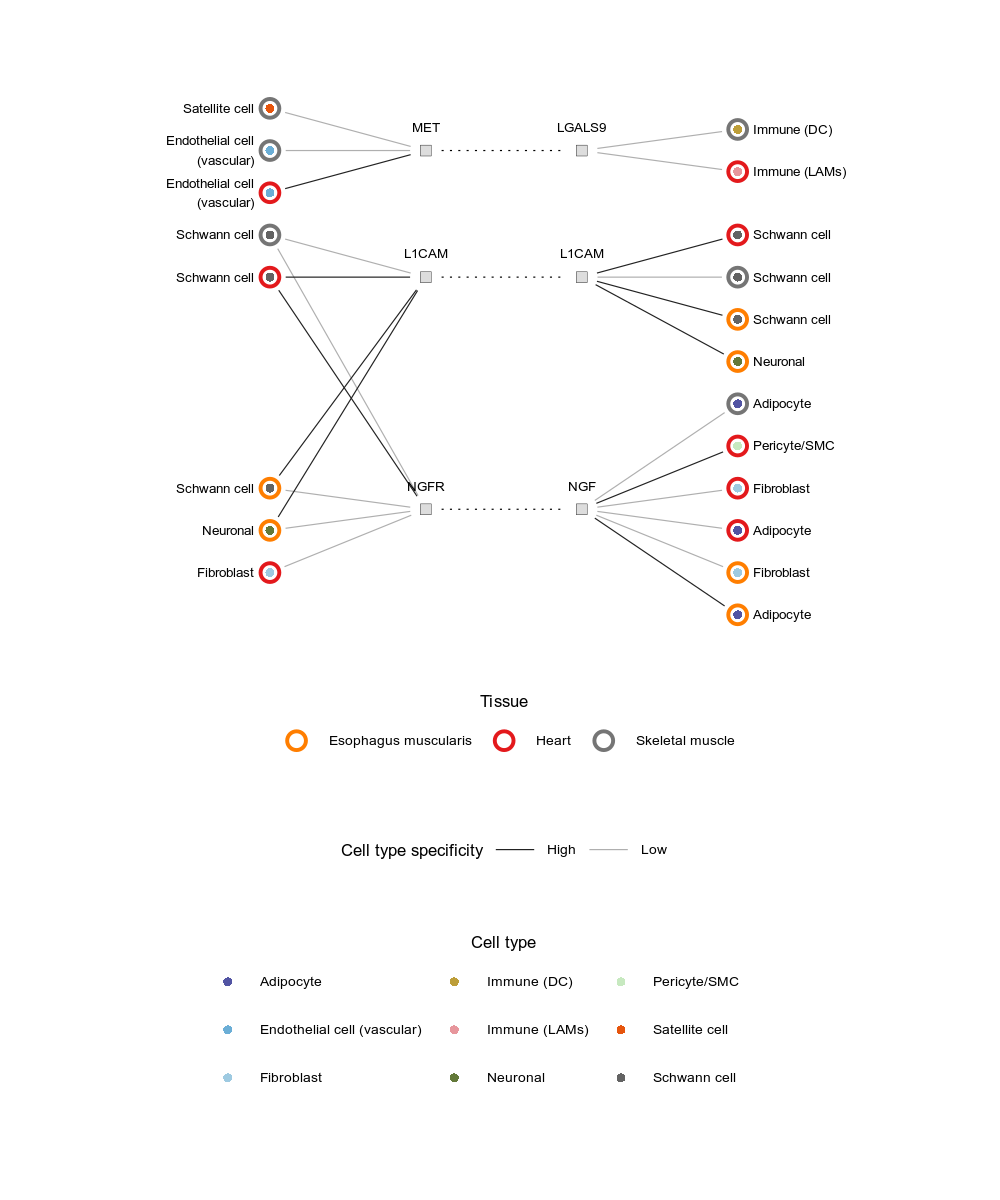

In [501]:
%%R -w 5 -h 6 -u in -r 200 -i nodes -i edges -i color_names -i color_values

library(ggraph)
library(tidygraph)
library(graphlayouts)
library(igraph)
library(ggrepel)

graph <- tbl_graph(nodes=nodes, edges=edges, node_key='node_id', directed=F)
colors = unlist(color_values)
names(colors) = unlist(color_names)

g = ggraph(graph, layout='sugiyama', layers=nodes$layer) + 
    geom_edge_link(aes(color=!significant, filter=type==''), width=0.2, start_cap = circle(2, 'mm'), end_cap = circle(2, 'mm')) + 
    geom_edge_link(aes(filter=type!=''), linetype='dotted', width=0.2, start_cap = circle(2, 'mm'), end_cap = circle(2, 'mm')) +     
    geom_node_point(aes(fill=label_unwrapped, filter=(type2=='celltype')), shape=21, size=1.5, color='white', stroke=0) +
    geom_node_point(aes(color=type, filter=(type2=='celltype')), shape=21, size=2.5, stroke=1) + 
    geom_node_point(aes(filter=(type2=='gene')), fill='#DDDDDD', shape=22, size=2, stroke=0.1, show.legend=F) +     
    geom_node_text(aes(label=label, filter=layer==1), color='black', repel=F, size=1.7, nudge_x=0, nudge_y=0.1, hjust=0) + 
    geom_node_text(aes(label=label, filter=layer==4), color='black', repel=F, size=1.7, nudge_x=0, nudge_y=-0.1, hjust=1) +     
    geom_node_text(aes(label=label, filter=(type2=='gene')), color='black', repel=F, size=1.7, nudge_x=.55) +    
    scale_color_manual(values=list(`Esophagus muscularis`='#ff7e00', Heart='#e3191c', `Skeletal muscle`='#757575')) +
    scale_fill_manual(values=colors) + 
    labs(color='Tissue', fill='Cell type') +
    coord_flip() +
    guides(color = guide_legend(title.position = "top"), fill = guide_legend(title.position = "top", ncol=4)) +
    scale_y_continuous(expand = c(.25, .25)) +
    scale_linetype_discrete(name='DEG', labels=c('A', 'B')) +
    scale_edge_color_manual(values=c('#222222', '#afafaf'), labels=c('High', 'Low'), name='Cell type specificity') +
    theme_graph(fg_text_colour = 'white', base_family = 'Helvetica') + 
    theme(
        legend.position='bottom',
        legend.box='vertical',
        legend.title=element_text(size=6, hjust=0.5), 
        legend.text=element_text(size=5)
    )
    
ggsave('figures/figure-4d.pdf', g, width=5, height=6, useDingbats=F)

g